<a href="https://colab.research.google.com/github/saimani5/Notebooks_for_papers/blob/main/ferrosim_dkl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook applies DKL (both active and static settings) on various target functions of FerroSIM simulations in the context of process optimization in high dimensional spaces.  
* Earlier, variational autoencoders are also applied to this same dataset in the same context.  
Link to paper: https://doi.org/10.1039/D2DD00065B  
Link to Notebook on VAE: https://github.com/saimani5/Notebooks_for_papers/blob/main/FerroSim_VAE_BO_code_for_paper.ipynb

*   Link to the FerroSIM repository: https://github.com/ramav87/FerroSim
*   DKL uses gpax written on jax and Haiku: https://github.com/ziatdinovmax/gpax 
*   The target functions considered for BO are curl, normalized curl and total polarization.  
*   Results for all the cases are downloaded in their respective cells 
*   Any changes in the results from the paper are due to jax seeds which behave differently on different devices.  

  
  

Please write to valletisai.mani@gmail.com if you have any questions.

# Downloading and importing libraries; downloading data for Ferrosim

In [1]:
!pip install -e git+https://github.com/ramav87/FerroSim.git@rama_dev_updated#egg=FerroSim
!pip install -q jaxlib==0.4.4+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining FerroSim from git+https://github.com/ramav87/FerroSim.git@rama_dev_updated#egg=FerroSim
  Cloning https://github.com/ramav87/FerroSim.git (to revision rama_dev_updated) to ./src/ferrosim
  Running command git clone --filter=blob:none --quiet https://github.com/ramav87/FerroSim.git /content/src/ferrosim
  Running command git checkout -b rama_dev_updated --track origin/rama_dev_updated
  Switched to a new branch 'rama_dev_updated'
  Branch 'rama_dev_updated' set up to track remote branch 'rama_dev_updated' from 'origin'.
  Resolved https://github.com/ramav87/FerroSim.git to commit 5eb258e2a47d10b3d9bdb9e94dd9879b8410024c
  Preparing metadata (setup.py) ... done
  Running setup.py develop for FerroSim
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 6.3 MB/s eta 0:00:00


In [2]:
!pip install -q gdown==4.5.4 jax==0.4.4 gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 21.5 MB/s eta 0:00:00


In [1]:
# Importing the packages
from joblib import Parallel, delayed
import torch

import numpy as np
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

from ferrosim import Ferro2DSim

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()

In [2]:
# Downloading the FerroSIM data
!gdown 11hfagD1JxdzYiZrXeU6nNUWnSF9ngUXu
!gdown 1vAVM_6MWbkw-WdWPMPZaL92y6Jtecr6R
!gdown 1y-JuTh978cHauxeD3AnqhOAFeEKDAnq_

dataset = np.load('dataset.npy')   # 7,500 electric fields, the generation of these will be discussed below
pmats_total = np.load('pmats_total.npy')   # Polarization matrices at the end of FerroSIM simulations for the electric fields downloaded
defects = np.load('defect_list_seed.npy')   # Defects used in ferroSIM simulations
defect_list = list(defects)

Downloading...
From: https://drive.google.com/uc?id=11hfagD1JxdzYiZrXeU6nNUWnSF9ngUXu
To: /content/dataset.npy
100% 54.0M/54.0M [00:00<00:00, 58.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vAVM_6MWbkw-WdWPMPZaL92y6Jtecr6R
To: /content/pmats_total.npy
100% 48.0M/48.0M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1y-JuTh978cHauxeD3AnqhOAFeEKDAnq_
To: /content/defect_list_seed.npy
100% 6.53k/6.53k [00:00<00:00, 9.66MB/s]


# Intro to FerroSIM

In [3]:
# Function for preparing the electric fields
#Curves of the form Aexp(aplha*t)cos(wt)+B

#0 to 4 seconds divided into 1200 datapoints (t_vec_dummy)
#The Field for the last 50 points is set to a constant values i.e, E[899]

#We will use t_vec_dummy to normalize the curves
#If we consider just the first seconds in normalization, all the curves with ...
# a +ve alpha will be cut off at 1, To avoid this we will let the curve hit ...
# the next peak and then use it to normalize


t_vec_dummy = np.linspace(0,4,1200)
t_vec = t_vec_dummy[0:900]  #Time used in rvae  
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim


def gen_dataset(nsamples: int = 7500, 
                A_range: list = [0, .75],
                alpha_range: list = [-2.75, 2.75],
                w_range: list = [2*np.pi, (8/3)*np.pi],
                B_range: list = [-0.5, 0.5],
                norm: bool = True) -> np.array:
  
    # Setting the seed for reproducible results
    np.random.seed(171)
  
    A = np.random.uniform(low = A_range[0], high = A_range[1],
                            size = nsamples)
    
    alpha = np.random.uniform(low = alpha_range[0], high = alpha_range[1], 
                                size = nsamples)
                                    
    w = np.random.uniform(low = w_range[0], high = w_range[1], 
                            size = nsamples)
                                    
    B = np.random.uniform(low = B_range[0], high = B_range[1], 
                            size = nsamples)
                                    
    E = np.zeros([nsamples, len(t_vec)])
    for i in range(nsamples):
    
        full_curve = A[i]*np.exp(alpha[i]*t_vec_dummy)*np.cos(w[i]*t_vec_dummy) + B[i]
    
    #Cut off E at 3 sec
    # E[i, 300::] = E[i, 299]

    #Normalize each datapoint
        if norm:
            full_curve_norm = 2*((full_curve - np.amin(full_curve))/np.ptp(full_curve)) - 1
            noise = np.random.normal(loc = 0.0, scale = 0.02,size = len(t_vec_dummy))
            full_curve_norm = full_curve_norm + noise

        E[i] = full_curve_norm[0:900]
    return E, A, alpha, w, B

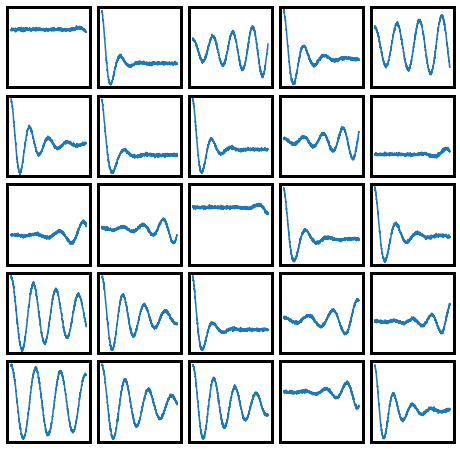

In [4]:
# Code to generate the dataset, We have already downloaded the dataset at the start to avoid seed issues
# dataset, A_real, alpha_real, w_real, B_real = gen_dataset() 


# Visualizing some electric fields
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))


for ax, y in zip(axes.flat, dataset):
    ax.plot(t_vec, y)
    ax.set_ylim (-1.1,1.1)

Example of a ferrosim simulation

In [5]:
# Ferrosim has a method that calcluates the curl of a given polarization matrix
# To use it, we need to create an instance of the FerroSIM. While creating the instance, 
# we will walk through an example of FerroSIM simulation

#Pick any one field from the field trajectories
# Multiplying it with a constant to make it physical, This constant can change the entire curl surface
applied_field = np.zeros([len(t_vec_ext),2])
applied_field[0:900,0] = 150*dataset[512]
applied_field[900::,0] = applied_field[899, 0]   #Adding the equilibration region
np.random.seed(512)
sim = Ferro2DSim(n=20,    #Lattice size 
                 time_vec = t_vec_ext,   #Time Vector
                 appliedE= applied_field,   # Applied electric field in x and y directons
                 defects=defect_list,       # Any list of defects
                 mode = 'tetragonal',       #Mode of the free energy equations to be used, refer: https://github.com/ramav87/FerroSim/blob/rama_dev_updated/equations.docx
                 init = 'pr',       #Initialization mode, random initialization might not cause reproducibility and hence all the lattice sites are initialized to a constant value
                 k=100.0,         # coupling constant, K = k/8, where K is the coupling constant in the free energy equation
                 dep_alpha = 0.3  #Depolarization constant
                 )

sim.runSim()

---Performing simulation---


100%|██████████| 948/948 [00:50<00:00, 18.70it/s]


{'Polarization': array([[   0.        ,   46.69407778,   57.63946765, ..., -225.33271619,
         -225.3687708 , -225.40668959],
        [   0.        ,    0.73501264,    0.95061945, ...,    8.7476161 ,
            8.7295951 ,    8.70882211]]),
 'dPolarization': array([[    0.        , 13996.54981398, 13778.29297494, ...,
           -62.62556612,   -59.33408458,   -55.45454149],
        [    0.        ,   220.32003826,   209.45607462, ...,
           -27.75449769,   -27.04330938,   -25.89016839]])}

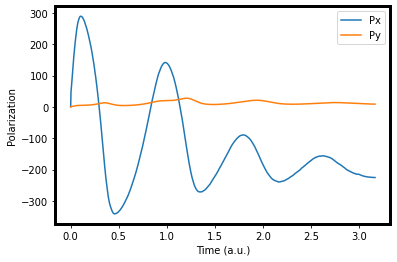

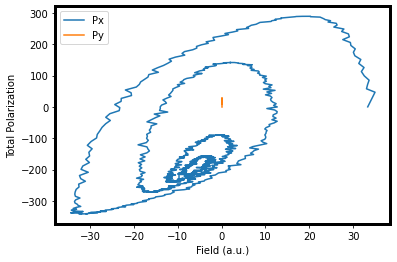

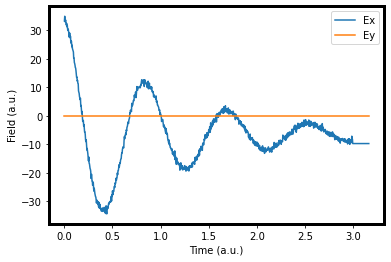

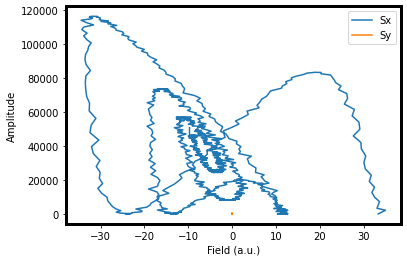

In [6]:
# Plotting the results
sim.plot_summary()

In [7]:
# Getting the sum of absolute curls of the last time step i.e., 'curl' of the ferrosim simulation
np.sum(np.abs(sim.calc_curl(sim.getPmat(time_step = -1))))

9.81863915588309

# Preparing the Targets for DKL

In [8]:
# This cell runs the ferrosim simulation on all the electric fields and saves the polarization matrix at the last time step
# We have used 64 cores on cloud to parallelize the simulation and saved the results
# The polarization matrices are downloaded at the start of the notebook and are called pmats_total
X = np.copy(dataset)

def runferrosim(i, X, fmul = 150):
    np.random.seed(512)
    applied_field = np.zeros([len(t_vec_ext),2])
    applied_field[0:900,0] = fmul*X[i]
    applied_field[900::,0] = applied_field[899, 0]
    np.random.seed(512)
    sim = Ferro2DSim(n=20, time_vec = t_vec_ext, appliedE= applied_field,
                 defects=defect_list, 
                 mode = 'tetragonal', init = 'pr', k=100.0, dep_alpha = 0.3)
    sim.runSim()
#     curl = np.sum(np.abs(sim.calc_curl(sim.getPmat(time_step = -1))))
    pmat = sim.getPmat(time_step = -1)
    del sim
    return pmat



# results = (Parallel(n_jobs=-2)(delayed(runferrosim)(i, X, 150) for i in range(len(X))))

# pmats_total = np.array(results)
# print(np.shape(pmats_total))


In [9]:
# Evaluating the targets for DKL

curls_total = np.zeros(len(X))  # Curls
p_total = np.zeros(len(X))    # Polarization
curls_norm = np.zeros(len(X))   #Normalized curl


for i in range(len(X)):
    curls_total[i] = np.sum(np.abs(sim.calc_curl(pmats_total[i])))    # Sum of absolute curls, Used in RSC-DD paper
    p_total[i] = np.sum(np.sqrt(np.sum(pmats_total[i]**2, axis = 0)))  # Polarization
    
    # Calculating the normalized curl
    #Magnitude of polarization field
    punit = (np.sqrt(np.sum(pmats_total[i]**2, axis = 0)))   

    pmat_unit = pmats_total[i]/(punit)   # Unit polarization vectors
    
    curls_norm[i] = np.sum(np.abs(sim.calc_curl(pmat_unit)))   # Curl calculated with normalized polarization at each site

# DKL and BO on various targets

Let's train one dkl for each of these properties that we have obtained so far  
The dkl numbers will be as follows:  
1: curls_total  
2: curls_norm   
3: p_total

## Case-1
Targets: Curls

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

Text(0.5, 1.0, 'Polarization_total')

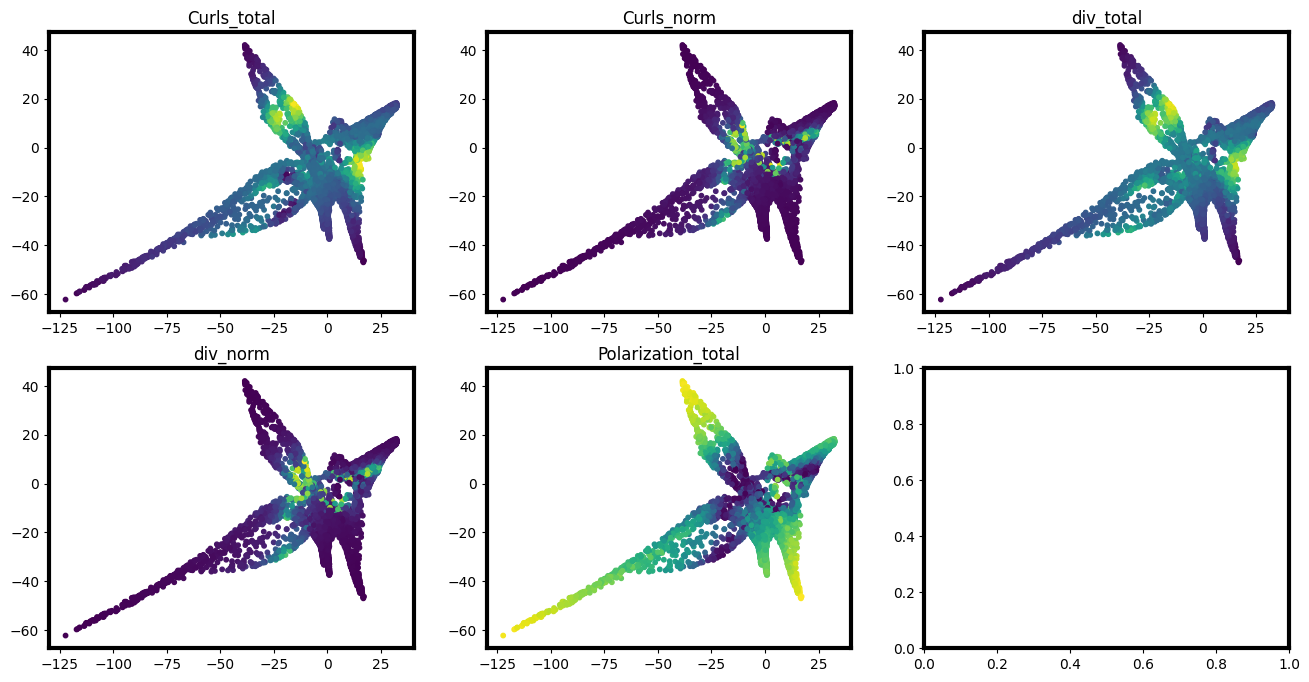

In [ ]:
# Training the DKL on the whole network
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(900, 2, 'RBF')
dkl_1.fit(rng_key_1, X, curls_total)

# Predictions on the entire dataset
y_mean, y_var = dkl_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_1, X, batch_size=250)

# Latent space embeddings on the entire dataset
embeded_1 = dkl_1.embed(X)

# Visualization of latent space distributions in static setting
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,8))
ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = curls_total)
ax[0,0].set_title('Curls_total')

ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = curls_norm)
ax[0,1].set_title('Curls_norm')

# ax[0,2].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = div_total)
# ax[0,2].set_title('div_total')

# ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = div_norm)
# ax[1,0].set_title('div_norm')

ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = p_total)
ax[1,1].set_title('Polarization_total')

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [ ]:
# Picking the initialization points and preparing the dataset for BO

X1 = np.copy(dataset)
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = 100, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(dataset))
indices_train_1 = indices_total_1[idx1]
y1_train = curls_total[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

# Predictions made using the DKL trained on the whole dataset
y1_mean_full, y1_var_full = dkl_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_1, X1, batch_size=250)

y1_std_full = jnp.sqrt(y1_var_full)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Running the dkl_BO model with 500 exploration steps

exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])
    
    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(y1_mean_full[ind_next])
    dkl_std1.append(y1_std_full[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = curls_total[ind_next]
    
    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)
    
    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=100)
    
    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)
    traj_std1.append(traj_s)

# Saving the results
curls_results = {}
curls_results['X_train'] = X1_train
curls_results['y_train'] = y1_train
curls_results['X_unmeasured'] = X1_unmeasured
curls_results['indices_unmeasured'] = indices_unmeasured_1
curls_results['dkl_mean'] = dkl_mean1
curls_results['dkl_std'] = dkl_std1
curls_results['exp_mean'] = exp_mean1
curls_results['exp_std'] = exp_std1
curls_results['traj_mean'] = traj_mean1
curls_results['traj_std'] = traj_std1
curls_results['embed_traj'] = embed_traj1

with open('curls_results.pickle', 'wb') as handle:
    pickle.dump(curls_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 380.92it/s, init loss: 61974.6659, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1361 1.4181]
k_scale          3.6472
noise            0.2356

Step 2


100%|█| 1000/1000 [00:02<00:00, 416.96it/s, init loss: 61994.4277, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0179 1.5121]
k_scale          3.3144
noise            0.2756

Step 3


100%|█| 1000/1000 [00:02<00:00, 416.27it/s, init loss: 62022.7820, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9304 1.4803]
k_scale          4.2325
noise            0.2576

Step 4


100%|█| 1000/1000 [00:02<00:00, 341.24it/s, init loss: 62031.2629, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9332 1.4996]
k_scale          3.5692000000000004
noise            0.2358

Step 5


100%|█| 1000/1000 [00:02<00:00, 415.71it/s, init loss: 62034.5108, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1135 1.4697]
k_scale          3.5217
noise            0.24450000000000002

Step 6


100%|█| 1000/1000 [00:02<00:00, 418.09it/s, init loss: 62043.3293, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0405 1.5391]
k_scale          3.4523
noise            0.2605

Step 7


100%|█| 1000/1000 [00:02<00:00, 412.64it/s, init loss: 62055.4512, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0681 1.5466]
k_scale          3.8553
noise            0.2281

Step 8


100%|█| 1000/1000 [00:02<00:00, 417.42it/s, init loss: 62089.3413, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9931 1.5273]
k_scale          3.5618000000000003
noise            0.2369

Step 9


100%|█| 1000/1000 [00:02<00:00, 418.08it/s, init loss: 62105.8754, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0848 1.4722]
k_scale          3.5108
noise            0.2308

Step 10


100%|█| 1000/1000 [00:02<00:00, 409.91it/s, init loss: 62116.2377, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2165 1.633 ]
k_scale          3.8659000000000003
noise            0.2398

Step 11


100%|█| 1000/1000 [00:02<00:00, 416.24it/s, init loss: 62130.1386, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1358 1.6763]
k_scale          3.9026
noise            0.2325

Step 12


100%|█| 1000/1000 [00:02<00:00, 416.29it/s, init loss: 62139.7486, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1319 1.6793]
k_scale          3.9414000000000002
noise            0.20900000000000002

Step 13


100%|█| 1000/1000 [00:02<00:00, 413.96it/s, init loss: 62158.2232, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0895 1.613 ]
k_scale          4.0667
noise            0.19940000000000002

Step 14


100%|█| 1000/1000 [00:02<00:00, 417.60it/s, init loss: 62181.1706, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1752 1.6071]
k_scale          4.9972
noise            0.2262

Step 15


100%|█| 1000/1000 [00:02<00:00, 430.70it/s, init loss: 62220.3166, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2333 1.7116]
k_scale          3.8616
noise            0.2596

Step 16


100%|█| 1000/1000 [00:02<00:00, 416.60it/s, init loss: 62229.2208, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2674 1.6599]
k_scale          4.1695
noise            0.17020000000000002

Step 17


100%|█| 1000/1000 [00:02<00:00, 416.09it/s, init loss: 62244.4355, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3426 1.7346]
k_scale          4.0534
noise            0.1799

Step 18


100%|█| 1000/1000 [00:02<00:00, 416.51it/s, init loss: 62249.8761, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4749 1.9691]
k_scale          5.2403
noise            0.19540000000000002

Step 19


100%|█| 1000/1000 [00:02<00:00, 412.66it/s, init loss: 62263.1614, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3124 1.5516]
k_scale          4.4852
noise            0.1884

Step 20


100%|█| 1000/1000 [00:02<00:00, 413.72it/s, init loss: 62277.6917, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4704 1.7738]
k_scale          5.2195
noise            0.17800000000000002

Step 21


100%|█| 1000/1000 [00:02<00:00, 429.03it/s, init loss: 62297.4281, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4228 1.7799]
k_scale          4.3095
noise            0.2155

Step 22


100%|█| 1000/1000 [00:02<00:00, 423.46it/s, init loss: 62314.6287, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3685 1.6324]
k_scale          4.689500000000001
noise            0.17980000000000002

Step 23


100%|█| 1000/1000 [00:02<00:00, 428.74it/s, init loss: 62321.4901, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1355 1.7135]
k_scale          4.0901000000000005
noise            0.1593

Step 24


100%|█| 1000/1000 [00:02<00:00, 432.33it/s, init loss: 62325.3850, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2503 1.8712]
k_scale          4.7636
noise            0.1647

Step 25


100%|█| 1000/1000 [00:02<00:00, 428.06it/s, init loss: 62342.7054, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3251 1.7487]
k_scale          4.2312
noise            0.1731

Step 26


100%|█| 1000/1000 [00:02<00:00, 431.49it/s, init loss: 62346.9792, avg. loss [95



Inferred GP kernel parameters
k_length         [2.44   1.6419]
k_scale          3.8046
noise            0.15330000000000002

Step 27


100%|█| 1000/1000 [00:02<00:00, 430.74it/s, init loss: 62394.8331, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4809 1.8346]
k_scale          4.8864
noise            0.1771

Step 28


100%|█| 1000/1000 [00:02<00:00, 427.41it/s, init loss: 62400.1489, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3669 1.6613]
k_scale          4.5351
noise            0.1701

Step 29


100%|█| 1000/1000 [00:02<00:00, 432.01it/s, init loss: 62455.1785, avg. loss [95



Inferred GP kernel parameters
k_length         [2.412  2.0131]
k_scale          4.5018
noise            0.2019

Step 30


100%|█| 1000/1000 [00:02<00:00, 404.58it/s, init loss: 62462.0864, avg. loss [95



Inferred GP kernel parameters
k_length         [2.525  1.9343]
k_scale          4.1855
noise            0.2403

Step 31


100%|█| 1000/1000 [00:02<00:00, 407.49it/s, init loss: 62494.8271, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1081 1.643 ]
k_scale          4.460500000000001
noise            0.1947

Step 32


100%|█| 1000/1000 [00:02<00:00, 412.88it/s, init loss: 62516.9552, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2753 1.7084]
k_scale          4.881
noise            0.1963

Step 33


100%|█| 1000/1000 [00:02<00:00, 410.30it/s, init loss: 62550.6559, avg. loss [95



Inferred GP kernel parameters
k_length         [2.173  1.6362]
k_scale          3.8323
noise            0.1784

Step 34


100%|█| 1000/1000 [00:02<00:00, 407.57it/s, init loss: 62578.1346, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4687 1.9428]
k_scale          4.097700000000001
noise            0.1839

Step 35


100%|█| 1000/1000 [00:02<00:00, 410.58it/s, init loss: 62601.7935, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4124 1.9145]
k_scale          4.2511
noise            0.2217

Step 36


100%|█| 1000/1000 [00:02<00:00, 410.30it/s, init loss: 62606.5470, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3768 1.8851]
k_scale          4.0882000000000005
noise            0.224

Step 37


100%|█| 1000/1000 [00:02<00:00, 406.00it/s, init loss: 62616.9084, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0911 1.7171]
k_scale          3.7857000000000003
noise            0.2018

Step 38


100%|█| 1000/1000 [00:02<00:00, 410.17it/s, init loss: 62642.0909, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3845 1.7122]
k_scale          3.6784000000000003
noise            0.20500000000000002

Step 39


100%|█| 1000/1000 [00:02<00:00, 410.01it/s, init loss: 62666.2100, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4815 1.9012]
k_scale          4.9298
noise            0.2285

Step 40


100%|█| 1000/1000 [00:02<00:00, 406.24it/s, init loss: 62706.6041, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2696 1.8516]
k_scale          4.0898
noise            0.2066

Step 41


100%|█| 1000/1000 [00:02<00:00, 410.31it/s, init loss: 62717.7109, avg. loss [95



Inferred GP kernel parameters
k_length         [2.422  1.8474]
k_scale          4.5443
noise            0.1734

Step 42


100%|█| 1000/1000 [00:02<00:00, 410.14it/s, init loss: 62737.0392, avg. loss [95



Inferred GP kernel parameters
k_length         [2.214  1.7775]
k_scale          4.3366
noise            0.2051

Step 43


100%|█| 1000/1000 [00:02<00:00, 407.72it/s, init loss: 62745.9300, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3158 1.743 ]
k_scale          4.532900000000001
noise            0.1996

Step 44


100%|█| 1000/1000 [00:02<00:00, 407.69it/s, init loss: 62755.4118, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3997 2.1316]
k_scale          5.1968000000000005
noise            0.2273

Step 45


100%|█| 1000/1000 [00:02<00:00, 409.17it/s, init loss: 62761.2908, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4422 1.7534]
k_scale          3.7986
noise            0.22080000000000002

Step 46


100%|█| 1000/1000 [00:02<00:00, 404.22it/s, init loss: 62767.4591, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0533 1.5716]
k_scale          4.194500000000001
noise            0.1767

Step 47


100%|█| 1000/1000 [00:02<00:00, 425.01it/s, init loss: 62774.8059, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4312 1.9171]
k_scale          5.3179
noise            0.23420000000000002

Step 48


100%|█| 1000/1000 [00:02<00:00, 421.44it/s, init loss: 62780.0436, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5571 2.0062]
k_scale          4.4687
noise            0.22080000000000002

Step 49


100%|█| 1000/1000 [00:02<00:00, 419.62it/s, init loss: 62802.6312, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4575 1.8855]
k_scale          4.2834
noise            0.196

Step 50


100%|█| 1000/1000 [00:02<00:00, 421.90it/s, init loss: 62822.0636, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7183 1.7495]
k_scale          4.3542000000000005
noise            0.2389

Step 51


100%|█| 1000/1000 [00:02<00:00, 426.25it/s, init loss: 62824.8396, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3814 1.7789]
k_scale          4.2427
noise            0.1975

Step 52


100%|█| 1000/1000 [00:02<00:00, 388.36it/s, init loss: 62834.8464, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4373 1.7889]
k_scale          3.7653000000000003
noise            0.19840000000000002

Step 53


100%|█| 1000/1000 [00:02<00:00, 422.74it/s, init loss: 62840.1752, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2695 1.7097]
k_scale          4.3179
noise            0.1706

Step 54


100%|█| 1000/1000 [00:02<00:00, 423.96it/s, init loss: 62845.6444, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4434 1.832 ]
k_scale          4.1238
noise            0.2036

Step 55


100%|█| 1000/1000 [00:02<00:00, 418.00it/s, init loss: 62857.0373, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6033 1.8335]
k_scale          3.8809
noise            0.184

Step 56


100%|█| 1000/1000 [00:02<00:00, 422.22it/s, init loss: 62868.3868, avg. loss [95



Inferred GP kernel parameters
k_length         [2.769  2.0944]
k_scale          4.8654
noise            0.2432

Step 57


100%|█| 1000/1000 [00:02<00:00, 421.99it/s, init loss: 62903.5278, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4869 1.8316]
k_scale          4.4173
noise            0.2036

Step 58


100%|█| 1000/1000 [00:02<00:00, 371.49it/s, init loss: 62907.9437, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3797 1.7287]
k_scale          4.4237
noise            0.1791

Step 59


100%|█| 1000/1000 [00:02<00:00, 403.47it/s, init loss: 62912.1778, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5162 1.8212]
k_scale          4.8947
noise            0.19440000000000002

Step 60


100%|█| 1000/1000 [00:02<00:00, 402.38it/s, init loss: 62929.5841, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3778 1.7257]
k_scale          3.6155000000000004
noise            0.16590000000000002

Step 61


100%|█| 1000/1000 [00:03<00:00, 324.30it/s, init loss: 62936.0573, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4149 1.891 ]
k_scale          4.1554
noise            0.18180000000000002

Step 62


100%|█| 1000/1000 [00:02<00:00, 400.76it/s, init loss: 62941.4551, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7121 2.0133]
k_scale          5.1679
noise            0.2051

Step 63


100%|█| 1000/1000 [00:02<00:00, 402.91it/s, init loss: 62943.8106, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2038 1.6246]
k_scale          4.432300000000001
noise            0.1705

Step 64


100%|█| 1000/1000 [00:03<00:00, 319.28it/s, init loss: 62945.5600, avg. loss [95



Inferred GP kernel parameters
k_length         [2.209  1.7766]
k_scale          4.247
noise            0.1642

Step 65


100%|█| 1000/1000 [00:02<00:00, 398.65it/s, init loss: 62947.9926, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4953 1.7676]
k_scale          3.7848
noise            0.1714

Step 66


100%|█| 1000/1000 [00:02<00:00, 401.90it/s, init loss: 62953.3850, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1807 1.8084]
k_scale          4.6279
noise            0.1777

Step 67


100%|█| 1000/1000 [00:03<00:00, 319.61it/s, init loss: 62956.5510, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6591 2.0384]
k_scale          5.1336
noise            0.2131

Step 68


100%|█| 1000/1000 [00:02<00:00, 400.11it/s, init loss: 62960.6393, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3265 1.8026]
k_scale          3.9652000000000003
noise            0.1544

Step 69


100%|█| 1000/1000 [00:02<00:00, 398.75it/s, init loss: 62966.1983, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4091 2.0119]
k_scale          4.4594000000000005
noise            0.2338

Step 70


100%|█| 1000/1000 [00:03<00:00, 316.56it/s, init loss: 62971.1087, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4497 1.7165]
k_scale          4.2378
noise            0.1663

Step 71


100%|█| 1000/1000 [00:02<00:00, 398.37it/s, init loss: 62981.3242, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3328 1.7416]
k_scale          4.0131000000000006
noise            0.1635

Step 72


100%|█| 1000/1000 [00:02<00:00, 398.52it/s, init loss: 62983.5568, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4313 1.9401]
k_scale          4.787
noise            0.195

Step 73


100%|█| 1000/1000 [00:02<00:00, 402.62it/s, init loss: 62986.1250, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4937 1.8213]
k_scale          3.8102
noise            0.1673

Step 74


100%|█| 1000/1000 [00:02<00:00, 403.69it/s, init loss: 62989.1234, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2985 1.8811]
k_scale          3.8275
noise            0.17750000000000002

Step 75


100%|█| 1000/1000 [00:02<00:00, 404.44it/s, init loss: 62999.4593, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1605 1.6239]
k_scale          4.1653
noise            0.1757

Step 76


100%|█| 1000/1000 [00:02<00:00, 404.43it/s, init loss: 63006.2131, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4143 1.6564]
k_scale          3.4757000000000002
noise            0.1631

Step 77


100%|█| 1000/1000 [00:02<00:00, 398.71it/s, init loss: 63007.6605, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4496 1.8179]
k_scale          4.4103
noise            0.20850000000000002

Step 78


100%|█| 1000/1000 [00:02<00:00, 400.70it/s, init loss: 63023.6852, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5063 2.0838]
k_scale          4.824
noise            0.1903

Step 79


100%|█| 1000/1000 [00:02<00:00, 413.10it/s, init loss: 63025.0609, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6794 2.    ]
k_scale          4.8886
noise            0.1683

Step 80


100%|█| 1000/1000 [00:02<00:00, 413.75it/s, init loss: 63026.5689, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7055 1.992 ]
k_scale          4.8155
noise            0.21580000000000002

Step 81


100%|█| 1000/1000 [00:02<00:00, 415.21it/s, init loss: 63040.3678, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3798 1.8909]
k_scale          4.4173
noise            0.1519

Step 82


100%|█| 1000/1000 [00:02<00:00, 414.82it/s, init loss: 63044.0116, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9009 2.3184]
k_scale          5.2134
noise            0.1827

Step 83


100%|█| 1000/1000 [00:02<00:00, 411.57it/s, init loss: 63047.6296, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5848 1.8273]
k_scale          4.0548
noise            0.1895

Step 84


100%|█| 1000/1000 [00:02<00:00, 415.66it/s, init loss: 63055.9571, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2967 2.0308]
k_scale          4.7894000000000005
noise            0.1618

Step 85


100%|█| 1000/1000 [00:02<00:00, 386.79it/s, init loss: 63062.3723, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3601 1.7379]
k_scale          3.6636
noise            0.1501

Step 86


100%|█| 1000/1000 [00:03<00:00, 316.83it/s, init loss: 63063.7111, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6882 2.0869]
k_scale          4.9397
noise            0.1998

Step 87


100%|█| 1000/1000 [00:02<00:00, 386.31it/s, init loss: 63065.0510, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2346 1.6291]
k_scale          4.132000000000001
noise            0.1516

Step 88


100%|█| 1000/1000 [00:02<00:00, 389.33it/s, init loss: 63078.3337, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5796 1.9963]
k_scale          5.0538
noise            0.2056

Step 89


100%|█| 1000/1000 [00:03<00:00, 311.76it/s, init loss: 63096.0039, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2755 1.6081]
k_scale          4.0462
noise            0.1433

Step 90


100%|█| 1000/1000 [00:02<00:00, 390.40it/s, init loss: 63099.6805, avg. loss [95



Inferred GP kernel parameters
k_length         [2.723  1.8792]
k_scale          4.507000000000001
noise            0.17450000000000002

Step 91


100%|█| 1000/1000 [00:02<00:00, 388.54it/s, init loss: 63123.3858, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3615 1.8392]
k_scale          4.721900000000001
noise            0.1746

Step 92


100%|█| 1000/1000 [00:03<00:00, 310.92it/s, init loss: 63142.9811, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4472 1.7799]
k_scale          3.9782
noise            0.1865

Step 93


100%|█| 1000/1000 [00:02<00:00, 389.87it/s, init loss: 63144.4258, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2473 1.9874]
k_scale          5.2977
noise            0.21150000000000002

Step 94


100%|█| 1000/1000 [00:02<00:00, 380.97it/s, init loss: 63149.1120, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6509 2.0676]
k_scale          4.6547
noise            0.17070000000000002

Step 95


100%|█| 1000/1000 [00:02<00:00, 386.38it/s, init loss: 63159.6130, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5725 1.9134]
k_scale          4.6139
noise            0.1511

Step 96


100%|█| 1000/1000 [00:02<00:00, 378.97it/s, init loss: 63172.9378, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3905 1.7976]
k_scale          3.9068
noise            0.1653

Step 97


100%|█| 1000/1000 [00:02<00:00, 387.00it/s, init loss: 63175.6804, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4399 1.6634]
k_scale          3.8971
noise            0.1403

Step 98


100%|█| 1000/1000 [00:02<00:00, 385.77it/s, init loss: 63211.5328, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4755 1.7545]
k_scale          3.7619000000000002
noise            0.1426

Step 99


100%|█| 1000/1000 [00:02<00:00, 380.91it/s, init loss: 63242.2324, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7075 2.1563]
k_scale          5.3458000000000006
noise            0.1756

Step 100


100%|█| 1000/1000 [00:02<00:00, 385.25it/s, init loss: 63244.2116, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2676 1.7306]
k_scale          3.8723
noise            0.13240000000000002

Step 101


100%|█| 1000/1000 [00:02<00:00, 385.27it/s, init loss: 63266.3513, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9394 1.9982]
k_scale          5.4506000000000006
noise            0.1656

Step 102


100%|█| 1000/1000 [00:03<00:00, 311.19it/s, init loss: 63277.2401, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2382 1.6122]
k_scale          4.1723
noise            0.131

Step 103


100%|█| 1000/1000 [00:02<00:00, 398.95it/s, init loss: 63283.3670, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5819 2.0274]
k_scale          4.6277
noise            0.1391

Step 104


100%|█| 1000/1000 [00:02<00:00, 393.15it/s, init loss: 63289.8102, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6065 1.9774]
k_scale          4.1136
noise            0.15480000000000002

Step 105


100%|█| 1000/1000 [00:03<00:00, 314.06it/s, init loss: 63311.4331, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8805 2.1014]
k_scale          5.7925
noise            0.1767

Step 106


100%|█| 1000/1000 [00:02<00:00, 394.17it/s, init loss: 63326.2634, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7701 1.7668]
k_scale          4.3692
noise            0.12190000000000001

Step 107


100%|█| 1000/1000 [00:02<00:00, 395.29it/s, init loss: 63331.0367, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6177 1.93  ]
k_scale          4.7502
noise            0.13490000000000002

Step 108


100%|█| 1000/1000 [00:03<00:00, 311.48it/s, init loss: 63383.0369, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5212 1.6915]
k_scale          4.4625
noise            0.1302

Step 109


100%|█| 1000/1000 [00:02<00:00, 392.43it/s, init loss: 63418.3802, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2437 1.4695]
k_scale          3.9279
noise            0.1177

Step 110


100%|█| 1000/1000 [00:02<00:00, 392.92it/s, init loss: 63464.6233, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6419 1.8945]
k_scale          5.014
noise            0.1656

Step 111


100%|█| 1000/1000 [00:02<00:00, 393.70it/s, init loss: 63520.4612, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4348 1.6407]
k_scale          3.9431000000000003
noise            0.1379

Step 112


100%|█| 1000/1000 [00:02<00:00, 386.37it/s, init loss: 63554.8884, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8901 1.8503]
k_scale          5.0926
noise            0.15480000000000002

Step 113


100%|█| 1000/1000 [00:02<00:00, 392.24it/s, init loss: 63605.9309, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3921 1.7489]
k_scale          3.7588000000000004
noise            0.13620000000000002

Step 114


100%|█| 1000/1000 [00:02<00:00, 394.38it/s, init loss: 63627.2100, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5788 1.8245]
k_scale          3.8051000000000004
noise            0.1801

Step 115


100%|█| 1000/1000 [00:03<00:00, 315.16it/s, init loss: 63651.9417, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4882 1.9977]
k_scale          5.3772
noise            0.17450000000000002

Step 116


100%|█| 1000/1000 [00:02<00:00, 394.83it/s, init loss: 63692.3162, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4847 1.9028]
k_scale          4.837000000000001
noise            0.1539

Step 117


100%|█| 1000/1000 [00:02<00:00, 393.77it/s, init loss: 63748.5081, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5894 1.8065]
k_scale          4.1244000000000005
noise            0.1585

Step 118


100%|█| 1000/1000 [00:03<00:00, 313.32it/s, init loss: 63784.9507, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1857 2.1494]
k_scale          5.8884
noise            0.2335

Step 119


100%|█| 1000/1000 [00:02<00:00, 391.77it/s, init loss: 63786.0730, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4804 1.8137]
k_scale          4.1702
noise            0.1371

Step 120


100%|█| 1000/1000 [00:02<00:00, 394.96it/s, init loss: 63836.5073, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5419 1.9183]
k_scale          4.36
noise            0.1809

Step 121


100%|█| 1000/1000 [00:02<00:00, 393.86it/s, init loss: 63846.9318, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4816 1.9775]
k_scale          4.75
noise            0.1622

Step 122


100%|█| 1000/1000 [00:02<00:00, 393.78it/s, init loss: 63850.1236, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3657 1.7726]
k_scale          4.1263000000000005
noise            0.15080000000000002

Step 123


100%|█| 1000/1000 [00:02<00:00, 395.79it/s, init loss: 63868.9347, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1542 2.0538]
k_scale          5.0456
noise            0.1812

Step 124


100%|█| 1000/1000 [00:02<00:00, 393.96it/s, init loss: 63885.4877, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8697 2.2028]
k_scale          5.1172
noise            0.186

Step 125


100%|█| 1000/1000 [00:02<00:00, 390.56it/s, init loss: 63919.0807, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3972 1.5734]
k_scale          3.8596000000000004
noise            0.14170000000000002

Step 126


100%|█| 1000/1000 [00:02<00:00, 394.18it/s, init loss: 63937.6054, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5728 1.8257]
k_scale          4.2072
noise            0.1481

Step 127


100%|█| 1000/1000 [00:02<00:00, 392.28it/s, init loss: 63966.6822, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6081 2.0527]
k_scale          4.573300000000001
noise            0.167

Step 128


100%|█| 1000/1000 [00:02<00:00, 390.36it/s, init loss: 64008.5718, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7065 1.7795]
k_scale          4.1031
noise            0.14700000000000002

Step 129


100%|█| 1000/1000 [00:02<00:00, 391.36it/s, init loss: 64032.0796, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5597 1.8328]
k_scale          3.7323000000000004
noise            0.2376

Step 130


100%|█| 1000/1000 [00:02<00:00, 392.77it/s, init loss: 64045.8378, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6402 2.0229]
k_scale          5.0076
noise            0.1771

Step 131


100%|█| 1000/1000 [00:03<00:00, 314.04it/s, init loss: 64049.5287, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5842 1.8237]
k_scale          4.136
noise            0.14400000000000002

Step 132


100%|█| 1000/1000 [00:02<00:00, 393.13it/s, init loss: 64067.0630, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6018 1.8188]
k_scale          4.2639000000000005
noise            0.1568

Step 133


100%|█| 1000/1000 [00:02<00:00, 394.79it/s, init loss: 64088.1373, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9667 1.948 ]
k_scale          5.0224
noise            0.1888

Step 134


100%|█| 1000/1000 [00:03<00:00, 311.60it/s, init loss: 64105.4172, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5672 1.7834]
k_scale          4.5238000000000005
noise            0.1577

Step 135


100%|█| 1000/1000 [00:02<00:00, 394.16it/s, init loss: 64153.5774, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7255 1.9378]
k_scale          5.5145
noise            0.16870000000000002

Step 136


100%|█| 1000/1000 [00:02<00:00, 392.40it/s, init loss: 64171.9295, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3733 1.7418]
k_scale          4.613700000000001
noise            0.1337

Step 137


100%|█| 1000/1000 [00:02<00:00, 392.32it/s, init loss: 64201.8179, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3949 1.7522]
k_scale          3.4767
noise            0.1418

Step 138


100%|█| 1000/1000 [00:02<00:00, 388.45it/s, init loss: 64230.8339, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6812 1.6608]
k_scale          4.306900000000001
noise            0.1173

Step 139


100%|█| 1000/1000 [00:02<00:00, 391.44it/s, init loss: 64245.9936, avg. loss [95



Inferred GP kernel parameters
k_length         [2.462  1.8014]
k_scale          3.5209
noise            0.15280000000000002

Step 140


100%|█| 1000/1000 [00:02<00:00, 392.38it/s, init loss: 64281.9370, avg. loss [95



Inferred GP kernel parameters
k_length         [2.689  2.1719]
k_scale          4.8053
noise            0.1668

Step 141


100%|█| 1000/1000 [00:02<00:00, 387.20it/s, init loss: 64300.1097, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3502 1.5695]
k_scale          3.5577
noise            0.1332

Step 142


100%|█| 1000/1000 [00:02<00:00, 388.35it/s, init loss: 64315.0884, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3888 1.6119]
k_scale          3.9875000000000003
noise            0.1257

Step 143


100%|█| 1000/1000 [00:02<00:00, 389.85it/s, init loss: 64334.2670, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8185 2.026 ]
k_scale          4.742500000000001
noise            0.17400000000000002

Step 144


100%|█| 1000/1000 [00:03<00:00, 312.63it/s, init loss: 64342.4533, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7898 1.8665]
k_scale          4.3626000000000005
noise            0.15280000000000002

Step 145


100%|█| 1000/1000 [00:02<00:00, 390.12it/s, init loss: 64369.6803, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2957 1.5794]
k_scale          3.0323
noise            0.166

Step 146


100%|█| 1000/1000 [00:02<00:00, 387.59it/s, init loss: 64388.5095, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7461 1.9639]
k_scale          4.5881
noise            0.1741

Step 147


100%|█| 1000/1000 [00:03<00:00, 310.79it/s, init loss: 64412.2108, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5337 1.6784]
k_scale          3.9138
noise            0.13540000000000002

Step 148


100%|█| 1000/1000 [00:02<00:00, 390.14it/s, init loss: 64422.6630, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5648 1.6675]
k_scale          3.5620000000000003
noise            0.14780000000000001

Step 149


100%|█| 1000/1000 [00:02<00:00, 403.41it/s, init loss: 64432.9908, avg. loss [95



Inferred GP kernel parameters
k_length         [2.86   2.0035]
k_scale          4.875100000000001
noise            0.16640000000000002

Step 150


100%|█| 1000/1000 [00:02<00:00, 409.21it/s, init loss: 64438.4965, avg. loss [95



Inferred GP kernel parameters
k_length         [3.088  1.9807]
k_scale          5.165900000000001
noise            0.1621

Step 151


100%|█| 1000/1000 [00:02<00:00, 405.33it/s, init loss: 64456.5401, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6354 2.0013]
k_scale          4.6816
noise            0.1263

Step 152


100%|█| 1000/1000 [00:02<00:00, 402.63it/s, init loss: 64486.0456, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0763 2.2902]
k_scale          5.5688
noise            0.1447

Step 153


100%|█| 1000/1000 [00:02<00:00, 405.78it/s, init loss: 64502.9796, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6033 1.8631]
k_scale          4.5774
noise            0.11320000000000001

Step 154


100%|█| 1000/1000 [00:02<00:00, 407.27it/s, init loss: 64521.9347, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7102 2.0096]
k_scale          4.815
noise            0.1259

Step 155


100%|█| 1000/1000 [00:02<00:00, 406.90it/s, init loss: 64531.2034, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9028 2.1262]
k_scale          4.8785
noise            0.16790000000000002

Step 156


100%|█| 1000/1000 [00:02<00:00, 409.44it/s, init loss: 64556.6778, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3001 2.1818]
k_scale          5.395300000000001
noise            0.161

Step 157


100%|█| 1000/1000 [00:02<00:00, 368.70it/s, init loss: 64570.4940, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6018 1.889 ]
k_scale          4.4659
noise            0.1273

Step 158


100%|█| 1000/1000 [00:02<00:00, 404.11it/s, init loss: 64589.5427, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3059 1.6684]
k_scale          3.9188
noise            0.1264

Step 159


100%|█| 1000/1000 [00:02<00:00, 401.96it/s, init loss: 64602.5544, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7836 1.7468]
k_scale          4.3163
noise            0.1384

Step 160


100%|█| 1000/1000 [00:02<00:00, 402.64it/s, init loss: 64607.2288, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5152 2.3604]
k_scale          6.0415
noise            0.1849

Step 161


100%|█| 1000/1000 [00:02<00:00, 399.07it/s, init loss: 64626.1020, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6512 1.8917]
k_scale          4.7557
noise            0.1164

Step 162


100%|█| 1000/1000 [00:02<00:00, 402.85it/s, init loss: 64634.0194, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1162 2.3011]
k_scale          5.48
noise            0.1395

Step 163


100%|█| 1000/1000 [00:02<00:00, 402.97it/s, init loss: 64661.7987, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7569 1.8876]
k_scale          4.7374
noise            0.1273

Step 164


100%|█| 1000/1000 [00:02<00:00, 364.74it/s, init loss: 64669.1768, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9154 1.8376]
k_scale          4.5494
noise            0.1318

Step 165


100%|█| 1000/1000 [00:02<00:00, 401.52it/s, init loss: 64698.9095, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5967 1.7997]
k_scale          4.7427
noise            0.1139

Step 166


100%|█| 1000/1000 [00:02<00:00, 402.25it/s, init loss: 64716.6267, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6664 1.9495]
k_scale          4.8744000000000005
noise            0.1105

Step 167


100%|█| 1000/1000 [00:02<00:00, 401.60it/s, init loss: 64733.6384, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6388 1.8497]
k_scale          4.5745000000000005
noise            0.1144

Step 168


100%|█| 1000/1000 [00:02<00:00, 398.56it/s, init loss: 64739.1007, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8382 2.0844]
k_scale          4.9166
noise            0.11280000000000001

Step 169


100%|█| 1000/1000 [00:02<00:00, 401.47it/s, init loss: 64756.1818, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8754 1.9694]
k_scale          4.7533
noise            0.1078

Step 170


100%|█| 1000/1000 [00:02<00:00, 403.42it/s, init loss: 64771.7762, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8088 1.8699]
k_scale          4.5251
noise            0.1082

Step 171


100%|█| 1000/1000 [00:02<00:00, 396.90it/s, init loss: 64778.0320, avg. loss [95



Inferred GP kernel parameters
k_length         [2.737  2.1652]
k_scale          5.3166
noise            0.1227

Step 172


100%|█| 1000/1000 [00:02<00:00, 400.83it/s, init loss: 64785.9970, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8993 1.8756]
k_scale          4.4575000000000005
noise            0.1119

Step 173


100%|█| 1000/1000 [00:02<00:00, 402.43it/s, init loss: 64789.9505, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7807 1.8256]
k_scale          4.6262
noise            0.097

Step 174


100%|█| 1000/1000 [00:02<00:00, 399.74it/s, init loss: 64799.6402, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1606 1.9876]
k_scale          4.8747
noise            0.11660000000000001

Step 175


100%|█| 1000/1000 [00:02<00:00, 400.47it/s, init loss: 64840.7895, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0329 2.0626]
k_scale          4.7692000000000005
noise            0.12890000000000001

Step 176


100%|█| 1000/1000 [00:02<00:00, 402.12it/s, init loss: 64851.2608, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7692 2.0433]
k_scale          4.7767
noise            0.11370000000000001

Step 177


100%|█| 1000/1000 [00:02<00:00, 399.67it/s, init loss: 64853.0739, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5377 1.672 ]
k_scale          3.6313
noise            0.11610000000000001

Step 178


100%|█| 1000/1000 [00:02<00:00, 342.47it/s, init loss: 64856.0369, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9119 2.0236]
k_scale          4.804
noise            0.1173

Step 179


100%|█| 1000/1000 [00:02<00:00, 398.53it/s, init loss: 64861.5566, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6603 1.882 ]
k_scale          4.621
noise            0.1097

Step 180


100%|█| 1000/1000 [00:02<00:00, 391.63it/s, init loss: 64898.1039, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4481 1.7334]
k_scale          3.4913000000000003
noise            0.1061

Step 181


100%|█| 1000/1000 [00:02<00:00, 343.91it/s, init loss: 64900.3057, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0593 2.0711]
k_scale          4.4379
noise            0.1202

Step 182


100%|█| 1000/1000 [00:02<00:00, 383.71it/s, init loss: 64905.1042, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6185 2.0659]
k_scale          4.8836
noise            0.1373

Step 183


100%|█| 1000/1000 [00:02<00:00, 399.56it/s, init loss: 64925.0089, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0023 2.0507]
k_scale          4.6779
noise            0.1174

Step 184


100%|█| 1000/1000 [00:02<00:00, 399.72it/s, init loss: 64930.7006, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7968 2.1052]
k_scale          4.8741
noise            0.131

Step 185


100%|█| 1000/1000 [00:02<00:00, 341.81it/s, init loss: 64932.6661, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0207 1.8473]
k_scale          4.4536
noise            0.1154

Step 186


100%|█| 1000/1000 [00:02<00:00, 403.24it/s, init loss: 64950.9543, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1842 2.2288]
k_scale          5.0892
noise            0.16340000000000002

Step 187


100%|█| 1000/1000 [00:02<00:00, 400.86it/s, init loss: 64967.6471, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4078 1.5607]
k_scale          3.7746000000000004
noise            0.10350000000000001

Step 188


100%|█| 1000/1000 [00:02<00:00, 339.40it/s, init loss: 64971.4843, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9566 2.0223]
k_scale          4.4949
noise            0.1311

Step 189


100%|█| 1000/1000 [00:02<00:00, 404.39it/s, init loss: 65021.6995, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1529 2.1735]
k_scale          4.8241000000000005
noise            0.1567

Step 190


100%|█| 1000/1000 [00:02<00:00, 401.96it/s, init loss: 65029.4910, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3063 2.4921]
k_scale          5.338
noise            0.1774

Step 191


100%|█| 1000/1000 [00:02<00:00, 399.93it/s, init loss: 65032.8239, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7979 1.9013]
k_scale          4.3396
noise            0.1184

Step 192


100%|█| 1000/1000 [00:02<00:00, 396.11it/s, init loss: 65056.0998, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5926 1.7368]
k_scale          3.5488
noise            0.11850000000000001

Step 193


100%|█| 1000/1000 [00:02<00:00, 400.64it/s, init loss: 65066.5786, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8297 1.8894]
k_scale          4.5182
noise            0.1226

Step 194


100%|█| 1000/1000 [00:02<00:00, 400.59it/s, init loss: 65072.5114, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4179 2.3969]
k_scale          5.3278
noise            0.13920000000000002

Step 195


100%|█| 1000/1000 [00:03<00:00, 305.99it/s, init loss: 65092.9514, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4369 2.7052]
k_scale          5.7734000000000005
noise            0.1716

Step 196


100%|█| 1000/1000 [00:02<00:00, 381.06it/s, init loss: 65105.4342, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7747 1.9341]
k_scale          3.2329000000000003
noise            0.1593

Step 197


100%|█| 1000/1000 [00:02<00:00, 378.92it/s, init loss: 65106.5956, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4928 1.6625]
k_scale          3.6539
noise            0.113

Step 198


100%|█| 1000/1000 [00:02<00:00, 376.97it/s, init loss: 65119.7812, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8809 1.8543]
k_scale          4.3632
noise            0.13040000000000002

Step 199


100%|█| 1000/1000 [00:02<00:00, 369.94it/s, init loss: 65127.6171, avg. loss [95



Inferred GP kernel parameters
k_length         [2.538  1.8749]
k_scale          4.507000000000001
noise            0.11570000000000001

Step 200


100%|█| 1000/1000 [00:02<00:00, 376.59it/s, init loss: 65165.6308, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6005 1.897 ]
k_scale          4.1976
noise            0.10590000000000001

Step 201


100%|█| 1000/1000 [00:02<00:00, 375.53it/s, init loss: 65192.1830, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3102 1.7229]
k_scale          4.125900000000001
noise            0.1091

Step 202


100%|█| 1000/1000 [00:03<00:00, 299.17it/s, init loss: 65203.7444, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2481 2.0078]
k_scale          4.6548
noise            0.1625

Step 203


100%|█| 1000/1000 [00:02<00:00, 389.37it/s, init loss: 65225.4628, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7965 1.7529]
k_scale          4.352
noise            0.1301

Step 204


100%|█| 1000/1000 [00:02<00:00, 396.36it/s, init loss: 65248.0189, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7947 1.8645]
k_scale          4.5623000000000005
noise            0.1371

Step 205


100%|█| 1000/1000 [00:02<00:00, 395.68it/s, init loss: 65253.0360, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8775 2.0914]
k_scale          4.8163
noise            0.13520000000000001

Step 206


100%|█| 1000/1000 [00:02<00:00, 387.25it/s, init loss: 65256.5720, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2349 2.1203]
k_scale          5.7942
noise            0.1766

Step 207


100%|█| 1000/1000 [00:02<00:00, 385.16it/s, init loss: 65265.6666, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7832 2.0895]
k_scale          4.7716
noise            0.1024

Step 208


100%|█| 1000/1000 [00:02<00:00, 393.76it/s, init loss: 65277.0308, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5974 1.6389]
k_scale          4.152
noise            0.1042

Step 209


100%|█| 1000/1000 [00:02<00:00, 354.07it/s, init loss: 65282.9511, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7809 2.11  ]
k_scale          4.4556000000000004
noise            0.13090000000000002

Step 210


100%|█| 1000/1000 [00:02<00:00, 393.16it/s, init loss: 65284.4189, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0404 2.2161]
k_scale          5.183
noise            0.13390000000000002

Step 211


100%|█| 1000/1000 [00:02<00:00, 391.14it/s, init loss: 65285.9000, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0984 2.2046]
k_scale          5.1101
noise            0.14730000000000001

Step 212


100%|█| 1000/1000 [00:02<00:00, 393.03it/s, init loss: 65288.2102, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4247 1.6819]
k_scale          4.3364
noise            0.0912

Step 213


100%|█| 1000/1000 [00:02<00:00, 385.48it/s, init loss: 65294.3625, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0056 1.9278]
k_scale          4.7727
noise            0.10600000000000001

Step 214


100%|█| 1000/1000 [00:02<00:00, 390.01it/s, init loss: 65295.7967, avg. loss [95



Inferred GP kernel parameters
k_length         [2.518  1.6565]
k_scale          3.6350000000000002
noise            0.1027

Step 215


100%|█| 1000/1000 [00:02<00:00, 392.95it/s, init loss: 65299.0507, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4937 1.704 ]
k_scale          3.6460000000000004
noise            0.10110000000000001

Step 216


100%|█| 1000/1000 [00:02<00:00, 354.23it/s, init loss: 65319.1033, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9568 2.0498]
k_scale          4.7733
noise            0.1144

Step 217


100%|█| 1000/1000 [00:02<00:00, 391.66it/s, init loss: 65322.3259, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7082 1.8954]
k_scale          4.4966
noise            0.1263

Step 218


100%|█| 1000/1000 [00:02<00:00, 395.71it/s, init loss: 65323.8139, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8249 1.8999]
k_scale          4.3342
noise            0.1358

Step 219


100%|█| 1000/1000 [00:02<00:00, 390.96it/s, init loss: 65335.3513, avg. loss [95



Inferred GP kernel parameters
k_length         [2.497  1.7997]
k_scale          4.6089
noise            0.1361

Step 220


100%|█| 1000/1000 [00:02<00:00, 352.04it/s, init loss: 65345.4474, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7389 1.8694]
k_scale          4.2391000000000005
noise            0.1063

Step 221


100%|█| 1000/1000 [00:02<00:00, 389.97it/s, init loss: 65358.4946, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0256 2.2656]
k_scale          4.909800000000001
noise            0.13920000000000002

Step 222


100%|█| 1000/1000 [00:02<00:00, 391.10it/s, init loss: 65361.7871, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7024 1.7991]
k_scale          4.3419
noise            0.1056

Step 223


100%|█| 1000/1000 [00:02<00:00, 386.66it/s, init loss: 65364.2005, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1576 2.079 ]
k_scale          5.0655
noise            0.152

Step 224


100%|█| 1000/1000 [00:02<00:00, 385.73it/s, init loss: 65365.8731, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5316 1.6779]
k_scale          3.5659
noise            0.10200000000000001

Step 225


100%|█| 1000/1000 [00:02<00:00, 386.77it/s, init loss: 65368.6737, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2226 2.4002]
k_scale          5.2838
noise            0.1318

Step 226


100%|█| 1000/1000 [00:02<00:00, 390.12it/s, init loss: 65370.3065, avg. loss [95



Inferred GP kernel parameters
k_length         [2.582  1.7839]
k_scale          3.3031
noise            0.1257

Step 227


100%|█| 1000/1000 [00:03<00:00, 328.60it/s, init loss: 65379.6105, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8143 2.0891]
k_scale          4.6658
noise            0.112

Step 228


100%|█| 1000/1000 [00:02<00:00, 383.18it/s, init loss: 65380.8372, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5262 1.7203]
k_scale          3.6617
noise            0.11860000000000001

Step 229


100%|█| 1000/1000 [00:02<00:00, 384.23it/s, init loss: 65382.0579, avg. loss [95



Inferred GP kernel parameters
k_length         [3.686  2.6665]
k_scale          5.8316
noise            0.1438

Step 230


100%|█| 1000/1000 [00:02<00:00, 387.17it/s, init loss: 65397.7239, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9928 2.1106]
k_scale          4.7683
noise            0.1426

Step 231


100%|█| 1000/1000 [00:02<00:00, 378.83it/s, init loss: 65402.9698, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8324 2.1545]
k_scale          4.6693
noise            0.1328

Step 232


100%|█| 1000/1000 [00:02<00:00, 388.66it/s, init loss: 65412.8273, avg. loss [95



Inferred GP kernel parameters
k_length         [2.567  1.8396]
k_scale          4.4368
noise            0.11130000000000001

Step 233


100%|█| 1000/1000 [00:02<00:00, 386.07it/s, init loss: 65415.2181, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9297 1.9936]
k_scale          4.4222
noise            0.1149

Step 234


100%|█| 1000/1000 [00:03<00:00, 330.08it/s, init loss: 65425.3759, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9621 2.0788]
k_scale          4.742100000000001
noise            0.1027

Step 235


100%|█| 1000/1000 [00:02<00:00, 382.83it/s, init loss: 65427.2798, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1052 2.5036]
k_scale          5.2286
noise            0.13540000000000002

Step 236


100%|█| 1000/1000 [00:02<00:00, 384.46it/s, init loss: 65431.8847, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8267 2.0529]
k_scale          4.723800000000001
noise            0.1135

Step 237


100%|█| 1000/1000 [00:02<00:00, 387.21it/s, init loss: 65433.8840, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1734 2.1456]
k_scale          5.1202000000000005
noise            0.1457

Step 238


100%|█| 1000/1000 [00:02<00:00, 381.07it/s, init loss: 65438.9619, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1823 2.3302]
k_scale          5.419700000000001
noise            0.1511

Step 239


100%|█| 1000/1000 [00:02<00:00, 378.48it/s, init loss: 65473.7465, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7419 2.076 ]
k_scale          4.0031
noise            0.13970000000000002

Step 240


100%|█| 1000/1000 [00:02<00:00, 381.81it/s, init loss: 65485.1666, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7879 2.0892]
k_scale          4.7159
noise            0.1295

Step 241


100%|█| 1000/1000 [00:03<00:00, 327.06it/s, init loss: 65510.7865, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1977 2.2785]
k_scale          4.8235
noise            0.1327

Step 242


100%|█| 1000/1000 [00:02<00:00, 380.21it/s, init loss: 65512.5573, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1615 2.1348]
k_scale          4.5541
noise            0.15560000000000002

Step 243


100%|█| 1000/1000 [00:02<00:00, 383.01it/s, init loss: 65516.3163, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8183 1.9466]
k_scale          4.5864
noise            0.12610000000000002

Step 244


100%|█| 1000/1000 [00:02<00:00, 386.57it/s, init loss: 65517.3824, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2996 2.5132]
k_scale          5.2922
noise            0.126

Step 245


100%|█| 1000/1000 [00:03<00:00, 325.09it/s, init loss: 65520.5880, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5177 1.6473]
k_scale          3.5299
noise            0.08750000000000001

Step 246


100%|█| 1000/1000 [00:02<00:00, 374.80it/s, init loss: 65524.6559, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5389 2.128 ]
k_scale          4.3445
noise            0.1405

Step 247


100%|█| 1000/1000 [00:02<00:00, 380.72it/s, init loss: 65537.2402, avg. loss [95



Inferred GP kernel parameters
k_length         [2.963  2.2308]
k_scale          5.3283000000000005
noise            0.1501

Step 248


100%|█| 1000/1000 [00:02<00:00, 383.48it/s, init loss: 65539.9274, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6728 1.7766]
k_scale          3.8612
noise            0.0975

Step 249


100%|█| 1000/1000 [00:02<00:00, 374.72it/s, init loss: 65541.1833, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6164 1.7108]
k_scale          4.1042000000000005
noise            0.10980000000000001

Step 250


100%|█| 1000/1000 [00:02<00:00, 380.53it/s, init loss: 65544.3298, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7257 1.9435]
k_scale          4.6627
noise            0.1038

Step 251


100%|█| 1000/1000 [00:02<00:00, 382.49it/s, init loss: 65571.1568, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0354 2.1736]
k_scale          4.8648
noise            0.1189

Step 252


100%|█| 1000/1000 [00:03<00:00, 326.91it/s, init loss: 65575.0244, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0344 2.178 ]
k_scale          4.7901
noise            0.1462

Step 253


100%|█| 1000/1000 [00:02<00:00, 376.62it/s, init loss: 65579.4664, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7672 1.8777]
k_scale          4.6798
noise            0.1192

Step 254


100%|█| 1000/1000 [00:02<00:00, 378.53it/s, init loss: 65581.1994, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7919 2.1707]
k_scale          4.6534
noise            0.11900000000000001

Step 255


100%|█| 1000/1000 [00:02<00:00, 377.01it/s, init loss: 65582.9125, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4826 1.6528]
k_scale          3.2495000000000003
noise            0.11710000000000001

Step 256


100%|█| 1000/1000 [00:03<00:00, 323.86it/s, init loss: 65585.0283, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5116 1.9809]
k_scale          4.4097
noise            0.1013

Step 257


100%|█| 1000/1000 [00:02<00:00, 374.52it/s, init loss: 65587.1733, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7651 1.7577]
k_scale          3.7089000000000003
noise            0.1375

Step 258


100%|█| 1000/1000 [00:02<00:00, 381.69it/s, init loss: 65617.0005, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5353 1.9139]
k_scale          4.489
noise            0.1096

Step 259


100%|█| 1000/1000 [00:02<00:00, 375.88it/s, init loss: 65618.1983, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0749 2.2388]
k_scale          5.1896
noise            0.1369

Step 260


100%|█| 1000/1000 [00:02<00:00, 368.26it/s, init loss: 65622.4167, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8177 1.8059]
k_scale          4.0218
noise            0.1062

Step 261


100%|█| 1000/1000 [00:02<00:00, 373.64it/s, init loss: 65639.0644, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7869 2.5368]
k_scale          6.0374
noise            0.2078

Step 262


100%|█| 1000/1000 [00:02<00:00, 375.26it/s, init loss: 65643.9266, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7698 2.0623]
k_scale          3.9354
noise            0.1762

Step 263


100%|█| 1000/1000 [00:03<00:00, 320.29it/s, init loss: 65655.5302, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9176 2.2937]
k_scale          4.3587
noise            0.12610000000000002

Step 264


100%|█| 1000/1000 [00:02<00:00, 372.99it/s, init loss: 65657.4293, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1695 2.104 ]
k_scale          5.2174000000000005
noise            0.1343

Step 265


100%|█| 1000/1000 [00:02<00:00, 357.70it/s, init loss: 65660.5213, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7934 2.0686]
k_scale          4.575
noise            0.11760000000000001

Step 266


100%|█| 1000/1000 [00:02<00:00, 360.64it/s, init loss: 65668.0283, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5587 1.8672]
k_scale          4.1311
noise            0.114

Step 267


100%|█| 1000/1000 [00:02<00:00, 362.88it/s, init loss: 65670.7073, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9369 2.1543]
k_scale          4.6078
noise            0.124

Step 268


100%|█| 1000/1000 [00:02<00:00, 371.47it/s, init loss: 65675.4636, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6134 2.1703]
k_scale          5.4772
noise            0.1486

Step 269


100%|█| 1000/1000 [00:02<00:00, 376.62it/s, init loss: 65681.8829, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9183 2.1742]
k_scale          4.614
noise            0.10990000000000001

Step 270


100%|█| 1000/1000 [00:02<00:00, 380.05it/s, init loss: 65707.0738, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6718 2.0325]
k_scale          4.5571
noise            0.11800000000000001

Step 271


100%|█| 1000/1000 [00:02<00:00, 365.22it/s, init loss: 65708.2875, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9046 2.4007]
k_scale          4.7747
noise            0.1216

Step 272


100%|█| 1000/1000 [00:02<00:00, 371.90it/s, init loss: 65716.3316, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6757 1.8413]
k_scale          4.305400000000001
noise            0.1053

Step 273


100%|█| 1000/1000 [00:02<00:00, 377.65it/s, init loss: 65721.5177, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7143 1.9396]
k_scale          4.4438
noise            0.1032

Step 274


100%|█| 1000/1000 [00:02<00:00, 335.66it/s, init loss: 65722.7109, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5057 1.7437]
k_scale          3.5261
noise            0.10360000000000001

Step 275


100%|█| 1000/1000 [00:02<00:00, 351.37it/s, init loss: 65724.5132, avg. loss [95



Inferred GP kernel parameters
k_length         [3.116  2.0356]
k_scale          4.8057
noise            0.11040000000000001

Step 276


100%|█| 1000/1000 [00:02<00:00, 354.60it/s, init loss: 65728.2655, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6214 1.8732]
k_scale          4.1691
noise            0.0926

Step 277


100%|█| 1000/1000 [00:02<00:00, 356.72it/s, init loss: 65731.9727, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6368 2.4455]
k_scale          5.6479
noise            0.1526

Step 278


100%|█| 1000/1000 [00:03<00:00, 323.63it/s, init loss: 65737.2716, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1678 2.263 ]
k_scale          5.0563
noise            0.1169

Step 279


100%|█| 1000/1000 [00:02<00:00, 369.99it/s, init loss: 65738.5693, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5038 2.3298]
k_scale          5.4462
noise            0.16690000000000002

Step 280


100%|█| 1000/1000 [00:02<00:00, 376.57it/s, init loss: 65746.6376, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5203 1.8223]
k_scale          4.0035
noise            0.0926

Step 281


100%|█| 1000/1000 [00:02<00:00, 377.98it/s, init loss: 65747.7618, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8116 1.9612]
k_scale          3.9638
noise            0.11380000000000001

Step 282


100%|█| 1000/1000 [00:02<00:00, 364.38it/s, init loss: 65752.7403, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3668 1.9989]
k_scale          4.7837000000000005
noise            0.1121

Step 283


100%|█| 1000/1000 [00:02<00:00, 368.13it/s, init loss: 65754.3195, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3392 2.2816]
k_scale          4.9546
noise            0.10250000000000001

Step 284


100%|█| 1000/1000 [00:02<00:00, 376.03it/s, init loss: 65756.3952, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6212 1.8975]
k_scale          4.074
noise            0.1039

Step 285


100%|█| 1000/1000 [00:03<00:00, 319.40it/s, init loss: 65760.0426, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7463 1.7702]
k_scale          4.1874
noise            0.1199

Step 286


100%|█| 1000/1000 [00:02<00:00, 367.50it/s, init loss: 65765.9881, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0209 1.9407]
k_scale          4.6032
noise            0.096

Step 287


100%|█| 1000/1000 [00:02<00:00, 370.89it/s, init loss: 65767.7288, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6196 2.65  ]
k_scale          5.4099
noise            0.13440000000000002

Step 288


100%|█| 1000/1000 [00:02<00:00, 375.10it/s, init loss: 65768.7981, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0771 1.9776]
k_scale          4.6201
noise            0.0932

Step 289


100%|█| 1000/1000 [00:03<00:00, 312.06it/s, init loss: 65770.4476, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3521 1.9036]
k_scale          4.6435
noise            0.10070000000000001

Step 290


100%|█| 1000/1000 [00:02<00:00, 366.94it/s, init loss: 65775.4693, avg. loss [95



Inferred GP kernel parameters
k_length         [2.927  2.0678]
k_scale          4.6359
noise            0.1325

Step 291


100%|█| 1000/1000 [00:02<00:00, 369.87it/s, init loss: 65777.6571, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3117 2.1054]
k_scale          4.522600000000001
noise            0.1365

Step 292


100%|█| 1000/1000 [00:02<00:00, 371.35it/s, init loss: 65789.5604, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9871 2.1877]
k_scale          4.8746
noise            0.1184

Step 293


100%|█| 1000/1000 [00:02<00:00, 358.80it/s, init loss: 65790.8131, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8304 1.9325]
k_scale          4.3391
noise            0.1071

Step 294


100%|█| 1000/1000 [00:02<00:00, 369.23it/s, init loss: 65792.2961, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7366 2.1241]
k_scale          4.3147
noise            0.10200000000000001

Step 295


100%|█| 1000/1000 [00:02<00:00, 371.55it/s, init loss: 65806.0379, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5553 1.8096]
k_scale          3.7016
noise            0.11760000000000001

Step 296


100%|█| 1000/1000 [00:02<00:00, 373.33it/s, init loss: 65807.5247, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1071 2.5123]
k_scale          5.0641
noise            0.1409

Step 297


100%|█| 1000/1000 [00:02<00:00, 360.46it/s, init loss: 65809.8547, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1881 2.3516]
k_scale          4.9152000000000005
noise            0.1255

Step 298


100%|█| 1000/1000 [00:02<00:00, 367.10it/s, init loss: 65810.9737, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8437 2.3046]
k_scale          4.691
noise            0.10690000000000001

Step 299


100%|█| 1000/1000 [00:02<00:00, 346.54it/s, init loss: 65837.3417, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7781 2.0451]
k_scale          4.4843
noise            0.0956

Step 300


100%|█| 1000/1000 [00:03<00:00, 281.18it/s, init loss: 65838.6793, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3953 1.9498]
k_scale          4.1867
noise            0.0854

Step 301


100%|█| 1000/1000 [00:02<00:00, 344.23it/s, init loss: 65841.8335, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1481 1.9552]
k_scale          4.4747
noise            0.099

Step 302


100%|█| 1000/1000 [00:02<00:00, 351.93it/s, init loss: 65848.4419, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7411 1.8195]
k_scale          3.3389
noise            0.1075

Step 303


100%|█| 1000/1000 [00:02<00:00, 350.95it/s, init loss: 65850.3246, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4873 1.6901]
k_scale          3.9808000000000003
noise            0.09000000000000001

Step 304


100%|█| 1000/1000 [00:03<00:00, 273.69it/s, init loss: 65854.9067, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1142 2.3664]
k_scale          5.228800000000001
noise            0.1192

Step 305


100%|█| 1000/1000 [00:02<00:00, 340.25it/s, init loss: 65860.2149, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3226 2.1489]
k_scale          4.7849
noise            0.1283

Step 306


100%|█| 1000/1000 [00:02<00:00, 364.26it/s, init loss: 65879.2576, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0927 2.4473]
k_scale          4.994800000000001
noise            0.1489

Step 307


100%|█| 1000/1000 [00:02<00:00, 362.19it/s, init loss: 65891.5255, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5869 1.8859]
k_scale          4.4414
noise            0.0847

Step 308


100%|█| 1000/1000 [00:02<00:00, 353.27it/s, init loss: 65893.2853, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9308 2.0647]
k_scale          4.4375
noise            0.1241

Step 309


100%|█| 1000/1000 [00:02<00:00, 359.36it/s, init loss: 65894.9173, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7694 2.1254]
k_scale          4.811100000000001
noise            0.0985

Step 310


100%|█| 1000/1000 [00:02<00:00, 367.26it/s, init loss: 65909.7036, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5505 1.8376]
k_scale          4.1770000000000005
noise            0.0863

Step 311


100%|█| 1000/1000 [00:03<00:00, 311.60it/s, init loss: 65913.7820, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7926 2.1037]
k_scale          4.351100000000001
noise            0.1041

Step 312


100%|█| 1000/1000 [00:02<00:00, 362.10it/s, init loss: 65917.5289, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5675 1.851 ]
k_scale          4.244400000000001
noise            0.0882

Step 313


100%|█| 1000/1000 [00:02<00:00, 361.80it/s, init loss: 65921.6861, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8666 2.1521]
k_scale          4.7096
noise            0.10880000000000001

Step 314


100%|█| 1000/1000 [00:02<00:00, 364.22it/s, init loss: 65930.8224, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2523 2.2987]
k_scale          4.9511
noise            0.124

Step 315


100%|█| 1000/1000 [00:03<00:00, 305.86it/s, init loss: 65938.5420, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6032 1.8213]
k_scale          3.7414
noise            0.0941

Step 316


100%|█| 1000/1000 [00:02<00:00, 359.98it/s, init loss: 65942.3509, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6405 2.0183]
k_scale          4.4324
noise            0.0931

Step 317


100%|█| 1000/1000 [00:02<00:00, 362.18it/s, init loss: 65943.4261, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5873 2.1074]
k_scale          4.0808
noise            0.0912

Step 318


100%|█| 1000/1000 [00:02<00:00, 368.01it/s, init loss: 65944.7408, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5807 1.9855]
k_scale          4.397600000000001
noise            0.0949

Step 319


100%|█| 1000/1000 [00:03<00:00, 332.76it/s, init loss: 65947.6914, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7037 1.8538]
k_scale          3.9397
noise            0.096

Step 320


100%|█| 1000/1000 [00:02<00:00, 341.22it/s, init loss: 65951.9478, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5563 1.8989]
k_scale          4.1486
noise            0.08360000000000001

Step 321


100%|█| 1000/1000 [00:02<00:00, 346.32it/s, init loss: 65953.3102, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7739 1.7501]
k_scale          3.4028
noise            0.1307

Step 322


100%|█| 1000/1000 [00:03<00:00, 327.93it/s, init loss: 65955.6724, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4318 2.1743]
k_scale          5.1097
noise            0.1301

Step 323


100%|█| 1000/1000 [00:02<00:00, 360.89it/s, init loss: 65974.1102, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6693 1.666 ]
k_scale          3.9408000000000003
noise            0.0952

Step 324


100%|█| 1000/1000 [00:02<00:00, 369.06it/s, init loss: 65975.2196, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2413 2.415 ]
k_scale          5.145700000000001
noise            0.1258

Step 325


100%|█| 1000/1000 [00:02<00:00, 368.96it/s, init loss: 65976.6093, avg. loss [95



Inferred GP kernel parameters
k_length         [3.566  2.5506]
k_scale          5.7592
noise            0.1432

Step 326


100%|█| 1000/1000 [00:03<00:00, 324.27it/s, init loss: 65983.8231, avg. loss [95



Inferred GP kernel parameters
k_length         [2.837  2.2867]
k_scale          4.5507
noise            0.1015

Step 327


100%|█| 1000/1000 [00:02<00:00, 361.19it/s, init loss: 65985.1549, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7842 1.7037]
k_scale          3.8675
noise            0.0921

Step 328


100%|█| 1000/1000 [00:02<00:00, 366.85it/s, init loss: 65992.3548, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6169 1.7603]
k_scale          3.7789
noise            0.0949

Step 329


100%|█| 1000/1000 [00:02<00:00, 368.17it/s, init loss: 65993.6782, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1595 2.108 ]
k_scale          4.8226
noise            0.1302

Step 330


100%|█| 1000/1000 [00:02<00:00, 354.50it/s, init loss: 66007.2586, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8719 2.0623]
k_scale          3.9734000000000003
noise            0.1569

Step 331


100%|█| 1000/1000 [00:02<00:00, 365.39it/s, init loss: 66040.1277, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7463 2.1759]
k_scale          6.1982
noise            0.1529

Step 332


100%|█| 1000/1000 [00:02<00:00, 365.76it/s, init loss: 66068.7351, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6621 2.0787]
k_scale          4.5351
noise            0.0815

Step 333


100%|█| 1000/1000 [00:02<00:00, 366.46it/s, init loss: 66071.1571, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6072 1.8273]
k_scale          4.1699
noise            0.09430000000000001

Step 334


100%|█| 1000/1000 [00:02<00:00, 355.29it/s, init loss: 66072.3060, avg. loss [95



Inferred GP kernel parameters
k_length         [2.421 1.656]
k_scale          3.1047000000000002
noise            0.0908

Step 335


100%|█| 1000/1000 [00:02<00:00, 363.44it/s, init loss: 66073.6015, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9958 2.2   ]
k_scale          4.581
noise            0.1061

Step 336


100%|█| 1000/1000 [00:02<00:00, 364.38it/s, init loss: 66078.8905, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1738 2.357 ]
k_scale          4.6708
noise            0.1273

Step 337


100%|█| 1000/1000 [00:03<00:00, 327.10it/s, init loss: 66088.7992, avg. loss [95



Inferred GP kernel parameters
k_length         [3.042  2.1884]
k_scale          4.855300000000001
noise            0.1115

Step 338


100%|█| 1000/1000 [00:02<00:00, 359.18it/s, init loss: 66091.7362, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1001 2.2705]
k_scale          4.8775
noise            0.1038

Step 339


100%|█| 1000/1000 [00:02<00:00, 364.20it/s, init loss: 66092.8409, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7982 2.0144]
k_scale          4.4073
noise            0.0993

Step 340


100%|█| 1000/1000 [00:02<00:00, 363.79it/s, init loss: 66098.3232, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9082 2.1057]
k_scale          4.8273
noise            0.1022

Step 341


100%|█| 1000/1000 [00:03<00:00, 323.36it/s, init loss: 66102.0692, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9391 2.1221]
k_scale          4.6153
noise            0.1

Step 342


100%|█| 1000/1000 [00:02<00:00, 357.74it/s, init loss: 66103.3101, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7979 2.0622]
k_scale          4.2944
noise            0.095

Step 343


100%|█| 1000/1000 [00:02<00:00, 359.85it/s, init loss: 66112.7027, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7778 1.8879]
k_scale          4.5109
noise            0.1075

Step 344


100%|█| 1000/1000 [00:02<00:00, 361.52it/s, init loss: 66116.5339, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1043 2.4017]
k_scale          4.924
noise            0.1211

Step 345


100%|█| 1000/1000 [00:02<00:00, 355.71it/s, init loss: 66136.1586, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1047 2.1912]
k_scale          4.807
noise            0.1085

Step 346


100%|█| 1000/1000 [00:02<00:00, 358.91it/s, init loss: 66137.9285, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6927 1.9273]
k_scale          4.4246
noise            0.11030000000000001

Step 347


100%|█| 1000/1000 [00:02<00:00, 364.50it/s, init loss: 66148.9399, avg. loss [95



Inferred GP kernel parameters
k_length         [2.866  1.9205]
k_scale          4.5571
noise            0.092

Step 348


100%|█| 1000/1000 [00:03<00:00, 310.77it/s, init loss: 66157.1450, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0126 2.2135]
k_scale          4.6503000000000005
noise            0.1187

Step 349


100%|█| 1000/1000 [00:02<00:00, 365.02it/s, init loss: 66175.3003, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7965 1.7813]
k_scale          3.9259000000000004
noise            0.08460000000000001

Step 350


100%|█| 1000/1000 [00:02<00:00, 353.82it/s, init loss: 66178.0220, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6554 2.1463]
k_scale          4.165900000000001
noise            0.095

Step 351


100%|█| 1000/1000 [00:02<00:00, 358.46it/s, init loss: 66179.8759, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5787 1.9056]
k_scale          4.0509
noise            0.10010000000000001

Step 352


100%|█| 1000/1000 [00:03<00:00, 302.14it/s, init loss: 66184.8569, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0016 1.9818]
k_scale          4.66
noise            0.11320000000000001

Step 353


100%|█| 1000/1000 [00:02<00:00, 352.20it/s, init loss: 66188.0973, avg. loss [95



Inferred GP kernel parameters
k_length         [3.022  2.6796]
k_scale          5.196400000000001
noise            0.12240000000000001

Step 354


100%|█| 1000/1000 [00:02<00:00, 353.43it/s, init loss: 66189.7933, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7574 1.712 ]
k_scale          3.321
noise            0.1023

Step 355


100%|█| 1000/1000 [00:02<00:00, 359.22it/s, init loss: 66210.5528, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9815 2.1974]
k_scale          4.7043
noise            0.1217

Step 356


100%|█| 1000/1000 [00:02<00:00, 343.47it/s, init loss: 66216.8522, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1303 2.2885]
k_scale          4.8846
noise            0.12560000000000002

Step 357


100%|█| 1000/1000 [00:02<00:00, 355.08it/s, init loss: 66218.3681, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9742 2.3204]
k_scale          4.8109
noise            0.11710000000000001

Step 358


100%|█| 1000/1000 [00:02<00:00, 352.55it/s, init loss: 66220.3369, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8508 1.9641]
k_scale          4.3756
noise            0.0857

Step 359


100%|█| 1000/1000 [00:02<00:00, 358.69it/s, init loss: 66228.9695, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0992 2.2682]
k_scale          4.7744
noise            0.1048

Step 360


100%|█| 1000/1000 [00:02<00:00, 346.45it/s, init loss: 66230.8451, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9637 2.0341]
k_scale          4.6075
noise            0.0941

Step 361


100%|█| 1000/1000 [00:02<00:00, 356.10it/s, init loss: 66232.2462, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2713 2.9643]
k_scale          6.5482000000000005
noise            0.1509

Step 362


100%|█| 1000/1000 [00:02<00:00, 354.25it/s, init loss: 66236.2368, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0609 2.0449]
k_scale          4.401
noise            0.0976

Step 363


100%|█| 1000/1000 [00:03<00:00, 306.38it/s, init loss: 66237.3637, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8513 2.0286]
k_scale          4.2904
noise            0.09280000000000001

Step 364


100%|█| 1000/1000 [00:02<00:00, 349.54it/s, init loss: 66238.8945, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4788 2.2273]
k_scale          4.9701
noise            0.0999

Step 365


100%|█| 1000/1000 [00:02<00:00, 363.28it/s, init loss: 66243.9659, avg. loss [95



Inferred GP kernel parameters
k_length         [2.927  1.8815]
k_scale          3.5694000000000004
noise            0.0955

Step 366


100%|█| 1000/1000 [00:02<00:00, 349.68it/s, init loss: 66257.5775, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5334 1.7973]
k_scale          3.4861
noise            0.11080000000000001

Step 367


100%|█| 1000/1000 [00:03<00:00, 301.41it/s, init loss: 66259.9427, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7666 1.7394]
k_scale          4.1009
noise            0.07690000000000001

Step 368


100%|█| 1000/1000 [00:02<00:00, 341.70it/s, init loss: 66261.0522, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6315 1.8916]
k_scale          4.1488000000000005
noise            0.0879

Step 369


100%|█| 1000/1000 [00:02<00:00, 341.77it/s, init loss: 66262.1336, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5623 1.8055]
k_scale          3.8225000000000002
noise            0.0876

Step 370


100%|█| 1000/1000 [00:02<00:00, 340.07it/s, init loss: 66282.8274, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0031 1.7861]
k_scale          4.2269000000000005
noise            0.07970000000000001

Step 371


100%|█| 1000/1000 [00:03<00:00, 329.22it/s, init loss: 66283.9878, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7166 1.9768]
k_scale          4.179
noise            0.0858

Step 372


100%|█| 1000/1000 [00:02<00:00, 337.87it/s, init loss: 66285.5458, avg. loss [95



Inferred GP kernel parameters
k_length         [3.392  2.7192]
k_scale          5.980300000000001
noise            0.1852

Step 373


100%|█| 1000/1000 [00:02<00:00, 339.88it/s, init loss: 66303.2586, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0103 2.0571]
k_scale          4.7178
noise            0.0941

Step 374


100%|█| 1000/1000 [00:03<00:00, 311.63it/s, init loss: 66312.4528, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8298 1.8762]
k_scale          4.2225
noise            0.0859

Step 375


100%|█| 1000/1000 [00:02<00:00, 342.50it/s, init loss: 66314.2394, avg. loss [95



Inferred GP kernel parameters
k_length         [3.64   2.4776]
k_scale          5.828600000000001
noise            0.1307

Step 376


100%|█| 1000/1000 [00:02<00:00, 343.50it/s, init loss: 66330.4548, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6628 2.6284]
k_scale          5.6395
noise            0.1203

Step 377


100%|█| 1000/1000 [00:02<00:00, 350.02it/s, init loss: 66333.8924, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2643 2.282 ]
k_scale          5.016
noise            0.0993

Step 378


100%|█| 1000/1000 [00:02<00:00, 336.65it/s, init loss: 66362.2901, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6162 2.1097]
k_scale          4.534800000000001
noise            0.0756

Step 379


100%|█| 1000/1000 [00:02<00:00, 345.41it/s, init loss: 66374.9288, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0192 2.2055]
k_scale          4.5106
noise            0.0893

Step 380


100%|█| 1000/1000 [00:02<00:00, 346.83it/s, init loss: 66378.8691, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0283 2.0012]
k_scale          4.6285
noise            0.0801

Step 381


100%|█| 1000/1000 [00:02<00:00, 362.27it/s, init loss: 66383.4844, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3853 2.358 ]
k_scale          5.3766
noise            0.11280000000000001

Step 382


100%|█| 1000/1000 [00:03<00:00, 330.64it/s, init loss: 66404.2408, avg. loss [95



Inferred GP kernel parameters
k_length         [2.877 1.884]
k_scale          4.1923
noise            0.0947

Step 383


100%|█| 1000/1000 [00:02<00:00, 337.00it/s, init loss: 66414.1399, avg. loss [95



Inferred GP kernel parameters
k_length         [3.045  2.1022]
k_scale          4.8338
noise            0.07150000000000001

Step 384


100%|█| 1000/1000 [00:02<00:00, 339.65it/s, init loss: 66416.5871, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7861 2.0916]
k_scale          4.288600000000001
noise            0.08650000000000001

Step 385


100%|█| 1000/1000 [00:03<00:00, 308.85it/s, init loss: 66422.0675, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5125 1.8666]
k_scale          4.3164
noise            0.07400000000000001

Step 386


100%|█| 1000/1000 [00:03<00:00, 333.20it/s, init loss: 66425.7518, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0594 2.3174]
k_scale          5.4146
noise            0.1078

Step 387


100%|█| 1000/1000 [00:02<00:00, 338.29it/s, init loss: 66434.9362, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7532 2.0903]
k_scale          4.775
noise            0.0804

Step 388


100%|█| 1000/1000 [00:02<00:00, 335.33it/s, init loss: 66438.3565, avg. loss [95



Inferred GP kernel parameters
k_length         [2.689  1.9069]
k_scale          4.3249
noise            0.08370000000000001

Step 389


100%|█| 1000/1000 [00:03<00:00, 264.83it/s, init loss: 66441.3587, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2598 1.8891]
k_scale          4.8016000000000005
noise            0.0975

Step 390


100%|█| 1000/1000 [00:03<00:00, 327.27it/s, init loss: 66467.5197, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3545 1.8928]
k_scale          3.7657000000000003
noise            0.0794

Step 391


100%|█| 1000/1000 [00:02<00:00, 336.41it/s, init loss: 66486.5346, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0939 2.1659]
k_scale          4.950200000000001
noise            0.10540000000000001

Step 392


100%|█| 1000/1000 [00:02<00:00, 334.70it/s, init loss: 66487.6802, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7133 2.0356]
k_scale          4.7675
noise            0.08310000000000001

Step 393


100%|█| 1000/1000 [00:03<00:00, 264.41it/s, init loss: 66491.4538, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8018 1.9665]
k_scale          4.4116
noise            0.0813

Step 394


100%|█| 1000/1000 [00:03<00:00, 328.61it/s, init loss: 66492.7100, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5678 1.731 ]
k_scale          4.3076
noise            0.0849

Step 395


100%|█| 1000/1000 [00:02<00:00, 342.84it/s, init loss: 66495.0708, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7149 1.6742]
k_scale          3.6270000000000002
noise            0.0781

Step 396


100%|█| 1000/1000 [00:02<00:00, 339.96it/s, init loss: 66496.3348, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2719 2.0578]
k_scale          5.178
noise            0.11320000000000001

Step 397


100%|█| 1000/1000 [00:02<00:00, 351.41it/s, init loss: 66497.7472, avg. loss [95



Inferred GP kernel parameters
k_length         [2.953  2.1223]
k_scale          4.896
noise            0.0824

Step 398


100%|█| 1000/1000 [00:03<00:00, 332.61it/s, init loss: 66500.1308, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1936 2.3064]
k_scale          4.9753
noise            0.0993

Step 399


100%|█| 1000/1000 [00:02<00:00, 338.65it/s, init loss: 66509.8788, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1019 2.0233]
k_scale          4.6667000000000005
noise            0.0916

Step 400


100%|█| 1000/1000 [00:02<00:00, 335.67it/s, init loss: 66535.4236, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6041 2.1692]
k_scale          4.9736
noise            0.0898

Step 401


100%|█| 1000/1000 [00:03<00:00, 326.35it/s, init loss: 66536.5259, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0188 1.9392]
k_scale          3.8541000000000003
noise            0.0907

Step 402


100%|█| 1000/1000 [00:02<00:00, 333.56it/s, init loss: 66537.6403, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7831 2.025 ]
k_scale          4.4627
noise            0.0795

Step 403


100%|█| 1000/1000 [00:02<00:00, 335.68it/s, init loss: 66538.7560, avg. loss [95



Inferred GP kernel parameters
k_length         [3.03   2.1226]
k_scale          5.0164
noise            0.0881

Step 404


100%|█| 1000/1000 [00:03<00:00, 291.16it/s, init loss: 66545.8364, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1487 2.0655]
k_scale          4.7663
noise            0.0751

Step 405


100%|█| 1000/1000 [00:02<00:00, 333.68it/s, init loss: 66567.0923, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6606 1.7619]
k_scale          3.2086
noise            0.076

Step 406


100%|█| 1000/1000 [00:03<00:00, 330.63it/s, init loss: 66572.3354, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7734 1.9643]
k_scale          4.0646
noise            0.07540000000000001

Step 407


100%|█| 1000/1000 [00:03<00:00, 332.29it/s, init loss: 66586.8674, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4653 2.2916]
k_scale          5.29
noise            0.0969

Step 408


100%|█| 1000/1000 [00:03<00:00, 297.48it/s, init loss: 66589.7239, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0394 1.7134]
k_scale          3.9876
noise            0.0823

Step 409


100%|█| 1000/1000 [00:03<00:00, 329.88it/s, init loss: 66591.3725, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6384 1.9031]
k_scale          4.3978
noise            0.07830000000000001

Step 410


100%|█| 1000/1000 [00:03<00:00, 328.62it/s, init loss: 66592.4485, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5843 1.9345]
k_scale          3.9763
noise            0.08070000000000001

Step 411


100%|█| 1000/1000 [00:03<00:00, 330.58it/s, init loss: 66594.1257, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6576 1.8708]
k_scale          4.7237
noise            0.0791

Step 412


100%|█| 1000/1000 [00:03<00:00, 324.76it/s, init loss: 66595.6928, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9908 2.2348]
k_scale          4.6949000000000005
noise            0.0893

Step 413


100%|█| 1000/1000 [00:02<00:00, 347.31it/s, init loss: 66596.7835, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1034 2.2525]
k_scale          5.5639
noise            0.1484

Step 414


100%|█| 1000/1000 [00:03<00:00, 320.89it/s, init loss: 66603.0819, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7452 2.3221]
k_scale          5.1772
noise            0.1131

Step 415


100%|█| 1000/1000 [00:03<00:00, 281.56it/s, init loss: 66631.1383, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6828 1.824 ]
k_scale          3.3517
noise            0.0845

Step 416


100%|█| 1000/1000 [00:03<00:00, 318.49it/s, init loss: 66647.1546, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6361 1.7296]
k_scale          4.1001
noise            0.0913

Step 417


100%|█| 1000/1000 [00:03<00:00, 321.74it/s, init loss: 66649.5049, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8858 2.2723]
k_scale          5.2075000000000005
noise            0.0993

Step 418


100%|█| 1000/1000 [00:03<00:00, 320.91it/s, init loss: 66650.5859, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8144 1.7028]
k_scale          4.0319
noise            0.0722

Step 419


100%|█| 1000/1000 [00:03<00:00, 278.40it/s, init loss: 66655.5626, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5496 1.8496]
k_scale          4.6323
noise            0.0741

Step 420


100%|█| 1000/1000 [00:03<00:00, 317.84it/s, init loss: 66662.7116, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7674 1.9711]
k_scale          4.0709
noise            0.07730000000000001

Step 421


100%|█| 1000/1000 [00:03<00:00, 321.96it/s, init loss: 66663.7935, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4887 1.9691]
k_scale          4.8194
noise            0.0604

Step 422


100%|█| 1000/1000 [00:03<00:00, 319.12it/s, init loss: 66665.4701, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0107 2.0436]
k_scale          4.5431
noise            0.0818

Step 423


100%|█| 1000/1000 [00:03<00:00, 277.61it/s, init loss: 66668.0300, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0258 2.1669]
k_scale          4.972
noise            0.1014

Step 424


100%|█| 1000/1000 [00:03<00:00, 317.14it/s, init loss: 66679.3612, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9458 2.1338]
k_scale          4.4108
noise            0.0804

Step 425


100%|█| 1000/1000 [00:03<00:00, 320.34it/s, init loss: 66680.6036, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6329 1.6833]
k_scale          3.6761000000000004
noise            0.0653

Step 426


100%|█| 1000/1000 [00:03<00:00, 317.98it/s, init loss: 66696.3347, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9581 1.9075]
k_scale          4.854
noise            0.0942

Step 427


100%|█| 1000/1000 [00:03<00:00, 315.41it/s, init loss: 66711.4625, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6137 1.9028]
k_scale          4.5643
noise            0.0748

Step 428


100%|█| 1000/1000 [00:03<00:00, 314.90it/s, init loss: 66724.3541, avg. loss [95



Inferred GP kernel parameters
k_length         [2.795  1.7439]
k_scale          3.6052
noise            0.07400000000000001

Step 429


100%|█| 1000/1000 [00:02<00:00, 335.49it/s, init loss: 66725.7039, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2294 1.9907]
k_scale          4.6240000000000006
noise            0.0762

Step 430


100%|█| 1000/1000 [00:03<00:00, 313.53it/s, init loss: 66728.4859, avg. loss [95



Inferred GP kernel parameters
k_length         [2.797  2.0149]
k_scale          4.9062
noise            0.0887

Step 431


100%|█| 1000/1000 [00:03<00:00, 310.34it/s, init loss: 66744.4623, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7736 1.9098]
k_scale          4.0426
noise            0.0814

Step 432


100%|█| 1000/1000 [00:03<00:00, 310.88it/s, init loss: 66745.6756, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2201 2.1264]
k_scale          4.299300000000001
noise            0.08700000000000001

Step 433


100%|█| 1000/1000 [00:03<00:00, 314.01it/s, init loss: 66751.1284, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4386 2.2068]
k_scale          4.9008
noise            0.10790000000000001

Step 434


100%|█| 1000/1000 [00:03<00:00, 275.06it/s, init loss: 66752.3120, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2634 2.095 ]
k_scale          4.0438
noise            0.1187

Step 435


100%|█| 1000/1000 [00:03<00:00, 312.31it/s, init loss: 66767.0587, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8305 1.9691]
k_scale          3.8628
noise            0.0784

Step 436


100%|█| 1000/1000 [00:03<00:00, 310.56it/s, init loss: 66773.7010, avg. loss [95



Inferred GP kernel parameters
k_length         [3.7354 2.1344]
k_scale          5.131600000000001
noise            0.1188

Step 437


100%|█| 1000/1000 [00:03<00:00, 315.75it/s, init loss: 66790.7174, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7354 1.8204]
k_scale          3.4120000000000004
noise            0.0879

Step 438


100%|█| 1000/1000 [00:03<00:00, 309.09it/s, init loss: 66798.4655, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1854 2.008 ]
k_scale          4.502
noise            0.0849

Step 439


100%|█| 1000/1000 [00:03<00:00, 312.16it/s, init loss: 66801.0352, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0834 1.9645]
k_scale          4.1679
noise            0.0941

Step 440


100%|█| 1000/1000 [00:03<00:00, 310.84it/s, init loss: 66815.5129, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1918 1.9595]
k_scale          4.7156
noise            0.0902

Step 441


100%|█| 1000/1000 [00:03<00:00, 314.86it/s, init loss: 66816.6766, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9616 1.7868]
k_scale          4.1684
noise            0.06720000000000001

Step 442


100%|█| 1000/1000 [00:03<00:00, 306.54it/s, init loss: 66817.8636, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7855 1.902 ]
k_scale          4.0894
noise            0.0785

Step 443


100%|█| 1000/1000 [00:03<00:00, 310.37it/s, init loss: 66820.1614, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6689 1.9239]
k_scale          4.103
noise            0.07010000000000001

Step 444


100%|█| 1000/1000 [00:03<00:00, 310.43it/s, init loss: 66828.7335, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7489 1.8501]
k_scale          4.2102
noise            0.091

Step 445


100%|█| 1000/1000 [00:03<00:00, 299.13it/s, init loss: 66836.9098, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7309 2.0649]
k_scale          4.506200000000001
noise            0.0741

Step 446


100%|█| 1000/1000 [00:03<00:00, 303.28it/s, init loss: 66838.6414, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1774 2.297 ]
k_scale          5.6161
noise            0.1198

Step 447


100%|█| 1000/1000 [00:03<00:00, 304.40it/s, init loss: 66844.4556, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7906 2.0442]
k_scale          4.3669
noise            0.0864

Step 448


100%|█| 1000/1000 [00:03<00:00, 307.38it/s, init loss: 66850.6103, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1626 2.2436]
k_scale          5.442200000000001
noise            0.10690000000000001

Step 449


100%|█| 1000/1000 [00:03<00:00, 270.97it/s, init loss: 66855.1223, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9089 1.9862]
k_scale          4.2534
noise            0.0828

Step 450


100%|█| 1000/1000 [00:03<00:00, 303.12it/s, init loss: 66857.4673, avg. loss [95



Inferred GP kernel parameters
k_length         [2.811  2.0204]
k_scale          4.367900000000001
noise            0.0782

Step 451


100%|█| 1000/1000 [00:03<00:00, 305.47it/s, init loss: 66860.9452, avg. loss [95



Inferred GP kernel parameters
k_length         [3.042  2.4156]
k_scale          4.7952
noise            0.0903

Step 452


100%|█| 1000/1000 [00:03<00:00, 304.64it/s, init loss: 66862.0266, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3188 2.1717]
k_scale          5.12
noise            0.11320000000000001

Step 453


100%|█| 1000/1000 [00:03<00:00, 305.64it/s, init loss: 66863.1275, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8201 2.1592]
k_scale          4.699
noise            0.08710000000000001

Step 454


100%|█| 1000/1000 [00:03<00:00, 303.84it/s, init loss: 66865.4636, avg. loss [95



Inferred GP kernel parameters
k_length         [3.3581 2.7158]
k_scale          5.0876
noise            0.1105

Step 455


100%|█| 1000/1000 [00:03<00:00, 307.10it/s, init loss: 66872.4839, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7025 1.9813]
k_scale          4.4823
noise            0.0663

Step 456


100%|█| 1000/1000 [00:03<00:00, 268.08it/s, init loss: 66877.3841, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9696 2.2816]
k_scale          4.2533
noise            0.0954

Step 457


100%|█| 1000/1000 [00:03<00:00, 306.32it/s, init loss: 66878.7892, avg. loss [95



Inferred GP kernel parameters
k_length         [3.154  1.9683]
k_scale          4.4231
noise            0.082

Step 458


100%|█| 1000/1000 [00:03<00:00, 304.04it/s, init loss: 66879.8773, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9882 2.1805]
k_scale          5.0402000000000005
noise            0.1009

Step 459


100%|█| 1000/1000 [00:03<00:00, 307.16it/s, init loss: 66881.0042, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7653 2.0852]
k_scale          4.6243
noise            0.08170000000000001

Step 460


100%|█| 1000/1000 [00:03<00:00, 265.78it/s, init loss: 66882.1243, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8883 2.1427]
k_scale          4.4474
noise            0.08310000000000001

Step 461


100%|█| 1000/1000 [00:03<00:00, 322.47it/s, init loss: 66890.6890, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6468 1.972 ]
k_scale          4.152
noise            0.0723

Step 462


100%|█| 1000/1000 [00:03<00:00, 299.66it/s, init loss: 66893.5977, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7521 2.0196]
k_scale          4.3733
noise            0.0717

Step 463


100%|█| 1000/1000 [00:03<00:00, 300.91it/s, init loss: 66896.4229, avg. loss [95



Inferred GP kernel parameters
k_length         [2.653  2.1049]
k_scale          4.4064000000000005
noise            0.0785

Step 464


100%|█| 1000/1000 [00:03<00:00, 262.17it/s, init loss: 66898.4377, avg. loss [95



Inferred GP kernel parameters
k_length         [3.4507 2.4993]
k_scale          5.246300000000001
noise            0.0864

Step 465


100%|█| 1000/1000 [00:03<00:00, 300.61it/s, init loss: 66909.0194, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7832 1.9334]
k_scale          4.4432
noise            0.09240000000000001

Step 466


100%|█| 1000/1000 [00:03<00:00, 293.89it/s, init loss: 66910.0999, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9097 2.094 ]
k_scale          4.4275
noise            0.0758

Step 467


100%|█| 1000/1000 [00:03<00:00, 300.57it/s, init loss: 66911.4221, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2162 2.2077]
k_scale          5.1226
noise            0.10160000000000001

Step 468


100%|█| 1000/1000 [00:03<00:00, 297.24it/s, init loss: 66919.4858, avg. loss [95



Inferred GP kernel parameters
k_length         [3.474 2.497]
k_scale          5.7297
noise            0.10880000000000001

Step 469


100%|█| 1000/1000 [00:03<00:00, 297.66it/s, init loss: 66921.2904, avg. loss [95



Inferred GP kernel parameters
k_length         [2.6554 1.8151]
k_scale          3.3163
noise            0.0857

Step 470


100%|█| 1000/1000 [00:03<00:00, 298.86it/s, init loss: 66924.2445, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7245 1.9257]
k_scale          4.4689000000000005
noise            0.0711

Step 471


100%|█| 1000/1000 [00:03<00:00, 301.28it/s, init loss: 66926.5652, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7266 2.1759]
k_scale          4.496
noise            0.0794

Step 472


100%|█| 1000/1000 [00:03<00:00, 297.53it/s, init loss: 66931.2259, avg. loss [95



Inferred GP kernel parameters
k_length         [3.8614 2.5773]
k_scale          5.5967
noise            0.126

Step 473


100%|█| 1000/1000 [00:03<00:00, 299.43it/s, init loss: 66935.3596, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9951 1.9973]
k_scale          4.8844
noise            0.08020000000000001

Step 474


100%|█| 1000/1000 [00:03<00:00, 298.98it/s, init loss: 66959.0549, avg. loss [95



Inferred GP kernel parameters
k_length         [3.2437 2.2741]
k_scale          4.9891000000000005
noise            0.085

Step 475


100%|█| 1000/1000 [00:03<00:00, 264.77it/s, init loss: 66963.6652, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8044 1.9414]
k_scale          4.5243
noise            0.0654

Step 476


100%|█| 1000/1000 [00:03<00:00, 296.98it/s, init loss: 66965.0666, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0071 2.2243]
k_scale          5.0821000000000005
noise            0.09870000000000001

Step 477


100%|█| 1000/1000 [00:03<00:00, 318.71it/s, init loss: 66966.3882, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0668 2.0407]
k_scale          5.0768
noise            0.0907

Step 478


100%|█| 1000/1000 [00:03<00:00, 294.55it/s, init loss: 66969.9019, avg. loss [95



Inferred GP kernel parameters
k_length         [2.749  1.7332]
k_scale          4.0463000000000005
noise            0.0833

Step 479


100%|█| 1000/1000 [00:03<00:00, 257.54it/s, init loss: 66972.5297, avg. loss [95



Inferred GP kernel parameters
k_length         [3.5263 2.5675]
k_scale          6.3383
noise            0.11860000000000001

Step 480


100%|█| 1000/1000 [00:03<00:00, 290.25it/s, init loss: 66973.6764, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8204 2.0527]
k_scale          4.542400000000001
noise            0.0654

Step 481


100%|█| 1000/1000 [00:03<00:00, 294.01it/s, init loss: 66979.5742, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9927 2.2968]
k_scale          5.1911000000000005
noise            0.1003

Step 482


100%|█| 1000/1000 [00:03<00:00, 292.79it/s, init loss: 66980.8596, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7365 1.7416]
k_scale          3.9652000000000003
noise            0.0775

Step 483


100%|█| 1000/1000 [00:03<00:00, 291.20it/s, init loss: 66982.7083, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8565 1.7918]
k_scale          3.6004
noise            0.07830000000000001

Step 484


100%|█| 1000/1000 [00:03<00:00, 289.68it/s, init loss: 66984.2716, avg. loss [95



Inferred GP kernel parameters
k_length         [2.5315 2.0849]
k_scale          5.0772
noise            0.07930000000000001

Step 485


100%|█| 1000/1000 [00:03<00:00, 294.15it/s, init loss: 66985.3475, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0932 2.2177]
k_scale          4.931900000000001
noise            0.09190000000000001

Step 486


100%|█| 1000/1000 [00:03<00:00, 292.41it/s, init loss: 66986.4030, avg. loss [95



Inferred GP kernel parameters
k_length         [3.068  2.3669]
k_scale          5.3019
noise            0.09530000000000001

Step 487


100%|█| 1000/1000 [00:03<00:00, 292.20it/s, init loss: 66998.8184, avg. loss [95



Inferred GP kernel parameters
k_length         [3.0768 1.9593]
k_scale          3.7924
noise            0.09820000000000001

Step 488


100%|█| 1000/1000 [00:03<00:00, 290.86it/s, init loss: 67003.8547, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6319 2.3481]
k_scale          5.1519
noise            0.12140000000000001

Step 489


100%|█| 1000/1000 [00:03<00:00, 294.26it/s, init loss: 67004.9604, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1278 1.9617]
k_scale          5.3646
noise            0.0623

Step 490


100%|█| 1000/1000 [00:03<00:00, 258.34it/s, init loss: 67012.0694, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3068 1.7348]
k_scale          4.678
noise            0.0724

Step 491


100%|█| 1000/1000 [00:03<00:00, 290.94it/s, init loss: 67020.8375, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7517 2.0322]
k_scale          4.5883
noise            0.0811

Step 492


100%|█| 1000/1000 [00:03<00:00, 291.09it/s, init loss: 67022.5353, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7369 2.2695]
k_scale          4.909
noise            0.0736

Step 493


100%|█| 1000/1000 [00:03<00:00, 311.30it/s, init loss: 67023.6288, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8386 2.2342]
k_scale          5.2973
noise            0.1027

Step 494


100%|█| 1000/1000 [00:03<00:00, 252.34it/s, init loss: 67031.6902, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3785 2.113 ]
k_scale          3.7188000000000003
noise            0.08270000000000001

Step 495


100%|█| 1000/1000 [00:03<00:00, 286.45it/s, init loss: 67033.0245, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7583 2.0126]
k_scale          4.203
noise            0.0751

Step 496


100%|█| 1000/1000 [00:03<00:00, 280.39it/s, init loss: 67034.6988, avg. loss [95



Inferred GP kernel parameters
k_length         [2.9073 2.1488]
k_scale          4.7682
noise            0.09140000000000001

Step 497


100%|█| 1000/1000 [00:03<00:00, 287.43it/s, init loss: 67035.7977, avg. loss [95



Inferred GP kernel parameters
k_length         [2.7333 1.9054]
k_scale          4.2499
noise            0.0694

Step 498


100%|█| 1000/1000 [00:03<00:00, 281.61it/s, init loss: 67038.7485, avg. loss [95



Inferred GP kernel parameters
k_length         [3.6494 2.3822]
k_scale          5.6787
noise            0.1023

Step 499


100%|█| 1000/1000 [00:03<00:00, 286.77it/s, init loss: 67041.2389, avg. loss [95



Inferred GP kernel parameters
k_length         [3.1921 2.1719]
k_scale          5.348800000000001
noise            0.09040000000000001

Step 500


100%|█| 1000/1000 [00:03<00:00, 284.52it/s, init loss: 67042.7852, avg. loss [95



Inferred GP kernel parameters
k_length         [2.8641 2.2484]
k_scale          4.7445
noise            0.0697


In [11]:
X1 = np.copy(dataset)

# Downloading the results
!gdown 1kuDjse0QUnLPu0HtlhxLowPHbb3cxAD6

# Reading the results
with open('curls_results.pickle', 'rb') as f:
    curls_results = pickle.load(f)

X1_train = curls_results['X_train']
y1_train = curls_results['y_train'] 
X1_unmeasured = curls_results['X_unmeasured'] 
indices_unmeasured_1 = curls_results['indices_unmeasured'] 
# dkl_mean1 = curls_results['dkl_mean'] 
# dkl_std1 = curls_results['dkl_std'] 
# exp_mean1 = curls_results['exp_mean'] 
# exp_std1 = curls_results['exp_std'] 
# traj_mean1 = curls_results['traj_mean'] 
# traj_std1 = curls_results['traj_std'] 
# embed_traj1 = curls_results['embed_traj']
f.close()


# Re creating the DKL at the end of the exploration steps
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_train, batch_size=250)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_unmeasured, batch_size=250)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1, batch_size=250)

# Lets embed and predict using the dkl_BO trained on 500 points (+100 intial points)
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X)   # All points

Downloading...
From: https://drive.google.com/uc?id=1kuDjse0QUnLPu0HtlhxLowPHbb3cxAD6
To: /content/curls_results.pickle
100% 59.8M/59.8M [00:00<00:00, 227MB/s]


100%|██████████| 1000/1000 [00:15<00:00, 65.38it/s, init loss: 67043.9188, avg. loss [951-1000]: 57892.1633]



Inferred GP kernel parameters
k_length         [2.8481 1.7948]
k_scale          4.3472
noise            0.0844


Text(0.5, 1.0, 'All points')

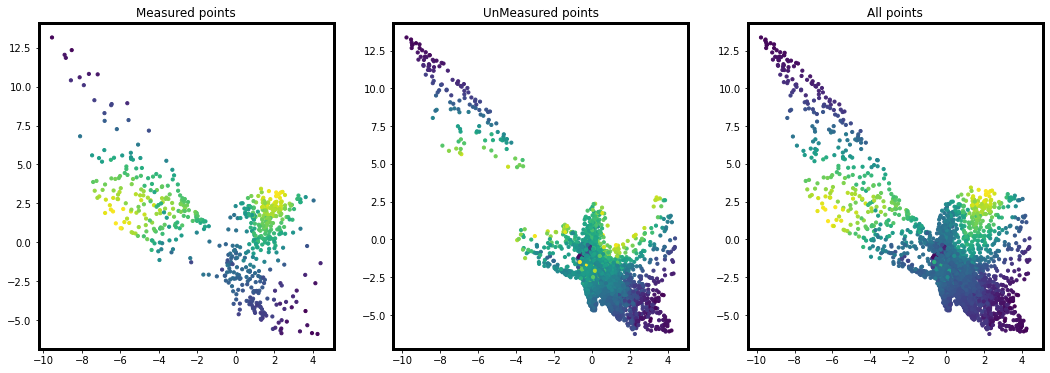

In [12]:
# Visualizing the latent distributions using the ground truths of the target function

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))

ax[0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = y1_train, alpha=1)
ax[0].set_title('Measured points')

ax[1].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10, c = curls_total[indices_unmeasured_1])
ax[1].set_title('UnMeasured points')

ax[2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = curls_total)
ax[2].set_title('All points')

Text(0.5, 1.0, 'Polarization_total')

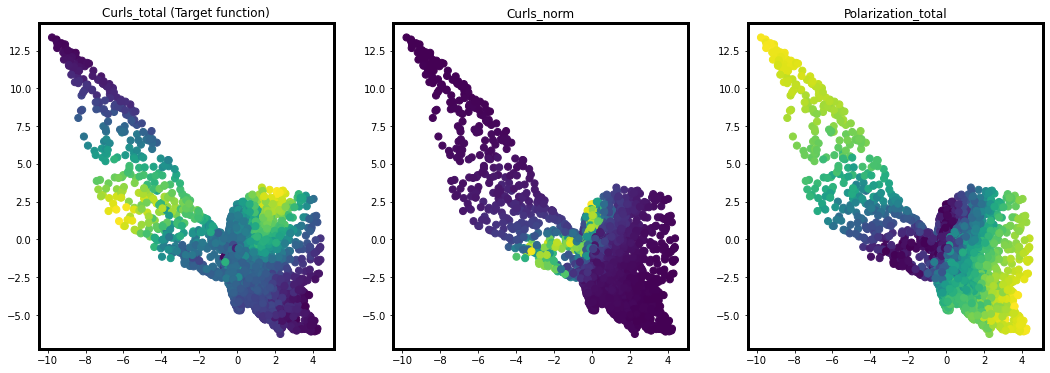

In [20]:
# Visulazing the entire latent distributions using ground-truths other target functions considered for this analysis
# Curl is used in training, but latent distributions of normalized curl and the polarization are also plotted 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].scatter(embeded11[:, 1], embeded11[:, 0], s=50, c = curls_total)
ax[0].set_title('Curls_total (Target function)')

ax[1].scatter(embeded11[:, 1], embeded11[:, 0], s=50, c = curls_norm)
ax[1].set_title('Curls_norm')


ax[2].scatter(embeded11[:, 1], embeded11[:, 0], s=50, c = p_total)
ax[2].set_title('Polarization_total')

## Case-2
Targets: Normalized curl

DO NOT RUN the next cell. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

In [ ]:
# Training the DKL on the whole network
rng_key_2, rng_key_predict_2 = gpax.utils.get_keys()
dkl_2 = gpax.viDKL(900, 2, 'RBF')
dkl_2.fit(rng_key_2, X, curls_norm)

100%|█| 1000/1000 [03:24<00:00,  4.88it/s, init loss: 727568.9520, avg. loss [95


Inferred GP kernel parameters
k_length         [2.3226 1.7587]
k_scale          3.395
noise            2.8301000000000003


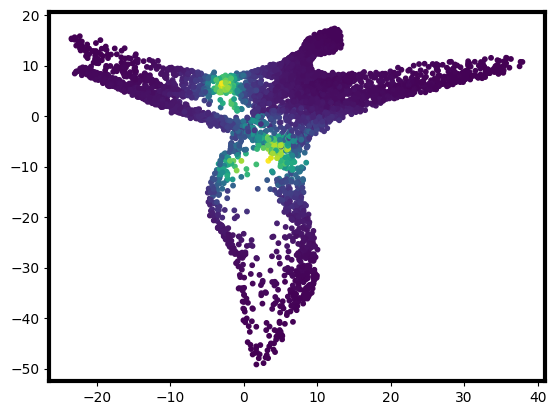

Text(0.5, 1.0, 'Polarization_total')

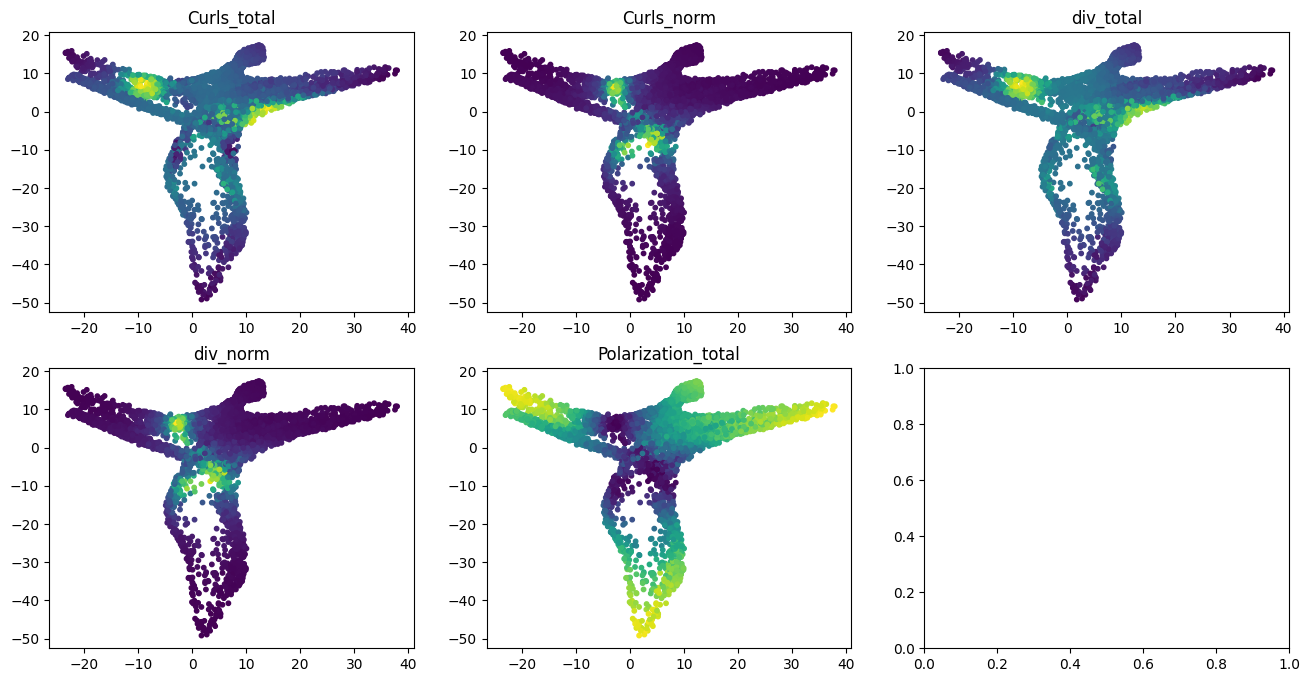

In [ ]:
# Predictions on the entire dataset
y_mean2, y_var2 = dkl_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_2, X, batch_size=250)
embeded_2 = dkl_2.embed(X)   # Latent space embeddings on the entire dataset


# Visualization of latent space distributions in static setting
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,8))
ax[0,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = curls_total)
ax[0,0].set_title('Curls_total')

ax[0,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = curls_norm)
ax[0,1].set_title('Curls_norm')

# ax[0,2].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = div_total)
# ax[0,2].set_title('div_total')

# ax[1,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = div_norm)
# ax[1,0].set_title('div_norm')

ax[1,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = p_total)
ax[1,1].set_title('Polarization_total')

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [15]:
# Picking the initialization points and preparing the dataset for BO

X2 = np.copy(dataset)
np.random.seed(0)
idx2 = np.random.choice(np.arange(len(X2)), size = 100, replace = False)
X2_train = X2[idx2]
X2_unmeasured = np.delete(X2, idx2, axis=0)

indices_total_2 = np.arange(len(dataset))
indices_train_2 = indices_total_2[idx2]
y2_train = curls_norm[idx2]
indices_unmeasured_2 = np.delete(indices_total_2, idx2)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Predictions made using the DKL trained on the whole dataset
y2_mean_full, y2_var_full = dkl_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_2, X2, batch_size=250)

y2_std_full = jnp.sqrt(y2_var_full)


# Running the dkl_BO model with 500 exploration steps
exp_mean2, exp_std2 = [], []
dkl_mean2, dkl_std2 = [], []
embed_traj2 = []
traj_mean2, traj_std2 = [], []


exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key12, rng_key_predict12 = gpax.utils.get_keys()
    dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_2.fit(rng_key12, X2_train, y2_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean2.append(y_mean[id_next])
    exp_std2.append(y_std[id_next])
    
    x_next = X2_unmeasured[id_next]
    ind_next = indices_unmeasured_2[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean2.append(y2_mean_full[ind_next])
    dkl_std2.append(y2_std_full[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = curls_norm[ind_next]
    
    # Update training arrays
    X2_train = np.append(X2_train, x_next[None], axis=0)
    y2_train = np.append(y2_train, y_measured)
    X2_unmeasured = np.delete(X2_unmeasured, id_next, axis=0)
    indices_unmeasured_2 = np.delete(indices_unmeasured_2, id_next)
    
    embed_traj = dkl_BO_2.embed(X2_train)
    traj_m, traj_s = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_train, batch_size=100)
    
    embed_traj2.append(embed_traj)
    traj_mean2.append(traj_m)
    traj_std2.append(traj_s)


# Saving the results
curlsnorm_results = {}
curlsnorm_results['X_train'] = X2_train
curlsnorm_results['y_train'] = y2_train
curlsnorm_results['X_unmeasured'] = X2_unmeasured
curlsnorm_results['indices_unmeasured'] = indices_unmeasured_2
curlsnorm_results['dkl_mean'] = dkl_mean2
curlsnorm_results['dkl_std'] = dkl_std2
curlsnorm_results['exp_mean'] = exp_mean2
curlsnorm_results['exp_std'] = exp_std2
curlsnorm_results['traj_mean'] = traj_mean2
curlsnorm_results['traj_std'] = traj_std2
curlsnorm_results['embed_traj'] = embed_traj2

with open('curlsnorm_results.pickle', 'wb') as handle:
    pickle.dump(curlsnorm_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 380.63it/s, init loss: 75486.8407, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2921 1.7982]
k_scale          8.9407
noise            8.664900000000001

Step 2


100%|█| 1000/1000 [00:02<00:00, 374.54it/s, init loss: 76587.3087, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3847 1.9429]
k_scale          8.841700000000001
noise            9.1072

Step 3


100%|█| 1000/1000 [00:02<00:00, 382.84it/s, init loss: 76605.0618, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8274 1.6441]
k_scale          8.8252
noise            9.640500000000001

Step 4


100%|█| 1000/1000 [00:02<00:00, 386.02it/s, init loss: 78888.6483, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0802 1.5568]
k_scale          7.9125000000000005
noise            11.2856

Step 5


100%|█| 1000/1000 [00:02<00:00, 386.33it/s, init loss: 78932.2062, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8908 1.5894]
k_scale          8.334200000000001
noise            11.3206

Step 6


100%|█| 1000/1000 [00:03<00:00, 315.48it/s, init loss: 78954.4270, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3294 1.7599]
k_scale          9.1357
noise            8.7989

Step 7


100%|█| 1000/1000 [00:02<00:00, 382.21it/s, init loss: 79014.7137, avg. loss [95



Inferred GP kernel parameters
k_length         [2.2813 1.686 ]
k_scale          8.585700000000001
noise            9.8437

Step 8


100%|█| 1000/1000 [00:02<00:00, 385.61it/s, init loss: 79371.8723, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1458 1.3759]
k_scale          8.8861
noise            10.0778

Step 9


100%|█| 1000/1000 [00:02<00:00, 385.10it/s, init loss: 80088.3196, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9976 1.396 ]
k_scale          8.308900000000001
noise            11.374600000000001

Step 10


100%|█| 1000/1000 [00:02<00:00, 386.70it/s, init loss: 80705.0860, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1327 1.6164]
k_scale          8.808900000000001
noise            9.203100000000001

Step 11


100%|█| 1000/1000 [00:02<00:00, 376.08it/s, init loss: 81271.5647, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0274 1.2082]
k_scale          8.2905
noise            12.546100000000001

Step 12


100%|█| 1000/1000 [00:02<00:00, 381.73it/s, init loss: 81608.5591, avg. loss [95



Inferred GP kernel parameters
k_length         [2.4819 2.0838]
k_scale          8.6145
noise            9.6735

Step 13


100%|█| 1000/1000 [00:02<00:00, 383.63it/s, init loss: 82160.8493, avg. loss [95



Inferred GP kernel parameters
k_length         [2.125  1.7532]
k_scale          8.8434
noise            9.8246

Step 14


100%|█| 1000/1000 [00:02<00:00, 385.43it/s, init loss: 83560.2478, avg. loss [95



Inferred GP kernel parameters
k_length         [1.982  1.4471]
k_scale          8.7759
noise            9.4465

Step 15


100%|█| 1000/1000 [00:02<00:00, 382.78it/s, init loss: 83632.6207, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0376 1.5271]
k_scale          9.337900000000001
noise            8.8031

Step 16


100%|█| 1000/1000 [00:02<00:00, 379.36it/s, init loss: 83645.9529, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9679 1.32  ]
k_scale          8.7051
noise            10.6804

Step 17


100%|█| 1000/1000 [00:02<00:00, 380.84it/s, init loss: 84111.6505, avg. loss [95



Inferred GP kernel parameters
k_length         [2.1621 1.3454]
k_scale          8.8116
noise            9.7604

Step 18


100%|█| 1000/1000 [00:02<00:00, 385.49it/s, init loss: 87303.8980, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9198 1.4036]
k_scale          8.4221
noise            10.5602

Step 19


100%|█| 1000/1000 [00:02<00:00, 386.42it/s, init loss: 87544.7011, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7465 1.2877]
k_scale          8.601700000000001
noise            11.0652

Step 20


100%|█| 1000/1000 [00:03<00:00, 316.04it/s, init loss: 87869.5366, avg. loss [95



Inferred GP kernel parameters
k_length         [2.3151 1.4901]
k_scale          8.6348
noise            8.972800000000001

Step 21


100%|█| 1000/1000 [00:02<00:00, 383.09it/s, init loss: 88078.7799, avg. loss [95



Inferred GP kernel parameters
k_length         [1.796  1.1794]
k_scale          8.6532
noise            10.777000000000001

Step 22


100%|█| 1000/1000 [00:02<00:00, 388.01it/s, init loss: 88356.7685, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9094 1.4287]
k_scale          8.7826
noise            7.7316

Step 23


100%|█| 1000/1000 [00:02<00:00, 388.90it/s, init loss: 88358.1942, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7179 1.123 ]
k_scale          8.8054
noise            10.8984

Step 24


100%|█| 1000/1000 [00:02<00:00, 388.99it/s, init loss: 88815.0330, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7223 1.2043]
k_scale          8.3596
noise            10.2386

Step 25


100%|█| 1000/1000 [00:02<00:00, 380.04it/s, init loss: 89709.5081, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6545 1.3818]
k_scale          7.9733
noise            9.406500000000001

Step 26


100%|█| 1000/1000 [00:02<00:00, 382.95it/s, init loss: 89744.3191, avg. loss [95



Inferred GP kernel parameters
k_length         [1.688  1.1659]
k_scale          8.351600000000001
noise            10.9344

Step 27


100%|█| 1000/1000 [00:02<00:00, 385.84it/s, init loss: 90166.8321, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8022 1.3199]
k_scale          7.9218
noise            6.713900000000001

Step 28


100%|█| 1000/1000 [00:02<00:00, 387.29it/s, init loss: 92668.5097, avg. loss [95



Inferred GP kernel parameters
k_length         [1.9945 1.4993]
k_scale          8.113900000000001
noise            10.0446

Step 29


100%|█| 1000/1000 [00:03<00:00, 314.94it/s, init loss: 92670.4908, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8394 1.4199]
k_scale          7.4179
noise            7.4408

Step 30


100%|█| 1000/1000 [00:02<00:00, 371.46it/s, init loss: 92671.9191, avg. loss [95



Inferred GP kernel parameters
k_length         [1.6874 1.1901]
k_scale          8.980500000000001
noise            8.9453

Step 31


100%|█| 1000/1000 [00:02<00:00, 381.53it/s, init loss: 95001.0004, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7365 1.162 ]
k_scale          7.8601
noise            7.0711

Step 32


100%|█| 1000/1000 [00:02<00:00, 381.90it/s, init loss: 96215.6207, avg. loss [95



Inferred GP kernel parameters
k_length         [1.7627 1.391 ]
k_scale          8.879
noise            5.9214

Step 33


100%|█| 1000/1000 [00:02<00:00, 381.43it/s, init loss: 96945.2456, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0935 1.3487]
k_scale          9.0289
noise            7.9983

Step 34


100%|█| 1000/1000 [00:02<00:00, 374.79it/s, init loss: 97382.0395, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8653 1.3396]
k_scale          7.049600000000001
noise            5.5373

Step 35


100%|█| 1000/1000 [00:02<00:00, 375.56it/s, init loss: 97410.4610, avg. loss [95



Inferred GP kernel parameters
k_length         [2.0854 1.3948]
k_scale          7.0278
noise            6.1831000000000005

Step 36


100%|█| 1000/1000 [00:02<00:00, 374.16it/s, init loss: 98615.4279, avg. loss [95



Inferred GP kernel parameters
k_length         [1.8201 1.3077]
k_scale          7.514600000000001
noise            5.2933

Step 37


100%|█| 1000/1000 [00:02<00:00, 378.80it/s, init loss: 100503.0877, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6919 1.2269]
k_scale          8.649000000000001
noise            7.4675

Step 38


100%|█| 1000/1000 [00:02<00:00, 373.30it/s, init loss: 101592.2713, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8283 1.4216]
k_scale          6.4314
noise            5.071400000000001

Step 39


100%|█| 1000/1000 [00:02<00:00, 377.02it/s, init loss: 103996.9298, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8125 1.3635]
k_scale          6.9402
noise            5.806500000000001

Step 40


100%|█| 1000/1000 [00:02<00:00, 378.14it/s, init loss: 105437.9115, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0753 1.3741]
k_scale          6.602200000000001
noise            5.051

Step 41


100%|█| 1000/1000 [00:02<00:00, 382.15it/s, init loss: 107231.0016, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8979 1.3145]
k_scale          6.170800000000001
noise            4.9656

Step 42


100%|█| 1000/1000 [00:02<00:00, 383.49it/s, init loss: 108537.9830, avg. loss [9



Inferred GP kernel parameters
k_length         [2.3999 1.7581]
k_scale          7.770300000000001
noise            6.2971

Step 43


100%|█| 1000/1000 [00:02<00:00, 374.94it/s, init loss: 109306.8967, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7537 1.2166]
k_scale          6.7766
noise            4.532

Step 44


100%|█| 1000/1000 [00:02<00:00, 378.62it/s, init loss: 111468.8608, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6225 1.1585]
k_scale          6.1368
noise            5.771

Step 45


100%|█| 1000/1000 [00:02<00:00, 381.04it/s, init loss: 112219.6866, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7969 1.1701]
k_scale          5.983300000000001
noise            4.2702

Step 46


100%|█| 1000/1000 [00:02<00:00, 378.17it/s, init loss: 113716.6137, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6086 1.1088]
k_scale          6.6023000000000005
noise            5.5532

Step 47


100%|█| 1000/1000 [00:03<00:00, 308.52it/s, init loss: 115066.9196, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6726 1.213 ]
k_scale          6.6644000000000005
noise            5.3077000000000005

Step 48


100%|█| 1000/1000 [00:02<00:00, 370.09it/s, init loss: 115622.8880, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6541 1.0975]
k_scale          6.2209
noise            5.5811

Step 49


100%|█| 1000/1000 [00:02<00:00, 374.92it/s, init loss: 116535.7517, avg. loss [9



Inferred GP kernel parameters
k_length         [1.523  1.0701]
k_scale          6.356800000000001
noise            4.621300000000001

Step 50


100%|█| 1000/1000 [00:02<00:00, 376.43it/s, init loss: 118254.4790, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6421 1.1459]
k_scale          6.210500000000001
noise            4.2487

Step 51


100%|█| 1000/1000 [00:02<00:00, 377.75it/s, init loss: 120293.5106, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6061 1.1326]
k_scale          5.9957
noise            4.1436

Step 52


100%|█| 1000/1000 [00:02<00:00, 366.32it/s, init loss: 120356.3946, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6188 1.1144]
k_scale          5.9196
noise            4.5509

Step 53


100%|█| 1000/1000 [00:02<00:00, 371.63it/s, init loss: 120634.3735, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5521 1.0877]
k_scale          6.3905
noise            4.9646

Step 54


100%|█| 1000/1000 [00:02<00:00, 376.27it/s, init loss: 120644.7897, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6651 1.2177]
k_scale          6.713900000000001
noise            4.7991

Step 55


100%|█| 1000/1000 [00:02<00:00, 375.07it/s, init loss: 121864.5170, avg. loss [9



Inferred GP kernel parameters
k_length         [1.4861 1.0287]
k_scale          6.468
noise            5.6822

Step 56


100%|█| 1000/1000 [00:03<00:00, 323.91it/s, init loss: 122596.4706, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6945 1.1332]
k_scale          5.983700000000001
noise            5.4527

Step 57


100%|█| 1000/1000 [00:02<00:00, 367.35it/s, init loss: 123152.8029, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6495 1.2062]
k_scale          5.6423000000000005
noise            4.404

Step 58


100%|█| 1000/1000 [00:02<00:00, 374.04it/s, init loss: 124380.4078, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6732 1.0905]
k_scale          5.5515
noise            4.76

Step 59


100%|█| 1000/1000 [00:02<00:00, 374.09it/s, init loss: 125028.9131, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5998 1.1602]
k_scale          5.6191
noise            5.1336

Step 60


100%|█| 1000/1000 [00:02<00:00, 375.43it/s, init loss: 127289.1708, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6718 1.1611]
k_scale          5.4918000000000005
noise            4.5253000000000005

Step 61


100%|█| 1000/1000 [00:03<00:00, 321.40it/s, init loss: 127294.5680, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5716 1.0739]
k_scale          6.3121
noise            4.9

Step 62


100%|█| 1000/1000 [00:02<00:00, 366.04it/s, init loss: 127568.8227, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5753 1.0408]
k_scale          5.9789
noise            5.7496

Step 63


100%|█| 1000/1000 [00:02<00:00, 369.89it/s, init loss: 127584.5077, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6042 1.1183]
k_scale          5.6353
noise            4.6383

Step 64


100%|█| 1000/1000 [00:02<00:00, 371.03it/s, init loss: 130274.8994, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5641 1.0399]
k_scale          5.4771
noise            5.1926000000000005

Step 65


100%|█| 1000/1000 [00:02<00:00, 373.41it/s, init loss: 131001.1686, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6264 1.1268]
k_scale          5.766900000000001
noise            5.1459

Step 66


100%|█| 1000/1000 [00:02<00:00, 362.33it/s, init loss: 132732.0414, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7117 1.1135]
k_scale          4.9692
noise            4.3474

Step 67


100%|█| 1000/1000 [00:02<00:00, 367.19it/s, init loss: 133332.2589, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6087 1.181 ]
k_scale          5.018000000000001
noise            4.4621

Step 68


100%|█| 1000/1000 [00:02<00:00, 368.53it/s, init loss: 133334.6183, avg. loss [9



Inferred GP kernel parameters
k_length         [1.663  1.2513]
k_scale          5.376
noise            4.324

Step 69


100%|█| 1000/1000 [00:02<00:00, 372.61it/s, init loss: 133908.1695, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7083 1.2302]
k_scale          4.5513
noise            4.446000000000001

Step 70


100%|█| 1000/1000 [00:03<00:00, 319.39it/s, init loss: 133918.8687, avg. loss [9



Inferred GP kernel parameters
k_length         [1.508  1.1104]
k_scale          5.0263
noise            4.4473

Step 71


100%|█| 1000/1000 [00:02<00:00, 363.58it/s, init loss: 134865.9317, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5263 1.0325]
k_scale          5.352600000000001
noise            4.0904

Step 72


100%|█| 1000/1000 [00:02<00:00, 370.37it/s, init loss: 135518.8797, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7114 1.1534]
k_scale          4.7606
noise            4.3836

Step 73


100%|█| 1000/1000 [00:02<00:00, 371.97it/s, init loss: 135527.3119, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8314 1.1783]
k_scale          4.6849
noise            4.2714

Step 74


100%|█| 1000/1000 [00:02<00:00, 374.61it/s, init loss: 136128.5004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6487 1.1459]
k_scale          4.7058
noise            4.750500000000001

Step 75


100%|█| 1000/1000 [00:03<00:00, 315.66it/s, init loss: 136630.0357, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5839 1.0302]
k_scale          5.0326
noise            3.8394000000000004

Step 76


100%|█| 1000/1000 [00:02<00:00, 364.46it/s, init loss: 136851.8126, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7763 1.1432]
k_scale          4.947
noise            4.0898

Step 77


100%|█| 1000/1000 [00:02<00:00, 368.95it/s, init loss: 137376.8784, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6515 1.0918]
k_scale          5.0864
noise            3.7997

Step 78


100%|█| 1000/1000 [00:02<00:00, 371.34it/s, init loss: 139068.5272, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5972 1.0261]
k_scale          5.0643
noise            3.8651

Step 79


100%|█| 1000/1000 [00:02<00:00, 371.30it/s, init loss: 139516.5380, avg. loss [9



Inferred GP kernel parameters
k_length         [1.595  1.1255]
k_scale          5.1916
noise            4.2231000000000005

Step 80


100%|█| 1000/1000 [00:02<00:00, 359.33it/s, init loss: 140784.5242, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5466 1.0669]
k_scale          5.1160000000000005
noise            4.6276

Step 81


100%|█| 1000/1000 [00:02<00:00, 365.53it/s, init loss: 141072.9514, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6273 1.1144]
k_scale          4.656000000000001
noise            4.4131

Step 82


100%|█| 1000/1000 [00:02<00:00, 368.36it/s, init loss: 141167.3931, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7461 1.2088]
k_scale          4.6288
noise            3.7591

Step 83


100%|█| 1000/1000 [00:02<00:00, 370.79it/s, init loss: 141173.7139, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6614 1.1463]
k_scale          4.6406
noise            4.3286

Step 84


100%|█| 1000/1000 [00:03<00:00, 316.81it/s, init loss: 143359.9044, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6765 1.0943]
k_scale          5.0433
noise            3.6785

Step 85


100%|█| 1000/1000 [00:02<00:00, 365.76it/s, init loss: 143938.9341, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7343 1.1442]
k_scale          4.8715
noise            3.7319

Step 86


100%|█| 1000/1000 [00:02<00:00, 369.10it/s, init loss: 144056.1658, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6137 1.0311]
k_scale          4.7779
noise            3.9297

Step 87


100%|█| 1000/1000 [00:02<00:00, 372.20it/s, init loss: 144109.9270, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8788 1.1165]
k_scale          4.4299
noise            3.6413

Step 88


100%|█| 1000/1000 [00:02<00:00, 373.52it/s, init loss: 145029.7191, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6603 1.0694]
k_scale          4.675400000000001
noise            3.4918

Step 89


100%|█| 1000/1000 [00:02<00:00, 357.34it/s, init loss: 145076.3492, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5624 1.0481]
k_scale          4.7327
noise            4.3632

Step 90


100%|█| 1000/1000 [00:02<00:00, 364.40it/s, init loss: 145250.5919, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6398 1.0848]
k_scale          4.7686
noise            3.5829

Step 91


100%|█| 1000/1000 [00:02<00:00, 370.56it/s, init loss: 145335.0530, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6953 1.173 ]
k_scale          4.4936
noise            4.1108

Step 92


100%|█| 1000/1000 [00:02<00:00, 370.87it/s, init loss: 147797.8792, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7166 1.139 ]
k_scale          4.477
noise            3.4923

Step 93


100%|█| 1000/1000 [00:03<00:00, 314.74it/s, init loss: 147856.4398, avg. loss [9



Inferred GP kernel parameters
k_length         [1.59 1.16]
k_scale          4.9073
noise            3.7950000000000004

Step 94


100%|█| 1000/1000 [00:02<00:00, 358.94it/s, init loss: 148917.1519, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6491 1.132 ]
k_scale          4.802700000000001
noise            3.6436

Step 95


100%|█| 1000/1000 [00:02<00:00, 366.00it/s, init loss: 148919.1868, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6911 1.1296]
k_scale          4.6907000000000005
noise            3.8836000000000004

Step 96


100%|█| 1000/1000 [00:02<00:00, 360.90it/s, init loss: 149233.2333, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6686 1.1904]
k_scale          4.4539
noise            3.5879000000000003

Step 97


100%|█| 1000/1000 [00:02<00:00, 364.73it/s, init loss: 149237.9247, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6623 1.1354]
k_scale          4.4522
noise            3.5396

Step 98


100%|█| 1000/1000 [00:03<00:00, 265.62it/s, init loss: 149242.1806, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6158 1.0698]
k_scale          4.765000000000001
noise            3.7951

Step 99


100%|█| 1000/1000 [00:02<00:00, 353.94it/s, init loss: 149262.5062, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6312 1.0993]
k_scale          4.8594
noise            3.9291

Step 100


100%|█| 1000/1000 [00:02<00:00, 355.89it/s, init loss: 151741.1018, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5433 1.0584]
k_scale          4.9364
noise            4.5812

Step 101


100%|█| 1000/1000 [00:02<00:00, 360.68it/s, init loss: 151937.6956, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6201 1.0857]
k_scale          4.7351
noise            5.1665

Step 102


100%|█| 1000/1000 [00:02<00:00, 362.15it/s, init loss: 152774.8347, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5625 1.1088]
k_scale          4.9157
noise            4.8542000000000005

Step 103


100%|█| 1000/1000 [00:02<00:00, 347.53it/s, init loss: 152885.1390, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6963 1.1355]
k_scale          4.722300000000001
noise            4.4616

Step 104


100%|█| 1000/1000 [00:02<00:00, 352.52it/s, init loss: 153039.5988, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6025 1.1157]
k_scale          5.0702
noise            3.6214

Step 105


100%|█| 1000/1000 [00:02<00:00, 355.67it/s, init loss: 154272.2551, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8119 1.0901]
k_scale          4.6351
noise            4.6113

Step 106


100%|█| 1000/1000 [00:02<00:00, 357.67it/s, init loss: 154947.8913, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7244 1.2538]
k_scale          4.4994000000000005
noise            4.1328000000000005

Step 107


100%|█| 1000/1000 [00:02<00:00, 360.92it/s, init loss: 155191.7830, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6551 1.1634]
k_scale          4.2633
noise            5.4423

Step 108


100%|█| 1000/1000 [00:02<00:00, 352.01it/s, init loss: 155206.2020, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7295 1.2224]
k_scale          4.189900000000001
noise            4.349

Step 109


100%|█| 1000/1000 [00:02<00:00, 353.63it/s, init loss: 157316.9879, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6927 1.1454]
k_scale          4.643400000000001
noise            4.7438

Step 110


100%|█| 1000/1000 [00:02<00:00, 356.62it/s, init loss: 157319.4053, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8402 1.3256]
k_scale          5.2437000000000005
noise            4.6277

Step 111


100%|█| 1000/1000 [00:02<00:00, 359.01it/s, init loss: 158998.1769, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7188 1.1381]
k_scale          4.966
noise            4.3695

Step 112


100%|█| 1000/1000 [00:03<00:00, 271.71it/s, init loss: 160364.2020, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7137 1.1203]
k_scale          4.899500000000001
noise            4.9481

Step 113


100%|█| 1000/1000 [00:02<00:00, 350.66it/s, init loss: 162634.2548, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5394 1.0649]
k_scale          5.1687
noise            4.8724

Step 114


100%|█| 1000/1000 [00:02<00:00, 355.65it/s, init loss: 164124.6863, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6225 1.0924]
k_scale          5.1588
noise            4.7171

Step 115


100%|█| 1000/1000 [00:02<00:00, 356.72it/s, init loss: 164236.3170, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6259 1.1095]
k_scale          5.0659
noise            4.4584

Step 116


100%|█| 1000/1000 [00:02<00:00, 352.72it/s, init loss: 164332.7685, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6368 1.0818]
k_scale          4.6588
noise            4.5396

Step 117


100%|█| 1000/1000 [00:02<00:00, 338.17it/s, init loss: 164451.3928, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6639 1.1118]
k_scale          4.8619
noise            4.4219

Step 118


100%|█| 1000/1000 [00:02<00:00, 344.90it/s, init loss: 164453.2425, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6658 1.1565]
k_scale          4.6766000000000005
noise            4.5637

Step 119


100%|█| 1000/1000 [00:02<00:00, 348.18it/s, init loss: 164962.0729, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5394 1.0414]
k_scale          4.790900000000001
noise            5.0149

Step 120


100%|█| 1000/1000 [00:02<00:00, 351.91it/s, init loss: 165629.3437, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6192 1.0742]
k_scale          4.9771
noise            5.0726

Step 121


100%|█| 1000/1000 [00:03<00:00, 263.15it/s, init loss: 165680.9573, avg. loss [9



Inferred GP kernel parameters
k_length         [1.65   1.1225]
k_scale          4.671600000000001
noise            4.316

Step 122


100%|█| 1000/1000 [00:02<00:00, 345.57it/s, init loss: 166046.1513, avg. loss [9



Inferred GP kernel parameters
k_length         [1.5853 1.1153]
k_scale          4.7018
noise            4.347700000000001

Step 123


100%|█| 1000/1000 [00:02<00:00, 347.25it/s, init loss: 166048.5078, avg. loss [9



Inferred GP kernel parameters
k_length         [1.599  1.0636]
k_scale          4.643400000000001
noise            4.5157

Step 124


100%|█| 1000/1000 [00:02<00:00, 369.43it/s, init loss: 166151.0180, avg. loss [9



Inferred GP kernel parameters
k_length         [1.748  1.0538]
k_scale          4.5659
noise            4.7968

Step 125


100%|█| 1000/1000 [00:02<00:00, 363.15it/s, init loss: 167200.0796, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6047 1.0468]
k_scale          4.8276
noise            4.595000000000001

Step 126


100%|█| 1000/1000 [00:03<00:00, 275.61it/s, init loss: 167297.6925, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7298 1.1542]
k_scale          4.4903
noise            4.815

Step 127


100%|█| 1000/1000 [00:02<00:00, 348.65it/s, init loss: 167320.5312, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9748 1.273 ]
k_scale          3.9028
noise            4.2089

Step 128


100%|█| 1000/1000 [00:02<00:00, 355.23it/s, init loss: 167327.4936, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6307 1.0892]
k_scale          4.992900000000001
noise            4.5248

Step 129


100%|█| 1000/1000 [00:02<00:00, 355.55it/s, init loss: 167900.9886, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7425 1.1294]
k_scale          4.4646
noise            5.2142

Step 130


100%|█| 1000/1000 [00:02<00:00, 359.07it/s, init loss: 168224.2884, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8655 1.2932]
k_scale          3.986
noise            4.0407

Step 131


100%|█| 1000/1000 [00:02<00:00, 343.20it/s, init loss: 169695.8320, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6892 1.1174]
k_scale          4.9688
noise            4.8231

Step 132


100%|█| 1000/1000 [00:02<00:00, 349.95it/s, init loss: 169700.2165, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8263 1.196 ]
k_scale          4.0632
noise            4.2713

Step 133


100%|█| 1000/1000 [00:02<00:00, 353.63it/s, init loss: 170146.4822, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6524 1.0883]
k_scale          4.9232000000000005
noise            4.9985

Step 134


100%|█| 1000/1000 [00:02<00:00, 355.73it/s, init loss: 170155.8527, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8448 1.1601]
k_scale          4.9349
noise            4.5811

Step 135


100%|█| 1000/1000 [00:03<00:00, 275.69it/s, init loss: 170246.6813, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7729 1.1099]
k_scale          4.9813
noise            4.5762

Step 136


100%|█| 1000/1000 [00:02<00:00, 348.35it/s, init loss: 170250.0125, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8227 1.2404]
k_scale          4.4015
noise            3.5979

Step 137


100%|█| 1000/1000 [00:02<00:00, 350.75it/s, init loss: 170284.0040, avg. loss [9



Inferred GP kernel parameters
k_length         [1.732  1.2084]
k_scale          4.7598
noise            4.466200000000001

Step 138


100%|█| 1000/1000 [00:02<00:00, 353.44it/s, init loss: 170927.9760, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6594 1.1419]
k_scale          5.0383000000000004
noise            5.4589

Step 139


100%|█| 1000/1000 [00:02<00:00, 358.53it/s, init loss: 172299.6615, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7776 1.226 ]
k_scale          4.3131
noise            4.2954

Step 140


100%|█| 1000/1000 [00:03<00:00, 273.95it/s, init loss: 175619.2309, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8258 1.2566]
k_scale          5.115600000000001
noise            4.8782000000000005

Step 141


100%|█| 1000/1000 [00:02<00:00, 350.81it/s, init loss: 175772.9890, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8276 1.2257]
k_scale          3.8961
noise            4.0006

Step 142


100%|█| 1000/1000 [00:02<00:00, 351.98it/s, init loss: 176145.6114, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9412 1.2861]
k_scale          4.3923000000000005
noise            3.7629

Step 143


100%|█| 1000/1000 [00:02<00:00, 354.61it/s, init loss: 177905.8455, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6222 1.1839]
k_scale          4.7532000000000005
noise            4.3708

Step 144


100%|█| 1000/1000 [00:02<00:00, 356.69it/s, init loss: 178231.4106, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7865 1.2391]
k_scale          4.9713
noise            4.6306

Step 145


100%|█| 1000/1000 [00:02<00:00, 346.15it/s, init loss: 178405.0414, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8521 1.1655]
k_scale          5.1526000000000005
noise            4.1079

Step 146


100%|█| 1000/1000 [00:02<00:00, 347.01it/s, init loss: 178532.0071, avg. loss [9



Inferred GP kernel parameters
k_length         [1.857  1.2792]
k_scale          4.2865
noise            3.4031000000000002

Step 147


100%|█| 1000/1000 [00:02<00:00, 353.84it/s, init loss: 179591.7242, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7496 1.3064]
k_scale          4.6879
noise            3.8557

Step 148


100%|█| 1000/1000 [00:02<00:00, 356.22it/s, init loss: 180283.6656, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1446 1.431 ]
k_scale          5.328600000000001
noise            4.3361

Step 149


100%|█| 1000/1000 [00:03<00:00, 262.17it/s, init loss: 180868.4256, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8417 1.1823]
k_scale          4.3728
noise            3.7155

Step 150


100%|█| 1000/1000 [00:02<00:00, 348.58it/s, init loss: 180885.0516, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7107 1.2292]
k_scale          5.068700000000001
noise            4.228400000000001

Step 151


100%|█| 1000/1000 [00:02<00:00, 352.72it/s, init loss: 182868.6820, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8467 1.1684]
k_scale          4.6532
noise            3.1763000000000003

Step 152


100%|█| 1000/1000 [00:02<00:00, 356.11it/s, init loss: 183496.6507, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7832 1.2482]
k_scale          4.7462
noise            3.2198

Step 153


100%|█| 1000/1000 [00:02<00:00, 358.28it/s, init loss: 184768.4917, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1217 1.3005]
k_scale          3.2855000000000003
noise            3.4675000000000002

Step 154


100%|█| 1000/1000 [00:02<00:00, 340.76it/s, init loss: 187388.5294, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7659 1.1986]
k_scale          4.7569
noise            3.4125

Step 155


100%|█| 1000/1000 [00:02<00:00, 349.14it/s, init loss: 188937.3873, avg. loss [9



Inferred GP kernel parameters
k_length         [1.756  1.2753]
k_scale          5.0265
noise            3.8053000000000003

Step 156


100%|█| 1000/1000 [00:02<00:00, 349.25it/s, init loss: 189267.1394, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7343 1.1574]
k_scale          4.7582
noise            3.689

Step 157


100%|█| 1000/1000 [00:02<00:00, 352.72it/s, init loss: 190572.0752, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7446 1.3053]
k_scale          4.4575000000000005
noise            3.1287000000000003

Step 158


100%|█| 1000/1000 [00:02<00:00, 351.24it/s, init loss: 190603.7844, avg. loss [9



Inferred GP kernel parameters
k_length         [1.921  1.3637]
k_scale          3.0529
noise            2.7904

Step 159


100%|█| 1000/1000 [00:02<00:00, 339.27it/s, init loss: 190676.3335, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6571 1.1273]
k_scale          5.2449
noise            3.185

Step 160


100%|█| 1000/1000 [00:02<00:00, 354.15it/s, init loss: 190695.5749, avg. loss [9



Inferred GP kernel parameters
k_length         [1.752 1.21 ]
k_scale          4.5784
noise            3.0684

Step 161


100%|█| 1000/1000 [00:02<00:00, 352.96it/s, init loss: 191682.7881, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8638 1.1855]
k_scale          5.0034
noise            3.8717

Step 162


100%|█| 1000/1000 [00:02<00:00, 359.72it/s, init loss: 192136.5321, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8129 1.2301]
k_scale          5.1338
noise            4.2343

Step 163


100%|█| 1000/1000 [00:03<00:00, 308.77it/s, init loss: 192430.3165, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8734 1.3315]
k_scale          3.8554000000000004
noise            3.4684000000000004

Step 164


100%|█| 1000/1000 [00:02<00:00, 352.45it/s, init loss: 194192.1229, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8893 1.2767]
k_scale          4.3331
noise            3.5282

Step 165


100%|█| 1000/1000 [00:02<00:00, 355.12it/s, init loss: 194510.1799, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0744 1.3806]
k_scale          3.1434
noise            3.2908

Step 166


100%|█| 1000/1000 [00:02<00:00, 359.22it/s, init loss: 195792.8856, avg. loss [9



Inferred GP kernel parameters
k_length         [1.956  1.2703]
k_scale          4.4386
noise            3.5665

Step 167


100%|█| 1000/1000 [00:02<00:00, 359.75it/s, init loss: 196515.1780, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8854 1.2089]
k_scale          4.489
noise            3.3347

Step 168


100%|█| 1000/1000 [00:02<00:00, 349.87it/s, init loss: 198526.5880, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8481 1.3625]
k_scale          5.0899
noise            3.9315

Step 169


100%|█| 1000/1000 [00:02<00:00, 354.35it/s, init loss: 198641.6307, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0206 1.3534]
k_scale          4.5063
noise            3.4975

Step 170


100%|█| 1000/1000 [00:02<00:00, 359.53it/s, init loss: 198928.7738, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8652 1.3016]
k_scale          4.3757
noise            3.5618000000000003

Step 171


100%|█| 1000/1000 [00:02<00:00, 361.13it/s, init loss: 200177.8286, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7623 1.2321]
k_scale          4.6854000000000005
noise            3.0698000000000003

Step 172


100%|█| 1000/1000 [00:03<00:00, 293.02it/s, init loss: 201395.0829, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7937 1.2628]
k_scale          5.520700000000001
noise            3.8303000000000003

Step 173


100%|█| 1000/1000 [00:02<00:00, 352.24it/s, init loss: 201423.5452, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7039 1.1594]
k_scale          4.5643
noise            3.2382

Step 174


100%|█| 1000/1000 [00:02<00:00, 356.63it/s, init loss: 201446.6107, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7918 1.3602]
k_scale          4.6039
noise            3.249

Step 175


100%|█| 1000/1000 [00:02<00:00, 361.13it/s, init loss: 201452.1905, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6677 1.2216]
k_scale          4.9965
noise            3.6254

Step 176


100%|█| 1000/1000 [00:02<00:00, 361.85it/s, init loss: 201542.1702, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1667 1.4831]
k_scale          2.89
noise            3.196

Step 177


100%|█| 1000/1000 [00:02<00:00, 346.66it/s, init loss: 201546.6068, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8088 1.2135]
k_scale          5.0561
noise            3.6641000000000004

Step 178


100%|█| 1000/1000 [00:02<00:00, 352.88it/s, init loss: 201638.3536, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7975 1.3103]
k_scale          4.5443
noise            3.1757

Step 179


100%|█| 1000/1000 [00:02<00:00, 357.13it/s, init loss: 201740.3272, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8698 1.3429]
k_scale          4.6732000000000005
noise            3.9497

Step 180


100%|█| 1000/1000 [00:02<00:00, 357.72it/s, init loss: 202530.2902, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8709 1.2463]
k_scale          3.9422
noise            2.942

Step 181


100%|█| 1000/1000 [00:03<00:00, 291.97it/s, init loss: 203053.8113, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8745 1.2845]
k_scale          5.005
noise            3.6826000000000003

Step 182


100%|█| 1000/1000 [00:02<00:00, 354.29it/s, init loss: 203056.7268, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9186 1.274 ]
k_scale          4.813000000000001
noise            3.5238

Step 183


100%|█| 1000/1000 [00:02<00:00, 358.41it/s, init loss: 203060.1996, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6899 1.2408]
k_scale          4.7259
noise            3.1335

Step 184


100%|█| 1000/1000 [00:02<00:00, 359.83it/s, init loss: 203061.3811, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6995 1.1543]
k_scale          5.175400000000001
noise            3.2198

Step 185


100%|█| 1000/1000 [00:02<00:00, 358.21it/s, init loss: 203159.6126, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8669 1.2691]
k_scale          4.1451
noise            3.1702000000000004

Step 186


100%|█| 1000/1000 [00:02<00:00, 345.48it/s, init loss: 203199.0456, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9198 1.2564]
k_scale          4.7195
noise            3.6518

Step 187


100%|█| 1000/1000 [00:02<00:00, 350.49it/s, init loss: 203251.5771, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8694 1.4078]
k_scale          4.415500000000001
noise            3.3465000000000003

Step 188


100%|█| 1000/1000 [00:02<00:00, 355.25it/s, init loss: 203655.3557, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7311 1.2103]
k_scale          4.4795
noise            3.1721000000000004

Step 189


100%|█| 1000/1000 [00:02<00:00, 356.68it/s, init loss: 204049.9547, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8477 1.2699]
k_scale          4.5076
noise            3.204

Step 190


100%|█| 1000/1000 [00:02<00:00, 358.10it/s, init loss: 204051.8400, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0312 1.3792]
k_scale          4.1229000000000005
noise            3.3076000000000003

Step 191


100%|█| 1000/1000 [00:02<00:00, 346.37it/s, init loss: 206724.5089, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8788 1.2943]
k_scale          4.3472
noise            3.3459000000000003

Step 192


100%|█| 1000/1000 [00:02<00:00, 352.92it/s, init loss: 206740.0363, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8366 1.2612]
k_scale          4.936100000000001
noise            3.2590000000000003

Step 193


100%|█| 1000/1000 [00:02<00:00, 352.76it/s, init loss: 206742.1617, avg. loss [9



Inferred GP kernel parameters
k_length         [1.857  1.2472]
k_scale          4.6244000000000005
noise            2.906

Step 194


100%|█| 1000/1000 [00:02<00:00, 355.92it/s, init loss: 208071.5857, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6821 1.1621]
k_scale          4.7134
noise            2.9508

Step 195


100%|█| 1000/1000 [00:03<00:00, 291.00it/s, init loss: 208310.4435, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7125 1.1487]
k_scale          5.2652
noise            3.1347

Step 196


100%|█| 1000/1000 [00:02<00:00, 350.74it/s, init loss: 208318.9305, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7737 1.2616]
k_scale          4.7747
noise            3.2288

Step 197


100%|█| 1000/1000 [00:02<00:00, 348.77it/s, init loss: 209290.0545, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8988 1.2382]
k_scale          4.5867
noise            3.5645000000000002

Step 198


100%|█| 1000/1000 [00:02<00:00, 348.39it/s, init loss: 209368.5440, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8335 1.2727]
k_scale          4.3017
noise            3.2470000000000003

Step 199


100%|█| 1000/1000 [00:02<00:00, 347.98it/s, init loss: 209412.8936, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7843 1.2402]
k_scale          4.982
noise            3.5885000000000002

Step 200


100%|█| 1000/1000 [00:03<00:00, 256.87it/s, init loss: 211339.3525, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8182 1.2054]
k_scale          4.6464
noise            3.2817000000000003

Step 201


100%|█| 1000/1000 [00:02<00:00, 337.69it/s, init loss: 211809.7594, avg. loss [9



Inferred GP kernel parameters
k_length         [2.01   1.4421]
k_scale          3.2672000000000003
noise            3.5123

Step 202


100%|█| 1000/1000 [00:02<00:00, 344.44it/s, init loss: 212158.4543, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8859 1.3727]
k_scale          4.1399
noise            2.8674

Step 203


100%|█| 1000/1000 [00:02<00:00, 346.69it/s, init loss: 213132.1491, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8008 1.2937]
k_scale          5.3414
noise            3.822

Step 204


100%|█| 1000/1000 [00:02<00:00, 349.54it/s, init loss: 215031.4376, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6294 1.1541]
k_scale          5.149500000000001
noise            3.1091

Step 205


100%|█| 1000/1000 [00:02<00:00, 334.96it/s, init loss: 216190.8362, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7494 1.1438]
k_scale          5.2321
noise            2.7434000000000003

Step 206


100%|█| 1000/1000 [00:02<00:00, 340.43it/s, init loss: 216908.2644, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9479 1.2472]
k_scale          4.1334
noise            2.6315

Step 207


100%|█| 1000/1000 [00:02<00:00, 343.35it/s, init loss: 217203.9780, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7138 1.1397]
k_scale          4.3179
noise            2.9136

Step 208


100%|█| 1000/1000 [00:02<00:00, 347.69it/s, init loss: 218484.6861, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8061 1.1683]
k_scale          5.5524000000000004
noise            3.4730000000000003

Step 209


100%|█| 1000/1000 [00:03<00:00, 257.60it/s, init loss: 219178.7607, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8193 1.3149]
k_scale          4.1944
noise            3.3209

Step 210


100%|█| 1000/1000 [00:02<00:00, 340.73it/s, init loss: 219192.6227, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8477 1.1709]
k_scale          5.1393
noise            3.2723

Step 211


100%|█| 1000/1000 [00:02<00:00, 343.51it/s, init loss: 219475.3610, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9541 1.3425]
k_scale          3.3240000000000003
noise            3.5343

Step 212


100%|█| 1000/1000 [00:02<00:00, 347.54it/s, init loss: 219848.0231, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7328 1.3083]
k_scale          3.0771
noise            3.3832

Step 213


100%|█| 1000/1000 [00:02<00:00, 343.85it/s, init loss: 221573.4471, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7484 1.2452]
k_scale          4.5941
noise            3.3437

Step 214


100%|█| 1000/1000 [00:03<00:00, 331.07it/s, init loss: 225291.4191, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9697 1.3681]
k_scale          2.7482
noise            3.1571000000000002

Step 215


100%|█| 1000/1000 [00:02<00:00, 338.95it/s, init loss: 225930.6919, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9011 1.3322]
k_scale          4.2573
noise            2.7782

Step 216


100%|█| 1000/1000 [00:02<00:00, 343.88it/s, init loss: 226095.6368, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8962 1.3421]
k_scale          3.0937
noise            3.4498

Step 217


100%|█| 1000/1000 [00:02<00:00, 350.74it/s, init loss: 226392.7116, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8038 1.1926]
k_scale          4.1669
noise            3.1357

Step 218


100%|█| 1000/1000 [00:02<00:00, 354.45it/s, init loss: 226393.8302, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9305 1.2866]
k_scale          4.3439000000000005
noise            3.6482

Step 219


100%|█| 1000/1000 [00:02<00:00, 344.60it/s, init loss: 226998.8712, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8504 1.3038]
k_scale          4.8764
noise            3.3532

Step 220


100%|█| 1000/1000 [00:02<00:00, 349.84it/s, init loss: 227000.3565, avg. loss [9



Inferred GP kernel parameters
k_length         [1.906 1.268]
k_scale          4.4111
noise            3.1435

Step 221


100%|█| 1000/1000 [00:02<00:00, 351.40it/s, init loss: 227419.9928, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7485 1.2434]
k_scale          4.3978
noise            2.8612

Step 222


100%|█| 1000/1000 [00:02<00:00, 351.99it/s, init loss: 227813.6356, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1446 1.4509]
k_scale          2.7023
noise            3.2923

Step 223


100%|█| 1000/1000 [00:03<00:00, 286.38it/s, init loss: 229070.7564, avg. loss [9



Inferred GP kernel parameters
k_length         [2.068  1.3863]
k_scale          2.7226
noise            3.2358000000000002

Step 224


100%|█| 1000/1000 [00:02<00:00, 347.96it/s, init loss: 229737.8111, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9152 1.3739]
k_scale          4.0807
noise            2.9726000000000004

Step 225


100%|█| 1000/1000 [00:02<00:00, 349.23it/s, init loss: 230128.5555, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7788 1.2439]
k_scale          4.194100000000001
noise            3.1805000000000003

Step 226


100%|█| 1000/1000 [00:02<00:00, 351.86it/s, init loss: 230349.9302, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9539 1.3615]
k_scale          3.5266
noise            4.0641

Step 227


100%|█| 1000/1000 [00:02<00:00, 352.76it/s, init loss: 230805.2525, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8568 1.259 ]
k_scale          4.0289
noise            2.7208

Step 228


100%|█| 1000/1000 [00:02<00:00, 340.05it/s, init loss: 230817.9980, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8892 1.4501]
k_scale          3.7421
noise            3.1491000000000002

Step 229


100%|█| 1000/1000 [00:02<00:00, 344.47it/s, init loss: 231300.7259, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8197 1.2718]
k_scale          3.6939
noise            2.6510000000000002

Step 230


100%|█| 1000/1000 [00:02<00:00, 350.39it/s, init loss: 231752.4928, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7289 1.2154]
k_scale          5.1253
noise            3.3278000000000003

Step 231


100%|█| 1000/1000 [00:02<00:00, 351.13it/s, init loss: 231943.8841, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7824 1.253 ]
k_scale          3.7914000000000003
noise            2.9623

Step 232


100%|█| 1000/1000 [00:02<00:00, 354.46it/s, init loss: 231967.8404, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8157 1.2202]
k_scale          4.151800000000001
noise            2.8841

Step 233


100%|█| 1000/1000 [00:02<00:00, 343.64it/s, init loss: 232073.7981, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7872 1.3307]
k_scale          3.9507000000000003
noise            3.2037

Step 234


100%|█| 1000/1000 [00:02<00:00, 348.63it/s, init loss: 232604.0283, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7704 1.2196]
k_scale          3.9609
noise            2.9756

Step 235


100%|█| 1000/1000 [00:02<00:00, 348.76it/s, init loss: 232778.1233, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9693 1.3024]
k_scale          3.8909000000000002
noise            3.0849

Step 236


100%|█| 1000/1000 [00:02<00:00, 352.57it/s, init loss: 232822.2216, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8341 1.2206]
k_scale          3.9253
noise            2.8813

Step 237


100%|█| 1000/1000 [00:03<00:00, 288.61it/s, init loss: 234289.8410, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9208 1.4187]
k_scale          3.8485
noise            3.7011000000000003

Step 238


100%|█| 1000/1000 [00:02<00:00, 348.01it/s, init loss: 236809.1570, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8991 1.3446]
k_scale          3.0184
noise            3.2847

Step 239


100%|█| 1000/1000 [00:02<00:00, 347.72it/s, init loss: 237414.0119, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8293 1.1736]
k_scale          4.2661
noise            3.2583

Step 240


100%|█| 1000/1000 [00:02<00:00, 351.76it/s, init loss: 238713.9697, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9024 1.2831]
k_scale          3.8251000000000004
noise            2.8387000000000002

Step 241


100%|█| 1000/1000 [00:02<00:00, 351.41it/s, init loss: 238718.3556, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7982 1.1812]
k_scale          4.6913
noise            2.964

Step 242


100%|█| 1000/1000 [00:02<00:00, 340.85it/s, init loss: 240853.4937, avg. loss [9



Inferred GP kernel parameters
k_length         [1.715  1.1475]
k_scale          4.6677
noise            2.9935

Step 243


100%|█| 1000/1000 [00:02<00:00, 344.58it/s, init loss: 240892.9668, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8349 1.197 ]
k_scale          4.4069
noise            3.0776000000000003

Step 244


100%|█| 1000/1000 [00:02<00:00, 346.90it/s, init loss: 240951.8965, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8482 1.2898]
k_scale          3.8834000000000004
noise            2.9109000000000003

Step 245


100%|█| 1000/1000 [00:02<00:00, 348.06it/s, init loss: 241762.3133, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9332 1.3419]
k_scale          3.9135
noise            3.1436

Step 246


100%|█| 1000/1000 [00:02<00:00, 353.95it/s, init loss: 241770.3805, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8283 1.3307]
k_scale          3.9089
noise            2.736

Step 247


100%|█| 1000/1000 [00:02<00:00, 340.06it/s, init loss: 243296.9366, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9294 1.325 ]
k_scale          3.9815
noise            3.2298

Step 248


100%|█| 1000/1000 [00:02<00:00, 346.82it/s, init loss: 243398.5863, avg. loss [9



Inferred GP kernel parameters
k_length         [1.715  1.2157]
k_scale          4.6104
noise            2.7457000000000003

Step 249


100%|█| 1000/1000 [00:02<00:00, 347.30it/s, init loss: 243760.5058, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8862 1.3164]
k_scale          3.7302
noise            2.6708000000000003

Step 250


100%|█| 1000/1000 [00:02<00:00, 350.38it/s, init loss: 245021.7851, avg. loss [9



Inferred GP kernel parameters
k_length         [1.627  1.1974]
k_scale          4.6204
noise            2.9842

Step 251


100%|█| 1000/1000 [00:03<00:00, 284.57it/s, init loss: 245564.7387, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7346 1.2473]
k_scale          4.4345
noise            3.1100000000000003

Step 252


100%|█| 1000/1000 [00:02<00:00, 345.56it/s, init loss: 245572.9520, avg. loss [9



Inferred GP kernel parameters
k_length         [1.6842 1.1998]
k_scale          4.7978000000000005
noise            3.2118

Step 253


100%|█| 1000/1000 [00:02<00:00, 348.71it/s, init loss: 245616.6717, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7196 1.1735]
k_scale          4.480700000000001
noise            2.887

Step 254


100%|█| 1000/1000 [00:02<00:00, 349.61it/s, init loss: 245721.1584, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9917 1.2384]
k_scale          3.7121000000000004
noise            2.9622

Step 255


100%|█| 1000/1000 [00:02<00:00, 349.25it/s, init loss: 245725.8483, avg. loss [9



Inferred GP kernel parameters
k_length         [1.828  1.3239]
k_scale          3.9793000000000003
noise            3.055

Step 256


100%|█| 1000/1000 [00:02<00:00, 338.37it/s, init loss: 247068.0850, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8602 1.367 ]
k_scale          3.6636
noise            3.4178

Step 257


100%|█| 1000/1000 [00:02<00:00, 341.35it/s, init loss: 248773.9957, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8941 1.3025]
k_scale          3.6426000000000003
noise            2.7275

Step 258


100%|█| 1000/1000 [00:02<00:00, 344.31it/s, init loss: 248786.5464, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7011 1.205 ]
k_scale          4.5933
noise            2.7548

Step 259


100%|█| 1000/1000 [00:02<00:00, 340.29it/s, init loss: 249016.6351, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7334 1.2535]
k_scale          4.6439
noise            2.9903

Step 260


100%|█| 1000/1000 [00:02<00:00, 342.65it/s, init loss: 249684.3621, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7968 1.2467]
k_scale          4.2744
noise            3.2888

Step 261


100%|█| 1000/1000 [00:03<00:00, 330.20it/s, init loss: 249685.8073, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9019 1.2728]
k_scale          3.7362
noise            2.7292

Step 262


100%|█| 1000/1000 [00:02<00:00, 334.05it/s, init loss: 250015.5667, avg. loss [9



Inferred GP kernel parameters
k_length         [1.954  1.4149]
k_scale          3.1544000000000003
noise            3.1351

Step 263


100%|█| 1000/1000 [00:02<00:00, 336.44it/s, init loss: 250074.3827, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0532 1.3846]
k_scale          2.4163
noise            3.137

Step 264


100%|█| 1000/1000 [00:02<00:00, 339.11it/s, init loss: 251733.7174, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9362 1.2912]
k_scale          3.5334000000000003
noise            2.6453

Step 265


100%|█| 1000/1000 [00:03<00:00, 252.06it/s, init loss: 253303.0633, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7292 1.3014]
k_scale          3.5681000000000003
noise            2.7105

Step 266


100%|█| 1000/1000 [00:03<00:00, 332.74it/s, init loss: 253927.4554, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0812 1.3714]
k_scale          3.5397000000000003
noise            3.1417

Step 267


100%|█| 1000/1000 [00:03<00:00, 332.19it/s, init loss: 254604.2013, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9006 1.3086]
k_scale          3.6922
noise            2.73

Step 268


100%|█| 1000/1000 [00:02<00:00, 348.41it/s, init loss: 255086.5813, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8877 1.221 ]
k_scale          4.5763
noise            2.8628

Step 269


100%|█| 1000/1000 [00:02<00:00, 348.52it/s, init loss: 255420.9308, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0641 1.2787]
k_scale          4.2651
noise            2.7626

Step 270


100%|█| 1000/1000 [00:02<00:00, 335.53it/s, init loss: 256383.2255, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8366 1.2819]
k_scale          5.5891
noise            3.0595000000000003

Step 271


100%|█| 1000/1000 [00:02<00:00, 338.83it/s, init loss: 257453.5078, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9513 1.3807]
k_scale          3.5097
noise            2.8751

Step 272


100%|█| 1000/1000 [00:02<00:00, 343.96it/s, init loss: 257947.5933, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7452 1.1731]
k_scale          4.6657
noise            2.6534

Step 273


100%|█| 1000/1000 [00:02<00:00, 344.85it/s, init loss: 258147.9529, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0703 1.3886]
k_scale          4.6308
noise            3.2694

Step 274


100%|█| 1000/1000 [00:02<00:00, 346.78it/s, init loss: 258176.5595, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9071 1.2868]
k_scale          3.7065
noise            2.6884

Step 275


100%|█| 1000/1000 [00:02<00:00, 339.29it/s, init loss: 258193.1240, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8521 1.3369]
k_scale          3.6750000000000003
noise            2.8283

Step 276


100%|█| 1000/1000 [00:02<00:00, 339.78it/s, init loss: 258319.9874, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7356 1.2891]
k_scale          3.5976000000000004
noise            2.6594

Step 277


100%|█| 1000/1000 [00:02<00:00, 343.94it/s, init loss: 258359.7291, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8528 1.1928]
k_scale          4.3836
noise            2.886

Step 278


100%|█| 1000/1000 [00:02<00:00, 346.28it/s, init loss: 259170.6336, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9833 1.24  ]
k_scale          3.5444
noise            3.0867

Step 279


100%|█| 1000/1000 [00:03<00:00, 280.35it/s, init loss: 260014.8869, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9744 1.3156]
k_scale          3.5908
noise            2.5983

Step 280


100%|█| 1000/1000 [00:02<00:00, 342.27it/s, init loss: 260540.6450, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9081 1.2761]
k_scale          3.6276
noise            2.9524000000000004

Step 281


100%|█| 1000/1000 [00:02<00:00, 338.75it/s, init loss: 262084.1732, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8436 1.3514]
k_scale          3.5195000000000003
noise            2.9321

Step 282


100%|█| 1000/1000 [00:02<00:00, 342.13it/s, init loss: 262095.4212, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7746 1.2037]
k_scale          4.3487
noise            2.7618

Step 283


100%|█| 1000/1000 [00:02<00:00, 342.31it/s, init loss: 263520.4160, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7826 1.2577]
k_scale          4.196000000000001
noise            2.8551

Step 284


100%|█| 1000/1000 [00:03<00:00, 280.60it/s, init loss: 263759.3457, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9253 1.3578]
k_scale          4.3439000000000005
noise            2.6683000000000003

Step 285


100%|█| 1000/1000 [00:02<00:00, 339.34it/s, init loss: 264326.0724, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9745 1.2845]
k_scale          3.6085000000000003
noise            2.6340000000000003

Step 286


100%|█| 1000/1000 [00:02<00:00, 338.11it/s, init loss: 264952.4596, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9508 1.3477]
k_scale          3.4678
noise            2.6679

Step 287


100%|█| 1000/1000 [00:02<00:00, 340.24it/s, init loss: 265016.1964, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0206 1.3375]
k_scale          3.3494
noise            3.0876

Step 288


100%|█| 1000/1000 [00:02<00:00, 344.56it/s, init loss: 265335.9620, avg. loss [9



Inferred GP kernel parameters
k_length         [2.024  1.4227]
k_scale          2.4237
noise            3.1984000000000004

Step 289


100%|█| 1000/1000 [00:03<00:00, 330.15it/s, init loss: 266855.4901, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8118 1.2337]
k_scale          5.0688
noise            2.9024

Step 290


100%|█| 1000/1000 [00:02<00:00, 336.81it/s, init loss: 266857.0497, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8401 1.3542]
k_scale          3.5123
noise            3.1418000000000004

Step 291


100%|█| 1000/1000 [00:02<00:00, 338.06it/s, init loss: 267628.6247, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8681 1.3488]
k_scale          3.5877000000000003
noise            3.0732

Step 292


100%|█| 1000/1000 [00:02<00:00, 342.04it/s, init loss: 268521.5470, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0339 1.3222]
k_scale          3.5522
noise            2.8480000000000003

Step 293


100%|█| 1000/1000 [00:03<00:00, 277.59it/s, init loss: 268635.6650, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9384 1.2777]
k_scale          3.9362000000000004
noise            2.9186

Step 294


100%|█| 1000/1000 [00:02<00:00, 338.48it/s, init loss: 269481.7930, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8767 1.3051]
k_scale          3.4099000000000004
noise            3.3743000000000003

Step 295


100%|█| 1000/1000 [00:02<00:00, 337.04it/s, init loss: 269716.0993, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7788 1.2947]
k_scale          3.6698000000000004
noise            2.7452

Step 296


100%|█| 1000/1000 [00:02<00:00, 341.07it/s, init loss: 269728.2918, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8902 1.3367]
k_scale          4.323
noise            3.0949

Step 297


100%|█| 1000/1000 [00:02<00:00, 341.79it/s, init loss: 269734.3239, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0107 1.3214]
k_scale          3.6001000000000003
noise            3.1291

Step 298


100%|█| 1000/1000 [00:03<00:00, 277.92it/s, init loss: 270046.9089, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9433 1.2941]
k_scale          4.232600000000001
noise            2.7219

Step 299


100%|█| 1000/1000 [00:02<00:00, 334.55it/s, init loss: 270327.8818, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0099 1.3335]
k_scale          3.4424
noise            3.1397

Step 300


100%|█| 1000/1000 [00:02<00:00, 335.45it/s, init loss: 270348.3343, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1604 1.4579]
k_scale          2.459
noise            3.2696

Step 301


100%|█| 1000/1000 [00:03<00:00, 326.29it/s, init loss: 270796.5064, avg. loss [9



Inferred GP kernel parameters
k_length         [2.05   1.3671]
k_scale          3.4732000000000003
noise            2.7704

Step 302


100%|█| 1000/1000 [00:02<00:00, 338.12it/s, init loss: 271435.6177, avg. loss [9



Inferred GP kernel parameters
k_length         [1.963  1.3365]
k_scale          3.6528
noise            2.8543000000000003

Step 303


100%|█| 1000/1000 [00:03<00:00, 274.73it/s, init loss: 271472.9841, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8938 1.2728]
k_scale          5.2861
noise            3.4768000000000003

Step 304


100%|█| 1000/1000 [00:02<00:00, 336.12it/s, init loss: 272545.4792, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9653 1.4247]
k_scale          3.3793
noise            3.0076

Step 305


100%|█| 1000/1000 [00:02<00:00, 336.00it/s, init loss: 272773.0051, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9178 1.3637]
k_scale          3.4421000000000004
noise            2.6958

Step 306


100%|█| 1000/1000 [00:03<00:00, 331.42it/s, init loss: 272897.0874, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7398 1.2367]
k_scale          4.9226
noise            3.0192

Step 307


100%|█| 1000/1000 [00:03<00:00, 331.64it/s, init loss: 273114.8553, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8464 1.2969]
k_scale          4.361800000000001
noise            2.9181000000000004

Step 308


100%|█| 1000/1000 [00:03<00:00, 316.80it/s, init loss: 273351.8417, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9859 1.4   ]
k_scale          4.1648000000000005
noise            3.3779000000000003

Step 309


100%|█| 1000/1000 [00:03<00:00, 326.76it/s, init loss: 273734.7885, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2183 1.3504]
k_scale          3.7065
noise            3.2114000000000003

Step 310


100%|█| 1000/1000 [00:03<00:00, 329.20it/s, init loss: 274124.4405, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9243 1.3557]
k_scale          3.2882000000000002
noise            3.2172

Step 311


100%|█| 1000/1000 [00:03<00:00, 328.19it/s, init loss: 275582.9201, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0087 1.2945]
k_scale          3.2897000000000003
noise            2.7833

Step 312


100%|█| 1000/1000 [00:03<00:00, 255.81it/s, init loss: 275653.9973, avg. loss [9



Inferred GP kernel parameters
k_length         [2.08   1.5053]
k_scale          2.3377000000000003
noise            3.2603

Step 313


100%|█| 1000/1000 [00:03<00:00, 326.62it/s, init loss: 276716.0968, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9733 1.2662]
k_scale          3.3438000000000003
noise            2.9237

Step 314


100%|█| 1000/1000 [00:03<00:00, 329.45it/s, init loss: 276717.7078, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9248 1.2372]
k_scale          4.7907
noise            3.2678000000000003

Step 315


100%|█| 1000/1000 [00:03<00:00, 333.23it/s, init loss: 277003.8974, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0854 1.3357]
k_scale          3.4522000000000004
noise            2.8823000000000003

Step 316


100%|█| 1000/1000 [00:03<00:00, 327.45it/s, init loss: 277007.8648, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7982 1.2145]
k_scale          4.2648
noise            2.948

Step 317


100%|█| 1000/1000 [00:03<00:00, 260.42it/s, init loss: 277061.2297, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9751 1.4441]
k_scale          3.4431000000000003
noise            3.1041000000000003

Step 318


100%|█| 1000/1000 [00:03<00:00, 325.60it/s, init loss: 277825.0538, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8971 1.2953]
k_scale          4.047000000000001
noise            2.8059000000000003

Step 319


100%|█| 1000/1000 [00:03<00:00, 328.87it/s, init loss: 277833.7265, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9627 1.3343]
k_scale          3.4946
noise            2.9394

Step 320


100%|█| 1000/1000 [00:03<00:00, 328.66it/s, init loss: 278102.4814, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7221 1.2789]
k_scale          4.0046
noise            2.8679

Step 321


100%|█| 1000/1000 [00:03<00:00, 332.12it/s, init loss: 278106.6915, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8255 1.2883]
k_scale          4.0986
noise            3.1812

Step 322


100%|█| 1000/1000 [00:03<00:00, 325.79it/s, init loss: 278274.2896, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9435 1.3852]
k_scale          3.3104
noise            2.943

Step 323


100%|█| 1000/1000 [00:03<00:00, 331.56it/s, init loss: 278367.8738, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9222 1.2914]
k_scale          3.4172000000000002
noise            2.9917000000000002

Step 324


100%|█| 1000/1000 [00:02<00:00, 336.44it/s, init loss: 278442.9333, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0083 1.3304]
k_scale          3.3926000000000003
noise            3.0515000000000003

Step 325


100%|█| 1000/1000 [00:02<00:00, 334.77it/s, init loss: 278551.6591, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0111 1.4241]
k_scale          3.048
noise            3.3112000000000004

Step 326


100%|█| 1000/1000 [00:03<00:00, 273.08it/s, init loss: 278836.9659, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9077 1.3152]
k_scale          3.2814
noise            3.189

Step 327


100%|█| 1000/1000 [00:03<00:00, 330.24it/s, init loss: 278873.0180, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8789 1.3036]
k_scale          3.3589
noise            2.9199

Step 328


100%|█| 1000/1000 [00:02<00:00, 335.65it/s, init loss: 279392.5980, avg. loss [9



Inferred GP kernel parameters
k_length         [1.827  1.3304]
k_scale          4.1649
noise            3.4690000000000003

Step 329


100%|█| 1000/1000 [00:02<00:00, 336.45it/s, init loss: 279814.9354, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8168 1.3483]
k_scale          3.3288
noise            3.1407000000000003

Step 330


100%|█| 1000/1000 [00:02<00:00, 335.84it/s, init loss: 279847.7604, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7859 1.2228]
k_scale          4.3482
noise            2.8133000000000004

Step 331


100%|█| 1000/1000 [00:03<00:00, 270.75it/s, init loss: 279855.1524, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9865 1.3867]
k_scale          3.4415
noise            3.1882

Step 332


100%|█| 1000/1000 [00:03<00:00, 331.93it/s, init loss: 280334.3484, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9964 1.4108]
k_scale          3.3072000000000004
noise            3.2676000000000003

Step 333


100%|█| 1000/1000 [00:03<00:00, 321.70it/s, init loss: 280343.6469, avg. loss [9



Inferred GP kernel parameters
k_length         [1.968  1.3807]
k_scale          3.2869
noise            3.2495000000000003

Step 334


100%|█| 1000/1000 [00:03<00:00, 324.75it/s, init loss: 280711.9629, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7534 1.2606]
k_scale          4.3224
noise            2.9783

Step 335


100%|█| 1000/1000 [00:02<00:00, 334.67it/s, init loss: 281853.7732, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8946 1.3006]
k_scale          3.5242
noise            2.8016

Step 336


100%|█| 1000/1000 [00:03<00:00, 325.43it/s, init loss: 281947.3857, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9521 1.444 ]
k_scale          3.5234
noise            3.2748000000000004

Step 337


100%|█| 1000/1000 [00:03<00:00, 329.04it/s, init loss: 281955.3303, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7838 1.2572]
k_scale          4.0324
noise            2.8012

Step 338


100%|█| 1000/1000 [00:02<00:00, 334.25it/s, init loss: 282081.8855, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8017 1.3616]
k_scale          4.0441
noise            2.9487

Step 339


100%|█| 1000/1000 [00:02<00:00, 333.65it/s, init loss: 282111.7766, avg. loss [9



Inferred GP kernel parameters
k_length         [1.844  1.2817]
k_scale          5.2239
noise            3.0173

Step 340


100%|█| 1000/1000 [00:03<00:00, 288.71it/s, init loss: 282589.1834, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9043 1.2596]
k_scale          3.4642
noise            3.1660000000000004

Step 341


100%|█| 1000/1000 [00:03<00:00, 328.64it/s, init loss: 282924.9423, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9903 1.3395]
k_scale          3.3835
noise            3.2640000000000002

Step 342


100%|█| 1000/1000 [00:02<00:00, 336.23it/s, init loss: 283634.7339, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9781 1.3631]
k_scale          3.2204
noise            3.1303

Step 343


100%|█| 1000/1000 [00:02<00:00, 334.56it/s, init loss: 283832.3148, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0585 1.4243]
k_scale          3.6019
noise            3.1905

Step 344


100%|█| 1000/1000 [00:02<00:00, 336.32it/s, init loss: 283918.5283, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9171 1.3605]
k_scale          3.2646
noise            2.9013

Step 345


100%|█| 1000/1000 [00:03<00:00, 284.63it/s, init loss: 283978.7094, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7747 1.2613]
k_scale          4.0769
noise            2.7444

Step 346


100%|█| 1000/1000 [00:02<00:00, 334.58it/s, init loss: 285319.7220, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9517 1.296 ]
k_scale          3.8787000000000003
noise            3.0987

Step 347


100%|█| 1000/1000 [00:02<00:00, 335.41it/s, init loss: 285336.4313, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0523 1.3562]
k_scale          3.1701
noise            3.4331

Step 348


100%|█| 1000/1000 [00:02<00:00, 338.12it/s, init loss: 285494.1319, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2187 1.4991]
k_scale          3.6373
noise            3.7108000000000003

Step 349


100%|█| 1000/1000 [00:02<00:00, 336.11it/s, init loss: 288563.3004, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8842 1.3647]
k_scale          3.289
noise            2.8604000000000003

Step 350


100%|█| 1000/1000 [00:03<00:00, 322.99it/s, init loss: 289695.8412, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7605 1.2246]
k_scale          4.1616
noise            2.6883

Step 351


100%|█| 1000/1000 [00:03<00:00, 328.60it/s, init loss: 289802.9663, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8765 1.3517]
k_scale          4.0837
noise            3.0090000000000003

Step 352


100%|█| 1000/1000 [00:02<00:00, 333.79it/s, init loss: 290134.9517, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9169 1.284 ]
k_scale          4.010400000000001
noise            3.3755

Step 353


100%|█| 1000/1000 [00:02<00:00, 333.35it/s, init loss: 290163.9120, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7385 1.3139]
k_scale          4.0854
noise            3.201

Step 354


100%|█| 1000/1000 [00:03<00:00, 275.92it/s, init loss: 290166.7538, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0972 1.3963]
k_scale          3.3619000000000003
noise            3.3603

Step 355


100%|█| 1000/1000 [00:03<00:00, 327.31it/s, init loss: 290169.5781, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9277 1.3659]
k_scale          3.2573000000000003
noise            3.0396

Step 356


100%|█| 1000/1000 [00:03<00:00, 331.90it/s, init loss: 291630.4335, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8563 1.3494]
k_scale          3.2625
noise            2.9932000000000003

Step 357


100%|█| 1000/1000 [00:03<00:00, 332.32it/s, init loss: 291766.9031, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8958 1.3006]
k_scale          4.0738
noise            2.8081

Step 358


100%|█| 1000/1000 [00:02<00:00, 334.23it/s, init loss: 291768.9383, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9179 1.3626]
k_scale          3.3825000000000003
noise            3.1562

Step 359


100%|█| 1000/1000 [00:03<00:00, 273.50it/s, init loss: 292491.3568, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1081 1.4268]
k_scale          3.4743000000000004
noise            3.0867

Step 360


100%|█| 1000/1000 [00:03<00:00, 330.34it/s, init loss: 292492.7476, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8654 1.2924]
k_scale          4.1081
noise            3.0997000000000003

Step 361


100%|█| 1000/1000 [00:03<00:00, 326.17it/s, init loss: 292699.8711, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9929 1.3252]
k_scale          3.3534
noise            3.0626

Step 362


100%|█| 1000/1000 [00:03<00:00, 328.24it/s, init loss: 292701.1613, avg. loss [9



Inferred GP kernel parameters
k_length         [2.061  1.3534]
k_scale          3.4367
noise            3.2876000000000003

Step 363


100%|█| 1000/1000 [00:02<00:00, 335.83it/s, init loss: 292748.2987, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0943 1.3254]
k_scale          3.3611
noise            2.8156000000000003

Step 364


100%|█| 1000/1000 [00:03<00:00, 323.14it/s, init loss: 292851.2691, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7519 1.2201]
k_scale          4.1237
noise            2.7281

Step 365


100%|█| 1000/1000 [00:03<00:00, 329.82it/s, init loss: 293410.8002, avg. loss [9



Inferred GP kernel parameters
k_length         [2.044 1.367]
k_scale          3.2949
noise            3.3921

Step 366


100%|█| 1000/1000 [00:03<00:00, 329.21it/s, init loss: 293420.6500, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0143 1.435 ]
k_scale          3.4017
noise            3.1441000000000003

Step 367


100%|█| 1000/1000 [00:03<00:00, 330.96it/s, init loss: 293483.8716, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8525 1.3443]
k_scale          3.3825000000000003
noise            2.9837000000000002

Step 368


100%|█| 1000/1000 [00:03<00:00, 271.56it/s, init loss: 293485.1328, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9538 1.4168]
k_scale          4.3605
noise            3.8961

Step 369


100%|█| 1000/1000 [00:03<00:00, 328.13it/s, init loss: 293810.1310, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9211 1.4681]
k_scale          3.9142
noise            3.2949

Step 370


100%|█| 1000/1000 [00:03<00:00, 330.05it/s, init loss: 294231.6649, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9876 1.3272]
k_scale          3.2094
noise            3.1425

Step 371


100%|█| 1000/1000 [00:03<00:00, 332.61it/s, init loss: 294323.2679, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9254 1.2532]
k_scale          3.367
noise            3.0009

Step 372


100%|█| 1000/1000 [00:03<00:00, 330.83it/s, init loss: 294324.8352, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9837 1.3953]
k_scale          3.2195
noise            3.5212000000000003

Step 373


100%|█| 1000/1000 [00:03<00:00, 270.82it/s, init loss: 294338.7745, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7692 1.3529]
k_scale          4.053
noise            3.4977

Step 374


100%|█| 1000/1000 [00:03<00:00, 325.98it/s, init loss: 294347.6911, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9141 1.3336]
k_scale          3.503
noise            2.7455000000000003

Step 375


100%|█| 1000/1000 [00:03<00:00, 330.69it/s, init loss: 294451.8556, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8846 1.3662]
k_scale          3.2251000000000003
noise            3.2628000000000004

Step 376


100%|█| 1000/1000 [00:02<00:00, 333.37it/s, init loss: 294467.7360, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8074 1.2066]
k_scale          4.2965
noise            2.7871

Step 377


100%|█| 1000/1000 [00:03<00:00, 332.24it/s, init loss: 294541.7909, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8371 1.2711]
k_scale          3.3898
noise            2.8802000000000003

Step 378


100%|█| 1000/1000 [00:03<00:00, 321.45it/s, init loss: 295141.8483, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9565 1.349 ]
k_scale          3.2311
noise            2.9811

Step 379


100%|█| 1000/1000 [00:03<00:00, 327.56it/s, init loss: 295414.6282, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9955 1.4112]
k_scale          3.3292
noise            3.3146

Step 380


100%|█| 1000/1000 [00:03<00:00, 328.48it/s, init loss: 295568.3118, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0205 1.2837]
k_scale          3.3930000000000002
noise            3.1272

Step 381


100%|█| 1000/1000 [00:03<00:00, 332.60it/s, init loss: 295573.7339, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0163 1.3394]
k_scale          3.8324000000000003
noise            3.4067000000000003

Step 382


100%|█| 1000/1000 [00:03<00:00, 269.11it/s, init loss: 295741.6719, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8989 1.2985]
k_scale          3.3934
noise            3.024

Step 383


100%|█| 1000/1000 [00:03<00:00, 322.77it/s, init loss: 295751.8007, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8495 1.3093]
k_scale          3.448
noise            2.9576000000000002

Step 384


100%|█| 1000/1000 [00:03<00:00, 323.17it/s, init loss: 295999.3467, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9032 1.3238]
k_scale          3.3847
noise            3.0297

Step 385


100%|█| 1000/1000 [00:03<00:00, 327.44it/s, init loss: 296020.1047, avg. loss [9



Inferred GP kernel parameters
k_length         [1.791  1.3138]
k_scale          3.4433000000000002
noise            3.0001

Step 386


100%|█| 1000/1000 [00:03<00:00, 328.21it/s, init loss: 296240.1143, avg. loss [9



Inferred GP kernel parameters
k_length         [1.911  1.2933]
k_scale          4.2241
noise            3.244

Step 387


100%|█| 1000/1000 [00:03<00:00, 269.04it/s, init loss: 296271.1298, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9456 1.3384]
k_scale          3.523
noise            3.0347

Step 388


100%|█| 1000/1000 [00:03<00:00, 320.31it/s, init loss: 296718.3240, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8629 1.3326]
k_scale          4.1391
noise            3.3525

Step 389


100%|█| 1000/1000 [00:03<00:00, 325.37it/s, init loss: 296865.5198, avg. loss [9



Inferred GP kernel parameters
k_length         [1.771  1.2963]
k_scale          4.1464
noise            3.0700000000000003

Step 390


100%|█| 1000/1000 [00:03<00:00, 323.83it/s, init loss: 296871.2021, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8764 1.3273]
k_scale          3.5055
noise            3.2377000000000002

Step 391


100%|█| 1000/1000 [00:03<00:00, 325.87it/s, init loss: 297499.5148, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9452 1.3514]
k_scale          3.406
noise            3.2504

Step 392


100%|█| 1000/1000 [00:03<00:00, 303.53it/s, init loss: 297519.9635, avg. loss [9



Inferred GP kernel parameters
k_length         [1.931  1.2466]
k_scale          3.3777000000000004
noise            3.0182

Step 393


100%|█| 1000/1000 [00:03<00:00, 315.94it/s, init loss: 297536.8024, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9979 1.2854]
k_scale          3.2919
noise            3.1941

Step 394


100%|█| 1000/1000 [00:03<00:00, 315.26it/s, init loss: 297561.0037, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9485 1.3033]
k_scale          3.4176
noise            3.072

Step 395


100%|█| 1000/1000 [00:03<00:00, 319.68it/s, init loss: 297852.8160, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8119 1.3183]
k_scale          4.3753
noise            3.278

Step 396


100%|█| 1000/1000 [00:04<00:00, 249.00it/s, init loss: 297926.5243, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0786 1.4729]
k_scale          3.8577000000000004
noise            3.714

Step 397


100%|█| 1000/1000 [00:03<00:00, 319.19it/s, init loss: 298649.8338, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9253 1.3852]
k_scale          3.4231000000000003
noise            2.9311000000000003

Step 398


100%|█| 1000/1000 [00:03<00:00, 312.08it/s, init loss: 298652.9380, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8872 1.478 ]
k_scale          3.2313
noise            3.3047

Step 399


100%|█| 1000/1000 [00:03<00:00, 315.65it/s, init loss: 298657.6342, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8075 1.3431]
k_scale          3.4001
noise            2.955

Step 400


100%|█| 1000/1000 [00:03<00:00, 322.83it/s, init loss: 298845.1075, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0112 1.434 ]
k_scale          3.4323
noise            3.6167000000000002

Step 401


100%|█| 1000/1000 [00:03<00:00, 266.84it/s, init loss: 298857.7880, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8378 1.2269]
k_scale          4.1115
noise            3.1348000000000003

Step 402


100%|█| 1000/1000 [00:03<00:00, 316.83it/s, init loss: 299051.7275, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0603 1.441 ]
k_scale          3.8216
noise            3.4363

Step 403


100%|█| 1000/1000 [00:03<00:00, 320.08it/s, init loss: 299057.2038, avg. loss [9



Inferred GP kernel parameters
k_length         [2.006  1.3505]
k_scale          3.6196
noise            3.6121000000000003

Step 404


100%|█| 1000/1000 [00:03<00:00, 320.77it/s, init loss: 299123.5011, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8626 1.4713]
k_scale          3.2760000000000002
noise            3.539

Step 405


100%|█| 1000/1000 [00:03<00:00, 326.08it/s, init loss: 299137.8227, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9556 1.3555]
k_scale          3.3971
noise            3.136

Step 406


100%|█| 1000/1000 [00:03<00:00, 268.34it/s, init loss: 299283.6493, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1685 1.4258]
k_scale          3.5163
noise            3.7655000000000003

Step 407


100%|█| 1000/1000 [00:03<00:00, 320.51it/s, init loss: 299320.5950, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1461 1.4066]
k_scale          4.0664
noise            3.2111

Step 408


100%|█| 1000/1000 [00:03<00:00, 318.05it/s, init loss: 299444.0464, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8885 1.3345]
k_scale          3.93
noise            3.0344

Step 409


100%|█| 1000/1000 [00:03<00:00, 323.70it/s, init loss: 299852.2214, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9322 1.378 ]
k_scale          3.2952000000000004
noise            3.1655

Step 410


100%|█| 1000/1000 [00:03<00:00, 321.81it/s, init loss: 300136.2457, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9739 1.3502]
k_scale          3.4187000000000003
noise            3.1489000000000003

Step 411


100%|█| 1000/1000 [00:03<00:00, 314.90it/s, init loss: 300143.3272, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9446 1.3919]
k_scale          3.3274000000000004
noise            2.9690000000000003

Step 412


100%|█| 1000/1000 [00:03<00:00, 316.87it/s, init loss: 300723.9975, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7974 1.2825]
k_scale          4.696000000000001
noise            3.091

Step 413


100%|█| 1000/1000 [00:03<00:00, 325.20it/s, init loss: 300726.0308, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9454 1.3853]
k_scale          3.3316000000000003
noise            3.3002000000000002

Step 414


100%|█| 1000/1000 [00:03<00:00, 309.39it/s, init loss: 300729.7140, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0445 1.4335]
k_scale          3.85
noise            3.5784000000000002

Step 415


100%|█| 1000/1000 [00:03<00:00, 313.93it/s, init loss: 300732.7270, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9679 1.317 ]
k_scale          4.0103
noise            3.1473

Step 416


100%|█| 1000/1000 [00:03<00:00, 304.25it/s, init loss: 300897.6338, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8868 1.3614]
k_scale          3.2285000000000004
noise            3.0554

Step 417


100%|█| 1000/1000 [00:03<00:00, 308.03it/s, init loss: 300932.6802, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9807 1.4006]
k_scale          3.4063000000000003
noise            2.8712

Step 418


100%|█| 1000/1000 [00:03<00:00, 308.83it/s, init loss: 300936.3138, avg. loss [9



Inferred GP kernel parameters
k_length         [2.2996 1.5869]
k_scale          2.7831
noise            4.1192

Step 419


100%|█| 1000/1000 [00:03<00:00, 313.32it/s, init loss: 302164.7634, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1817 1.5439]
k_scale          2.5429
noise            3.9101000000000004

Step 420


100%|█| 1000/1000 [00:03<00:00, 256.98it/s, init loss: 302298.7642, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9735 1.37  ]
k_scale          4.0487
noise            3.4088000000000003

Step 421


100%|█| 1000/1000 [00:03<00:00, 310.00it/s, init loss: 302740.5422, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0069 1.5362]
k_scale          3.1441000000000003
noise            3.6857

Step 422


100%|█| 1000/1000 [00:03<00:00, 309.22it/s, init loss: 303551.8633, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9922 1.409 ]
k_scale          3.3916
noise            3.2098

Step 423


100%|█| 1000/1000 [00:03<00:00, 313.31it/s, init loss: 303809.0146, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9213 1.2998]
k_scale          3.3542
noise            2.9858000000000002

Step 424


100%|█| 1000/1000 [00:03<00:00, 312.62it/s, init loss: 304302.9857, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7853 1.2874]
k_scale          4.1606000000000005
noise            2.8286000000000002

Step 425


100%|█| 1000/1000 [00:03<00:00, 258.49it/s, init loss: 304305.3745, avg. loss [9



Inferred GP kernel parameters
k_length         [1.719  1.2982]
k_scale          4.2897
noise            2.9489

Step 426


100%|█| 1000/1000 [00:03<00:00, 305.53it/s, init loss: 304307.1218, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0858 1.4061]
k_scale          3.3585000000000003
noise            3.2746

Step 427


100%|█| 1000/1000 [00:03<00:00, 308.96it/s, init loss: 304505.6406, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1661 1.4345]
k_scale          3.3555
noise            3.3737000000000004

Step 428


100%|█| 1000/1000 [00:03<00:00, 309.96it/s, init loss: 305199.9051, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9297 1.3839]
k_scale          3.4178
noise            3.8165

Step 429


100%|█| 1000/1000 [00:03<00:00, 315.60it/s, init loss: 305946.8694, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8722 1.3075]
k_scale          3.4473000000000003
noise            3.0108

Step 430


100%|█| 1000/1000 [00:03<00:00, 257.25it/s, init loss: 305949.6444, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8284 1.2587]
k_scale          4.2487
noise            2.8008

Step 431


100%|█| 1000/1000 [00:03<00:00, 295.64it/s, init loss: 307162.3785, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7509 1.3651]
k_scale          4.1172
noise            2.9509000000000003

Step 432


100%|█| 1000/1000 [00:03<00:00, 295.86it/s, init loss: 307175.3760, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8872 1.3437]
k_scale          3.4080000000000004
noise            3.1378000000000004

Step 433


100%|█| 1000/1000 [00:03<00:00, 301.25it/s, init loss: 307667.0939, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1697 1.395 ]
k_scale          3.2826
noise            3.1367000000000003

Step 434


100%|█| 1000/1000 [00:03<00:00, 299.94it/s, init loss: 307668.6960, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0228 1.39  ]
k_scale          3.3345000000000002
noise            3.104

Step 435


100%|█| 1000/1000 [00:03<00:00, 291.13it/s, init loss: 307736.9339, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9565 1.4039]
k_scale          3.3005
noise            3.6574

Step 436


100%|█| 1000/1000 [00:03<00:00, 291.91it/s, init loss: 307755.9630, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8764 1.3899]
k_scale          4.2537
noise            3.6426000000000003

Step 437


100%|█| 1000/1000 [00:03<00:00, 299.50it/s, init loss: 308399.8654, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9298 1.3443]
k_scale          3.1575
noise            3.4255

Step 438


100%|█| 1000/1000 [00:03<00:00, 299.07it/s, init loss: 308401.1700, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8378 1.3217]
k_scale          3.9276
noise            3.1841000000000004

Step 439


100%|█| 1000/1000 [00:04<00:00, 242.11it/s, init loss: 308405.6356, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9266 1.2924]
k_scale          3.2344
noise            2.9835000000000003

Step 440


100%|█| 1000/1000 [00:03<00:00, 300.24it/s, init loss: 310406.0719, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0011 1.3679]
k_scale          3.2934
noise            2.8444000000000003

Step 441


100%|█| 1000/1000 [00:03<00:00, 306.30it/s, init loss: 310583.1510, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9547 1.3992]
k_scale          3.2425
noise            3.2228000000000003

Step 442


100%|█| 1000/1000 [00:03<00:00, 307.87it/s, init loss: 310586.8391, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8588 1.3195]
k_scale          5.3544
noise            3.5925000000000002

Step 443


100%|█| 1000/1000 [00:03<00:00, 309.08it/s, init loss: 310758.0976, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8721 1.2871]
k_scale          4.058
noise            3.2301

Step 444


100%|█| 1000/1000 [00:03<00:00, 252.59it/s, init loss: 310816.2223, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8282 1.2931]
k_scale          3.8145000000000002
noise            3.059

Step 445


100%|█| 1000/1000 [00:03<00:00, 315.80it/s, init loss: 311061.9657, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8339 1.3316]
k_scale          3.3032000000000004
noise            2.928

Step 446


100%|█| 1000/1000 [00:03<00:00, 298.86it/s, init loss: 311196.9115, avg. loss [9



Inferred GP kernel parameters
k_length         [1.983  1.3918]
k_scale          3.2998000000000003
noise            3.2459000000000002

Step 447


100%|█| 1000/1000 [00:03<00:00, 301.58it/s, init loss: 311552.4279, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0358 1.4361]
k_scale          3.2883
noise            3.2190000000000003

Step 448


100%|█| 1000/1000 [00:03<00:00, 301.11it/s, init loss: 311642.0932, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8832 1.2914]
k_scale          4.2152
noise            3.1622000000000003

Step 449


100%|█| 1000/1000 [00:03<00:00, 295.28it/s, init loss: 312195.7653, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8939 1.3505]
k_scale          3.3593
noise            3.0393000000000003

Step 450


100%|█| 1000/1000 [00:03<00:00, 294.98it/s, init loss: 312199.7614, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7496 1.2575]
k_scale          4.0459000000000005
noise            2.9797000000000002

Step 451


100%|█| 1000/1000 [00:03<00:00, 298.14it/s, init loss: 312227.6143, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8421 1.2229]
k_scale          4.1665
noise            2.8292

Step 452


100%|█| 1000/1000 [00:03<00:00, 298.18it/s, init loss: 312357.0372, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7837 1.2958]
k_scale          4.1756
noise            2.9718

Step 453


100%|█| 1000/1000 [00:03<00:00, 303.68it/s, init loss: 312527.7233, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9491 1.3521]
k_scale          3.3480000000000003
noise            2.9040000000000004

Step 454


100%|█| 1000/1000 [00:03<00:00, 293.36it/s, init loss: 312573.7934, avg. loss [9



Inferred GP kernel parameters
k_length         [1.977  1.4681]
k_scale          4.5475
noise            3.318

Step 455


100%|█| 1000/1000 [00:03<00:00, 297.78it/s, init loss: 312575.5862, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9285 1.3275]
k_scale          3.4316
noise            3.1277000000000004

Step 456


100%|█| 1000/1000 [00:03<00:00, 296.60it/s, init loss: 312652.5748, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7429 1.3107]
k_scale          4.1444
noise            2.9058

Step 457


100%|█| 1000/1000 [00:03<00:00, 301.44it/s, init loss: 312848.7994, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9406 1.3611]
k_scale          3.3353
noise            3.3226

Step 458


100%|█| 1000/1000 [00:04<00:00, 249.13it/s, init loss: 313086.3292, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7806 1.2967]
k_scale          4.2111
noise            2.7600000000000002

Step 459


100%|█| 1000/1000 [00:03<00:00, 289.02it/s, init loss: 313198.6402, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8943 1.3447]
k_scale          3.3682000000000003
noise            3.232

Step 460


100%|█| 1000/1000 [00:03<00:00, 290.27it/s, init loss: 313201.3358, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8243 1.3397]
k_scale          3.9446000000000003
noise            3.194

Step 461


100%|█| 1000/1000 [00:03<00:00, 311.97it/s, init loss: 313208.5456, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1199 1.4918]
k_scale          3.3392
noise            3.5128000000000004

Step 462


100%|█| 1000/1000 [00:03<00:00, 288.40it/s, init loss: 313418.3570, avg. loss [9



Inferred GP kernel parameters
k_length         [1.936  1.3041]
k_scale          3.2889000000000004
noise            3.0739

Step 463


100%|█| 1000/1000 [00:04<00:00, 236.01it/s, init loss: 313925.8054, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8931 1.292 ]
k_scale          4.183
noise            3.1444

Step 464


100%|█| 1000/1000 [00:03<00:00, 281.69it/s, init loss: 314452.7564, avg. loss [9



Inferred GP kernel parameters
k_length         [1.85   1.2877]
k_scale          4.0933
noise            2.9738

Step 465


100%|█| 1000/1000 [00:03<00:00, 294.25it/s, init loss: 315319.7743, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7326 1.2705]
k_scale          4.5122
noise            2.9886

Step 466


100%|█| 1000/1000 [00:03<00:00, 294.20it/s, init loss: 315452.2303, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8196 1.3129]
k_scale          3.9443
noise            3.2109

Step 467


100%|█| 1000/1000 [00:03<00:00, 296.21it/s, init loss: 315565.5886, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9936 1.3797]
k_scale          3.3011000000000004
noise            3.5606

Step 468


100%|█| 1000/1000 [00:03<00:00, 286.97it/s, init loss: 315789.0933, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9684 1.4434]
k_scale          3.8074000000000003
noise            3.0893

Step 469


100%|█| 1000/1000 [00:03<00:00, 294.46it/s, init loss: 316011.4067, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7712 1.2505]
k_scale          4.0778
noise            3.056

Step 470


100%|█| 1000/1000 [00:03<00:00, 292.18it/s, init loss: 316015.8448, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0655 1.3682]
k_scale          3.7505
noise            3.3119

Step 471


100%|█| 1000/1000 [00:03<00:00, 296.19it/s, init loss: 316283.6466, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8584 1.3054]
k_scale          3.9842000000000004
noise            3.045

Step 472


100%|█| 1000/1000 [00:03<00:00, 294.67it/s, init loss: 316285.8428, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7473 1.2813]
k_scale          4.6047
noise            2.8612

Step 473


100%|█| 1000/1000 [00:03<00:00, 290.18it/s, init loss: 316287.6617, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1271 1.3806]
k_scale          3.2335000000000003
noise            3.1577

Step 474


100%|█| 1000/1000 [00:03<00:00, 290.78it/s, init loss: 316330.3492, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9787 1.293 ]
k_scale          3.9819
noise            2.9919000000000002

Step 475


100%|█| 1000/1000 [00:03<00:00, 294.48it/s, init loss: 316332.7737, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8593 1.2424]
k_scale          4.0032000000000005
noise            2.9436

Step 476


100%|█| 1000/1000 [00:03<00:00, 293.82it/s, init loss: 316768.3739, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9222 1.3981]
k_scale          3.3528000000000002
noise            3.1789

Step 477


100%|█| 1000/1000 [00:03<00:00, 261.35it/s, init loss: 316806.8953, avg. loss [9



Inferred GP kernel parameters
k_length         [1.942  1.3401]
k_scale          4.0075
noise            3.0373

Step 478


100%|█| 1000/1000 [00:03<00:00, 285.03it/s, init loss: 317037.1302, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9068 1.3271]
k_scale          4.2256
noise            2.8622

Step 479


100%|█| 1000/1000 [00:03<00:00, 287.91it/s, init loss: 317052.7057, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8982 1.399 ]
k_scale          4.0521
noise            3.1746000000000003

Step 480


100%|█| 1000/1000 [00:03<00:00, 286.34it/s, init loss: 318122.8138, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0405 1.4187]
k_scale          3.4034
noise            3.0676

Step 481


100%|█| 1000/1000 [00:03<00:00, 286.04it/s, init loss: 318906.3264, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8604 1.3625]
k_scale          3.922
noise            3.5213

Step 482


100%|█| 1000/1000 [00:04<00:00, 239.71it/s, init loss: 318934.3596, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9953 1.375 ]
k_scale          3.1695
noise            3.7632000000000003

Step 483


100%|█| 1000/1000 [00:03<00:00, 285.35it/s, init loss: 319357.2615, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0278 1.4705]
k_scale          3.9661000000000004
noise            3.5339

Step 484


100%|█| 1000/1000 [00:03<00:00, 284.84it/s, init loss: 319404.1095, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9152 1.3483]
k_scale          3.9761
noise            3.1995

Step 485


100%|█| 1000/1000 [00:03<00:00, 284.19it/s, init loss: 319406.1864, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8206 1.4207]
k_scale          4.7408
noise            3.2932

Step 486


100%|█| 1000/1000 [00:03<00:00, 282.24it/s, init loss: 319410.9131, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0114 1.3357]
k_scale          3.3787000000000003
noise            2.958

Step 487


100%|█| 1000/1000 [00:04<00:00, 225.57it/s, init loss: 319427.1459, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0044 1.479 ]
k_scale          3.2824
noise            3.479

Step 488


100%|█| 1000/1000 [00:03<00:00, 276.32it/s, init loss: 319435.0054, avg. loss [9



Inferred GP kernel parameters
k_length         [1.7967 1.2876]
k_scale          4.2171
noise            2.9205

Step 489


100%|█| 1000/1000 [00:03<00:00, 281.02it/s, init loss: 319796.6116, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9985 1.4166]
k_scale          3.3235
noise            3.1818

Step 490


100%|█| 1000/1000 [00:03<00:00, 278.89it/s, init loss: 319832.1663, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0553 1.4193]
k_scale          3.6461
noise            3.2703

Step 491


100%|█| 1000/1000 [00:03<00:00, 281.38it/s, init loss: 319858.0367, avg. loss [9



Inferred GP kernel parameters
k_length         [2.1024 1.5344]
k_scale          3.3048
noise            3.2557

Step 492


100%|█| 1000/1000 [00:04<00:00, 228.22it/s, init loss: 320066.4443, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9981 1.3873]
k_scale          3.8395
noise            3.2111

Step 493


100%|█| 1000/1000 [00:03<00:00, 291.79it/s, init loss: 320084.2214, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8757 1.3209]
k_scale          3.8761
noise            3.2298

Step 494


100%|█| 1000/1000 [00:03<00:00, 273.34it/s, init loss: 320167.6243, avg. loss [9



Inferred GP kernel parameters
k_length         [1.964  1.4271]
k_scale          3.4648000000000003
noise            3.507

Step 495


100%|█| 1000/1000 [00:03<00:00, 277.08it/s, init loss: 320472.1631, avg. loss [9



Inferred GP kernel parameters
k_length         [2.0008 1.5054]
k_scale          3.2472000000000003
noise            3.3884000000000003

Step 496


100%|█| 1000/1000 [00:03<00:00, 276.09it/s, init loss: 320617.5267, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8656 1.2771]
k_scale          4.2362
noise            3.1402

Step 497


100%|█| 1000/1000 [00:03<00:00, 270.61it/s, init loss: 320639.2241, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9861 1.547 ]
k_scale          3.5478
noise            3.5921000000000003

Step 498


100%|█| 1000/1000 [00:03<00:00, 271.77it/s, init loss: 320650.1936, avg. loss [9



Inferred GP kernel parameters
k_length         [2.091  1.5416]
k_scale          3.7150000000000003
noise            3.5265

Step 499


100%|█| 1000/1000 [00:03<00:00, 276.02it/s, init loss: 320949.5476, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8743 1.2993]
k_scale          4.3174
noise            2.7966

Step 500


100%|█| 1000/1000 [00:03<00:00, 274.30it/s, init loss: 321254.5103, avg. loss [9



Inferred GP kernel parameters
k_length         [1.992  1.4555]
k_scale          3.8352000000000004
noise            3.6768


In [16]:
# Downloading the results
!gdown 1SBqZgIdjukSAZNgzF7HVclYHS_-K2B_Q

# Reading the results
with open('curlsnorm_results.pickle', 'rb') as f:
    curlsnorm_results = pickle.load(f)

X2_train = curlsnorm_results['X_train']
y2_train = curlsnorm_results['y_train'] 
X2_unmeasured = curlsnorm_results['X_unmeasured'] 
indices_unmeasured_2 = curlsnorm_results['indices_unmeasured'] 
# dkl_mean2 = curlsnorm_results['dkl_mean'] 
# dkl_std2 = curlsnorm_results['dkl_std'] 
# exp_mean2 = curlsnorm_results['exp_mean'] 
# exp_std2 = curlsnorm_results['exp_std'] 
# traj_mean2 = curlsnorm_results['traj_mean'] 
# traj_std2 = curlsnorm_results['traj_std'] 
# embed_traj2 = curlsnorm_results['embed_traj']
f.close()

# Re creating the DKL at the end of the exploration steps
rng_key12, rng_key_predict12 = gpax.utils.get_keys()
dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_2.fit(rng_key12, X2_train, y2_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train2, predstd_train2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_train, batch_size=250)
predmean_unmeas2, predstd_unmeas2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_unmeasured, batch_size=250)
predmean12, predstd12 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2, batch_size=250)

# Lets embed and predict using the dkl_BO trained on 500 points (+100 seed points)
embeded_train2 = dkl_BO_2.embed(X2_train)  # Measured points
embeded_unmeasured2 = dkl_BO_2.embed(X2_unmeasured)  # Unmeasured points
embeded12 = dkl_BO_2.embed(X)   # All points

Downloading...
From: https://drive.google.com/uc?id=1SBqZgIdjukSAZNgzF7HVclYHS_-K2B_Q
To: /content/curlsnorm_results.pickle
100% 59.8M/59.8M [00:00<00:00, 141MB/s]


100%|██████████| 1000/1000 [00:14<00:00, 69.03it/s, init loss: 321685.9905, avg. loss [951-1000]: 65670.9578]



Inferred GP kernel parameters
k_length         [2.0667 1.3949]
k_scale          3.2515
noise            3.1188000000000002


Text(0.5, 1.0, 'All points')

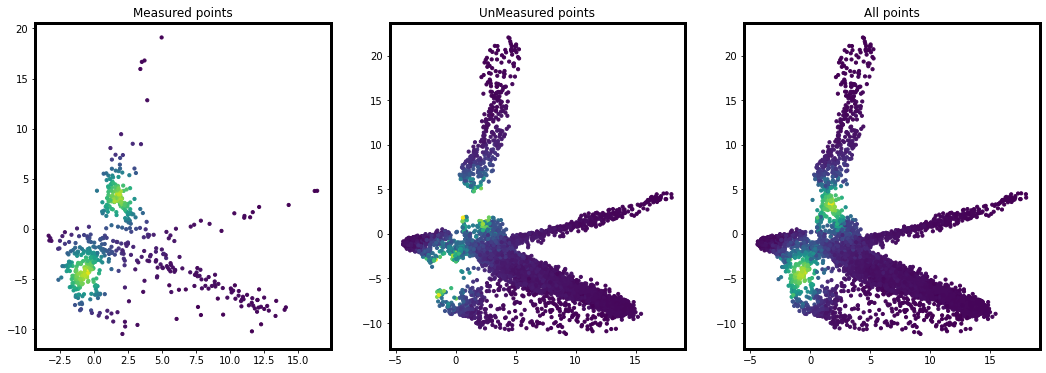

In [17]:
# Visualizing the latent distributions using the ground truths of the target function

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))

ax[0].scatter(embeded_train2[:, 1], embeded_train2[:, 0], s=10, c = y2_train, alpha=1)
ax[0].set_title('Measured points')

ax[1].scatter(embeded_unmeasured2[:, 1], embeded_unmeasured2[:, 0], s=10, c = curls_norm[indices_unmeasured_2])
ax[1].set_title('UnMeasured points')

ax[2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = curls_norm)
ax[2].set_title('All points')

Text(0.5, 1.0, 'Polarization_total')

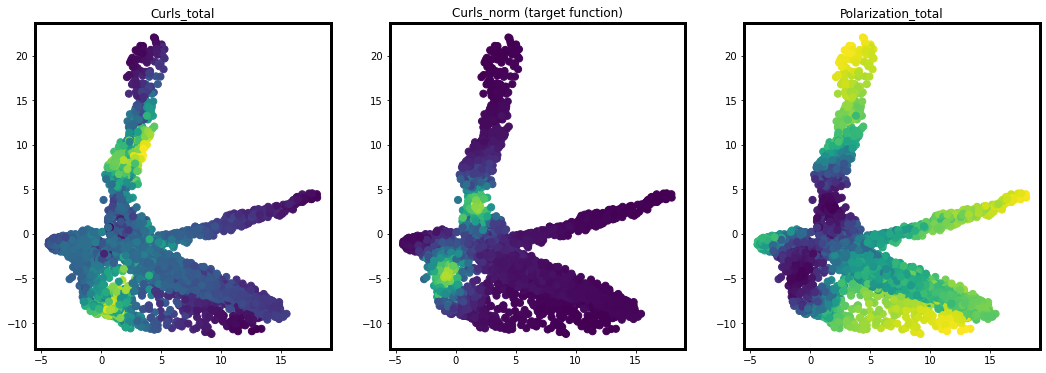

In [19]:
# Visulazing the entire latent distributions using ground-truths other target functions considered for this analysis
# Normalized Curl is used in training, but latent distributions of curl and polarization are also plotted 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].scatter(embeded12[:, 1], embeded12[:, 0], s=50, c = curls_total)
ax[0].set_title('Curls_total')

ax[1].scatter(embeded12[:, 1], embeded12[:, 0], s=50, c = curls_norm)
ax[1].set_title('Curls_norm (target function)')


ax[2].scatter(embeded12[:, 1], embeded12[:, 0], s=50, c = p_total)
ax[2].set_title('Polarization_total')

## Case-3
Targets: Total polarization

DO NOT RUN the next 2 cells. READ THE FOLLOWING COMMENTS  
  
The network was run on a clod server with following specifications
*   A100 GPU with 80GB memory with jax on Ubuntu 20.04.
*   jax and jaxlib versions are 0.3.25
*   CUDA version 11.4  

It takes the network about 3 minutes to run on the above-mentioned specifications.  
The GPUs (Tesla T4) provided by colab show that the estimated time is about 3-4 hours.

One can run the DKL network on the full dataset to recreate the results but it would take a lot of time. However, the dkl_BO results are stored and the network at the end of the exploration can be recreated after downlading the data

In [ ]:
# Training the DKL on the whole network
rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X, p_total)

100%|█| 1000/1000 [03:25<00:00,  4.87it/s, init loss: 10934160.7163, avg. loss [


Inferred GP kernel parameters
k_length         [2.6899 1.8491]
k_scale          2.5062
noise            3.5864000000000003


Text(0.5, 1.0, 'Polarization_total')

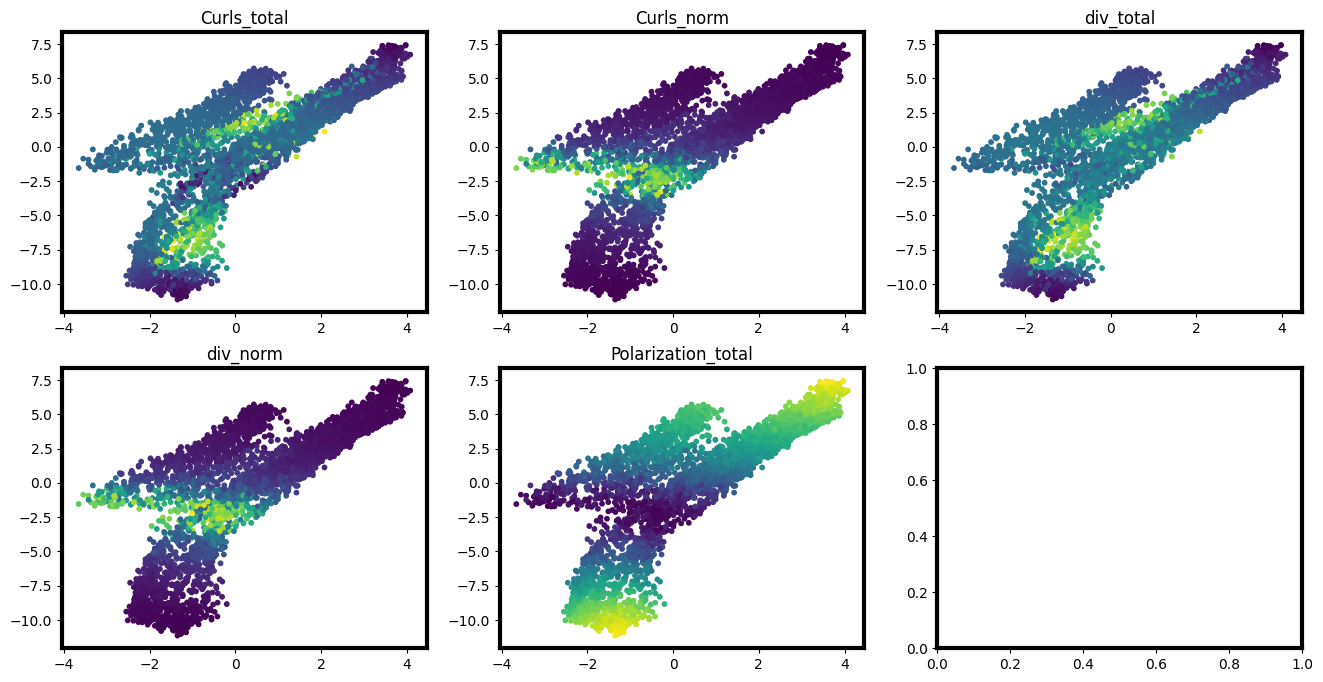

In [ ]:
# Latent space embeddings on the entire dataset
embeded_5 = dkl_5.embed(X)

# Predictions on the entire dataset
y_mean5, y_var5 = dkl_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_5, X, batch_size=250)

# Visualization of latent space distributions in static setting
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,8))
ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = curls_total)
ax[0,0].set_title('Curls_total')

ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = curls_norm)
ax[0,1].set_title('Curls_norm')

# ax[0,2].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = div_total)
# ax[0,2].set_title('div_total')

# ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = div_norm)
# ax[1,0].set_title('div_norm')

ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = p_total)
ax[1,1].set_title('Polarization_total')

Now running the DKL with BO, we will refer to this as dkl_BO network  
100 initialization points points and 500 exploration points  
acq_func = mu + 10 * sigma

In [21]:
# Picking the initialization points and preparing the dataset for BO

X5 = np.copy(dataset)
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = 100, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(dataset))
indices_train_5 = indices_total_5[idx5]
y5_train = p_total[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [ ]:
# The exploration takes some time. 
# However, We will download the explored points in the next cell and train one DKL
# network. This DKL is the network we end up with at the end of the exploration of 500 points.
# We can use this recreated DKL to visualize the results.

# Predictions made using the DKL trained on the whole dataset
y5_mean_full, y5_var_full = dkl_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict_5, X5, batch_size=250)

y5_std_full = jnp.sqrt(y5_var_full)

# Running the dkl_BO model with 500 exploration steps
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = 500


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])
    
    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(y5_mean_full[ind_next])
    dkl_std5.append(y5_std_full[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = p_total[ind_next]
    
    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)
    
    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=100)
    
    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)
    traj_std5.append(traj_s)

# Saving the results
pol_results = {}
pol_results['X_train'] = X5_train
pol_results['y_train'] = y5_train
pol_results['X_unmeasured'] = X5_unmeasured
pol_results['indices_unmeasured'] = indices_unmeasured_5
pol_results['dkl_mean'] = dkl_mean5
pol_results['dkl_std'] = dkl_std5
pol_results['exp_mean'] = exp_mean5
pol_results['exp_std'] = exp_std5
pol_results['traj_mean'] = traj_mean5
pol_results['traj_std'] = traj_std5
pol_results['embed_traj'] = embed_traj5

with open('pol_results.pickle', 'wb') as handle:
    pickle.dump(pol_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


Step 1


100%|█| 1000/1000 [00:02<00:00, 352.49it/s, init loss: 962178.6783, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9072 1.3886]
k_scale          3.5969
noise            2.7111

Step 2


100%|█| 1000/1000 [00:02<00:00, 365.45it/s, init loss: 972393.1230, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9486 1.314 ]
k_scale          3.8428
noise            2.3999

Step 3


100%|█| 1000/1000 [00:02<00:00, 373.02it/s, init loss: 982279.2639, avg. loss [9



Inferred GP kernel parameters
k_length         [1.9164 1.3401]
k_scale          3.7181
noise            2.4253

Step 4


100%|█| 1000/1000 [00:02<00:00, 375.43it/s, init loss: 997031.4008, avg. loss [9



Inferred GP kernel parameters
k_length         [1.8987 1.3928]
k_scale          3.6719000000000004
noise            2.4985

Step 5


100%|█| 1000/1000 [00:02<00:00, 377.59it/s, init loss: 1014289.4948, avg. loss [



Inferred GP kernel parameters
k_length         [2.0821 1.4306]
k_scale          3.9137000000000004
noise            2.4268

Step 6


100%|█| 1000/1000 [00:02<00:00, 374.75it/s, init loss: 1017207.1355, avg. loss [



Inferred GP kernel parameters
k_length         [1.7951 1.2619]
k_scale          3.806
noise            2.2991

Step 7


100%|█| 1000/1000 [00:03<00:00, 277.73it/s, init loss: 1028322.2183, avg. loss [



Inferred GP kernel parameters
k_length         [1.8349 1.2835]
k_scale          3.5609
noise            2.2771

Step 8


100%|█| 1000/1000 [00:02<00:00, 368.30it/s, init loss: 1034949.5926, avg. loss [



Inferred GP kernel parameters
k_length         [1.837  1.3019]
k_scale          3.7291000000000003
noise            2.4210000000000003

Step 9


100%|█| 1000/1000 [00:02<00:00, 368.24it/s, init loss: 1047643.6149, avg. loss [



Inferred GP kernel parameters
k_length         [1.8253 1.2458]
k_scale          3.8558000000000003
noise            2.4769

Step 10


100%|█| 1000/1000 [00:02<00:00, 376.84it/s, init loss: 1067042.8403, avg. loss [



Inferred GP kernel parameters
k_length         [1.7604 1.2176]
k_scale          4.1776
noise            3.4771

Step 11


100%|█| 1000/1000 [00:02<00:00, 374.58it/s, init loss: 1089845.1858, avg. loss [



Inferred GP kernel parameters
k_length         [1.8384 1.2829]
k_scale          4.4791
noise            2.6264000000000003

Step 12


100%|█| 1000/1000 [00:02<00:00, 378.47it/s, init loss: 1097411.1092, avg. loss [



Inferred GP kernel parameters
k_length         [1.783  1.2175]
k_scale          3.5071000000000003
noise            2.2745

Step 13


100%|█| 1000/1000 [00:02<00:00, 376.32it/s, init loss: 1099101.5095, avg. loss [



Inferred GP kernel parameters
k_length         [1.7975 1.194 ]
k_scale          3.6127000000000002
noise            2.4334000000000002

Step 14


100%|█| 1000/1000 [00:02<00:00, 340.57it/s, init loss: 1122104.2382, avg. loss [



Inferred GP kernel parameters
k_length         [1.789  1.2773]
k_scale          3.9245
noise            2.4713000000000003

Step 15


100%|█| 1000/1000 [00:02<00:00, 355.73it/s, init loss: 1138132.4585, avg. loss [



Inferred GP kernel parameters
k_length         [1.8048 1.2222]
k_scale          4.4831
noise            2.2827

Step 16


100%|█| 1000/1000 [00:02<00:00, 359.39it/s, init loss: 1165821.4332, avg. loss [



Inferred GP kernel parameters
k_length         [1.7922 1.2666]
k_scale          4.6919
noise            2.4648000000000003

Step 17


100%|█| 1000/1000 [00:02<00:00, 358.58it/s, init loss: 1177234.6155, avg. loss [



Inferred GP kernel parameters
k_length         [1.8732 1.2272]
k_scale          4.67
noise            2.6188000000000002

Step 18


100%|█| 1000/1000 [00:02<00:00, 361.86it/s, init loss: 1193178.1168, avg. loss [



Inferred GP kernel parameters
k_length         [1.8359 1.2564]
k_scale          3.2555
noise            2.2512000000000003

Step 19


100%|█| 1000/1000 [00:02<00:00, 368.60it/s, init loss: 1212301.7790, avg. loss [



Inferred GP kernel parameters
k_length         [1.8036 1.2106]
k_scale          4.4792000000000005
noise            2.3788

Step 20


100%|█| 1000/1000 [00:04<00:00, 237.42it/s, init loss: 1225237.4849, avg. loss [



Inferred GP kernel parameters
k_length         [1.9146 1.3377]
k_scale          3.3405
noise            2.3208

Step 21


100%|█| 1000/1000 [00:02<00:00, 352.37it/s, init loss: 1232400.0518, avg. loss [



Inferred GP kernel parameters
k_length         [1.8286 1.2118]
k_scale          3.3664
noise            2.2356000000000003

Step 22


100%|█| 1000/1000 [00:02<00:00, 358.73it/s, init loss: 1233953.4151, avg. loss [



Inferred GP kernel parameters
k_length         [1.9362 1.3065]
k_scale          4.4224000000000006
noise            2.4569

Step 23


100%|█| 1000/1000 [00:02<00:00, 358.83it/s, init loss: 1253219.2403, avg. loss [



Inferred GP kernel parameters
k_length         [1.7443 1.1976]
k_scale          3.4058
noise            2.2345

Step 24


100%|█| 1000/1000 [00:02<00:00, 363.91it/s, init loss: 1264966.7524, avg. loss [



Inferred GP kernel parameters
k_length         [1.7069 1.2009]
k_scale          3.2663
noise            2.3079

Step 25


100%|█| 1000/1000 [00:02<00:00, 364.39it/s, init loss: 1273151.0147, avg. loss [



Inferred GP kernel parameters
k_length         [1.7285 1.2324]
k_scale          3.3287
noise            2.2289000000000003

Step 26


100%|█| 1000/1000 [00:02<00:00, 368.86it/s, init loss: 1282042.4112, avg. loss [



Inferred GP kernel parameters
k_length         [1.7147 1.1958]
k_scale          3.6235000000000004
noise            3.4459

Step 27


100%|█| 1000/1000 [00:02<00:00, 335.88it/s, init loss: 1291014.7962, avg. loss [



Inferred GP kernel parameters
k_length         [1.7072 1.1441]
k_scale          3.2684
noise            2.1089

Step 28


100%|█| 1000/1000 [00:02<00:00, 349.77it/s, init loss: 1315482.3870, avg. loss [



Inferred GP kernel parameters
k_length         [1.8015 1.2468]
k_scale          4.5172
noise            2.4019

Step 29


100%|█| 1000/1000 [00:02<00:00, 354.71it/s, init loss: 1322988.1175, avg. loss [



Inferred GP kernel parameters
k_length         [1.765  1.2353]
k_scale          3.2138
noise            2.1691000000000003

Step 30


100%|█| 1000/1000 [00:02<00:00, 351.50it/s, init loss: 1345410.3796, avg. loss [



Inferred GP kernel parameters
k_length         [1.7396 1.1609]
k_scale          3.3496
noise            2.3477

Step 31


100%|█| 1000/1000 [00:02<00:00, 354.98it/s, init loss: 1354628.3008, avg. loss [



Inferred GP kernel parameters
k_length         [1.6979 1.2418]
k_scale          4.506
noise            2.4257

Step 32


100%|█| 1000/1000 [00:02<00:00, 360.41it/s, init loss: 1381777.1480, avg. loss [



Inferred GP kernel parameters
k_length         [1.8771 1.3336]
k_scale          3.3705000000000003
noise            2.4068

Step 33


100%|█| 1000/1000 [00:04<00:00, 234.62it/s, init loss: 1391203.6563, avg. loss [



Inferred GP kernel parameters
k_length         [1.8045 1.243 ]
k_scale          3.2157
noise            2.2875

Step 34


100%|█| 1000/1000 [00:02<00:00, 350.86it/s, init loss: 1407364.9912, avg. loss [



Inferred GP kernel parameters
k_length         [1.7282 1.2355]
k_scale          3.2845
noise            2.2693000000000003

Step 35


100%|█| 1000/1000 [00:02<00:00, 361.01it/s, init loss: 1434971.7842, avg. loss [



Inferred GP kernel parameters
k_length         [1.7695 1.1707]
k_scale          4.4513
noise            2.4923

Step 36


100%|█| 1000/1000 [00:02<00:00, 360.92it/s, init loss: 1444418.9159, avg. loss [



Inferred GP kernel parameters
k_length         [1.7257 1.1984]
k_scale          3.2018
noise            2.2803

Step 37


100%|█| 1000/1000 [00:02<00:00, 364.88it/s, init loss: 1463026.9916, avg. loss [



Inferred GP kernel parameters
k_length         [1.7493 1.2438]
k_scale          4.3091
noise            2.4979

Step 38


100%|█| 1000/1000 [00:02<00:00, 371.82it/s, init loss: 1469880.4137, avg. loss [



Inferred GP kernel parameters
k_length         [1.706  1.1578]
k_scale          4.3872
noise            2.2603

Step 39


100%|█| 1000/1000 [00:02<00:00, 375.02it/s, init loss: 1496157.5618, avg. loss [



Inferred GP kernel parameters
k_length         [1.7166 1.1557]
k_scale          3.2009000000000003
noise            2.1596

Step 40


100%|█| 1000/1000 [00:02<00:00, 354.69it/s, init loss: 1502634.4008, avg. loss [



Inferred GP kernel parameters
k_length         [1.7134 1.1087]
k_scale          3.2668000000000004
noise            2.0485

Step 41


100%|█| 1000/1000 [00:02<00:00, 355.00it/s, init loss: 1515323.2589, avg. loss [



Inferred GP kernel parameters
k_length         [1.6153 1.1743]
k_scale          4.2939
noise            2.1836

Step 42


100%|█| 1000/1000 [00:02<00:00, 360.92it/s, init loss: 1530218.8929, avg. loss [



Inferred GP kernel parameters
k_length         [1.7119 1.1463]
k_scale          3.2145
noise            2.045

Step 43


100%|█| 1000/1000 [00:02<00:00, 364.84it/s, init loss: 1540014.0711, avg. loss [



Inferred GP kernel parameters
k_length         [1.8104 1.264 ]
k_scale          3.0565
noise            2.3201

Step 44


100%|█| 1000/1000 [00:02<00:00, 368.75it/s, init loss: 1553125.7520, avg. loss [



Inferred GP kernel parameters
k_length         [1.7928 1.1947]
k_scale          4.383500000000001
noise            2.4412000000000003

Step 45


100%|█| 1000/1000 [00:02<00:00, 366.76it/s, init loss: 1560520.3818, avg. loss [



Inferred GP kernel parameters
k_length         [1.7066 1.1592]
k_scale          3.1526
noise            2.0924

Step 46


100%|█| 1000/1000 [00:02<00:00, 368.45it/s, init loss: 1573989.1958, avg. loss [



Inferred GP kernel parameters
k_length         [1.6723 1.1452]
k_scale          3.2494
noise            2.0874

Step 47


100%|█| 1000/1000 [00:02<00:00, 353.03it/s, init loss: 1578651.2998, avg. loss [



Inferred GP kernel parameters
k_length         [1.679  1.1651]
k_scale          4.2893
noise            2.2002

Step 48


100%|█| 1000/1000 [00:02<00:00, 359.74it/s, init loss: 1593175.8451, avg. loss [



Inferred GP kernel parameters
k_length         [1.7405 1.2578]
k_scale          3.2254
noise            2.2333000000000003

Step 49


100%|█| 1000/1000 [00:02<00:00, 360.27it/s, init loss: 1618764.6578, avg. loss [



Inferred GP kernel parameters
k_length         [1.7371 1.1739]
k_scale          3.1773000000000002
noise            2.1270000000000002

Step 50


100%|█| 1000/1000 [00:02<00:00, 364.01it/s, init loss: 1637448.9323, avg. loss [



Inferred GP kernel parameters
k_length         [1.7675 1.2687]
k_scale          3.2354000000000003
noise            2.3103000000000002

Step 51


100%|█| 1000/1000 [00:02<00:00, 363.68it/s, init loss: 1656006.2798, avg. loss [



Inferred GP kernel parameters
k_length         [1.8035 1.15  ]
k_scale          3.0896000000000003
noise            2.2071

Step 52


100%|█| 1000/1000 [00:02<00:00, 366.19it/s, init loss: 1672477.5203, avg. loss [



Inferred GP kernel parameters
k_length         [1.7324 1.1861]
k_scale          3.0020000000000002
noise            2.1678

Step 53


100%|█| 1000/1000 [00:02<00:00, 350.61it/s, init loss: 1687581.8893, avg. loss [



Inferred GP kernel parameters
k_length         [1.749 1.244]
k_scale          3.1575
noise            2.3984

Step 54


100%|█| 1000/1000 [00:02<00:00, 354.72it/s, init loss: 1695005.7884, avg. loss [



Inferred GP kernel parameters
k_length         [1.8305 1.1793]
k_scale          4.1421
noise            2.3735

Step 55


100%|█| 1000/1000 [00:02<00:00, 362.60it/s, init loss: 1702861.3747, avg. loss [



Inferred GP kernel parameters
k_length         [1.6477 1.1619]
k_scale          3.2393
noise            2.1324

Step 56


100%|█| 1000/1000 [00:02<00:00, 368.28it/s, init loss: 1722678.6011, avg. loss [



Inferred GP kernel parameters
k_length         [1.7477 1.174 ]
k_scale          3.1236
noise            2.2719

Step 57


100%|█| 1000/1000 [00:02<00:00, 370.16it/s, init loss: 1734956.6608, avg. loss [



Inferred GP kernel parameters
k_length         [1.65 1.21]
k_scale          3.1779
noise            2.3367

Step 58


100%|█| 1000/1000 [00:02<00:00, 366.38it/s, init loss: 1750593.8477, avg. loss [



Inferred GP kernel parameters
k_length         [1.6617 1.2355]
k_scale          4.0626
noise            2.3649

Step 59


100%|█| 1000/1000 [00:02<00:00, 365.55it/s, init loss: 1776413.6445, avg. loss [



Inferred GP kernel parameters
k_length         [1.7124 1.2077]
k_scale          3.0204
noise            2.1966

Step 60


100%|█| 1000/1000 [00:02<00:00, 353.61it/s, init loss: 1781307.5531, avg. loss [



Inferred GP kernel parameters
k_length         [1.7318 1.1912]
k_scale          3.0496000000000003
noise            2.1368

Step 61


100%|█| 1000/1000 [00:02<00:00, 363.23it/s, init loss: 1785563.5757, avg. loss [



Inferred GP kernel parameters
k_length         [1.7432 1.2106]
k_scale          2.9528000000000003
noise            2.181

Step 62


100%|█| 1000/1000 [00:02<00:00, 363.26it/s, init loss: 1790536.8216, avg. loss [



Inferred GP kernel parameters
k_length         [1.6179 1.1223]
k_scale          4.2495
noise            2.205

Step 63


100%|█| 1000/1000 [00:02<00:00, 367.88it/s, init loss: 1803250.0844, avg. loss [



Inferred GP kernel parameters
k_length         [1.7856 1.2115]
k_scale          3.0418000000000003
noise            2.2027

Step 64


100%|█| 1000/1000 [00:02<00:00, 367.20it/s, init loss: 1807118.3268, avg. loss [



Inferred GP kernel parameters
k_length         [1.754  1.3462]
k_scale          3.7131000000000003
noise            2.5814

Step 65


100%|█| 1000/1000 [00:02<00:00, 369.00it/s, init loss: 1823372.3650, avg. loss [



Inferred GP kernel parameters
k_length         [1.6256 1.1375]
k_scale          3.044
noise            2.0551

Step 66


100%|█| 1000/1000 [00:03<00:00, 272.93it/s, init loss: 1826723.6000, avg. loss [



Inferred GP kernel parameters
k_length         [1.6692 1.1589]
k_scale          3.1319000000000004
noise            2.2462

Step 67


100%|█| 1000/1000 [00:02<00:00, 355.94it/s, init loss: 1831728.4861, avg. loss [



Inferred GP kernel parameters
k_length         [1.6245 1.1471]
k_scale          2.9695
noise            2.0533

Step 68


100%|█| 1000/1000 [00:02<00:00, 362.30it/s, init loss: 1838316.9548, avg. loss [



Inferred GP kernel parameters
k_length         [1.6982 1.1575]
k_scale          3.0586
noise            2.0686

Step 69


100%|█| 1000/1000 [00:02<00:00, 363.78it/s, init loss: 1849995.6567, avg. loss [



Inferred GP kernel parameters
k_length         [1.6935 1.1341]
k_scale          2.9363
noise            2.027

Step 70


100%|█| 1000/1000 [00:02<00:00, 365.23it/s, init loss: 1860725.6153, avg. loss [



Inferred GP kernel parameters
k_length         [1.7204 1.1224]
k_scale          3.0344
noise            2.0392

Step 71


100%|█| 1000/1000 [00:02<00:00, 357.72it/s, init loss: 1864366.5022, avg. loss [



Inferred GP kernel parameters
k_length         [1.7038 1.1715]
k_scale          2.9561
noise            2.1451000000000002

Step 72


100%|█| 1000/1000 [00:04<00:00, 243.32it/s, init loss: 1870347.1030, avg. loss [



Inferred GP kernel parameters
k_length         [1.7094 1.1647]
k_scale          3.0557000000000003
noise            2.1899

Step 73


100%|█| 1000/1000 [00:02<00:00, 354.49it/s, init loss: 1898863.0739, avg. loss [



Inferred GP kernel parameters
k_length         [1.6543 1.1601]
k_scale          2.9650000000000003
noise            2.0656

Step 74


100%|█| 1000/1000 [00:02<00:00, 358.66it/s, init loss: 1901288.5105, avg. loss [



Inferred GP kernel parameters
k_length         [1.7095 1.109 ]
k_scale          3.8581000000000003
noise            2.2131000000000003

Step 75


100%|█| 1000/1000 [00:02<00:00, 353.11it/s, init loss: 1921157.7301, avg. loss [



Inferred GP kernel parameters
k_length         [1.7749 1.1902]
k_scale          3.8276000000000003
noise            2.318

Step 76


100%|█| 1000/1000 [00:02<00:00, 366.46it/s, init loss: 1926615.8662, avg. loss [



Inferred GP kernel parameters
k_length         [1.7301 1.1312]
k_scale          3.0183
noise            2.0731

Step 77


100%|█| 1000/1000 [00:02<00:00, 369.66it/s, init loss: 1930943.0017, avg. loss [



Inferred GP kernel parameters
k_length         [1.731  1.1862]
k_scale          3.0103
noise            2.2509

Step 78


100%|█| 1000/1000 [00:02<00:00, 365.56it/s, init loss: 1947611.3486, avg. loss [



Inferred GP kernel parameters
k_length         [1.6869 1.1651]
k_scale          2.9819
noise            2.1947

Step 79


100%|█| 1000/1000 [00:02<00:00, 345.99it/s, init loss: 1970396.2193, avg. loss [



Inferred GP kernel parameters
k_length         [1.6888 1.1629]
k_scale          3.9541000000000004
noise            2.3294

Step 80


100%|█| 1000/1000 [00:02<00:00, 353.27it/s, init loss: 1976557.1825, avg. loss [



Inferred GP kernel parameters
k_length         [1.6982 1.1877]
k_scale          2.8765
noise            2.1391

Step 81


100%|█| 1000/1000 [00:02<00:00, 358.85it/s, init loss: 1988112.5632, avg. loss [



Inferred GP kernel parameters
k_length         [1.651  1.2498]
k_scale          3.5467
noise            2.5391

Step 82


100%|█| 1000/1000 [00:02<00:00, 361.68it/s, init loss: 1991391.6561, avg. loss [



Inferred GP kernel parameters
k_length         [1.7503 1.229 ]
k_scale          2.783
noise            2.1967000000000003

Step 83


100%|█| 1000/1000 [00:02<00:00, 368.02it/s, init loss: 2001380.3764, avg. loss [



Inferred GP kernel parameters
k_length         [1.7047 1.1785]
k_scale          2.9019
noise            2.1556

Step 84


100%|█| 1000/1000 [00:02<00:00, 368.72it/s, init loss: 2012714.8746, avg. loss [



Inferred GP kernel parameters
k_length         [1.8816 1.2484]
k_scale          3.2006
noise            2.3810000000000002

Step 85


100%|█| 1000/1000 [00:03<00:00, 272.18it/s, init loss: 2013634.9569, avg. loss [



Inferred GP kernel parameters
k_length         [1.733  1.1737]
k_scale          2.8518000000000003
noise            2.2164

Step 86


100%|█| 1000/1000 [00:02<00:00, 336.62it/s, init loss: 2015851.5772, avg. loss [



Inferred GP kernel parameters
k_length         [1.8464 1.2792]
k_scale          2.7880000000000003
noise            2.2876000000000003

Step 87


100%|█| 1000/1000 [00:02<00:00, 358.20it/s, init loss: 2030664.4039, avg. loss [



Inferred GP kernel parameters
k_length         [1.7636 1.1949]
k_scale          2.8396000000000003
noise            2.1445000000000003

Step 88


100%|█| 1000/1000 [00:02<00:00, 361.64it/s, init loss: 2041664.7708, avg. loss [



Inferred GP kernel parameters
k_length         [1.7433 1.2289]
k_scale          2.8541000000000003
noise            2.289

Step 89


100%|█| 1000/1000 [00:02<00:00, 366.68it/s, init loss: 2059103.6026, avg. loss [



Inferred GP kernel parameters
k_length         [1.815  1.2367]
k_scale          2.9815
noise            2.2473

Step 90


100%|█| 1000/1000 [00:02<00:00, 366.98it/s, init loss: 2064237.0943, avg. loss [



Inferred GP kernel parameters
k_length         [1.7183 1.1342]
k_scale          3.8713
noise            2.2838000000000003

Step 91


100%|█| 1000/1000 [00:02<00:00, 364.97it/s, init loss: 2081300.3915, avg. loss [



Inferred GP kernel parameters
k_length         [1.647  1.2359]
k_scale          2.8191
noise            2.1647000000000003

Step 92


100%|█| 1000/1000 [00:02<00:00, 346.77it/s, init loss: 2094504.3194, avg. loss [



Inferred GP kernel parameters
k_length         [1.7452 1.2061]
k_scale          2.8191
noise            2.1636

Step 93


100%|█| 1000/1000 [00:02<00:00, 352.89it/s, init loss: 2102012.9259, avg. loss [



Inferred GP kernel parameters
k_length         [1.6743 1.2461]
k_scale          2.7365
noise            2.1910000000000003

Step 94


100%|█| 1000/1000 [00:02<00:00, 354.61it/s, init loss: 2117595.4032, avg. loss [



Inferred GP kernel parameters
k_length         [1.7482 1.2035]
k_scale          2.8052
noise            2.1779

Step 95


100%|█| 1000/1000 [00:02<00:00, 363.97it/s, init loss: 2143570.3103, avg. loss [



Inferred GP kernel parameters
k_length         [1.7157 1.1846]
k_scale          2.7677
noise            2.1367000000000003

Step 96


100%|█| 1000/1000 [00:02<00:00, 366.74it/s, init loss: 2149892.8039, avg. loss [



Inferred GP kernel parameters
k_length         [1.8286 1.2426]
k_scale          2.8913
noise            2.4399

Step 97


100%|█| 1000/1000 [00:02<00:00, 364.43it/s, init loss: 2164998.6730, avg. loss [



Inferred GP kernel parameters
k_length         [1.6653 1.1627]
k_scale          2.7652
noise            2.1023

Step 98


100%|█| 1000/1000 [00:03<00:00, 274.94it/s, init loss: 2171361.8041, avg. loss [



Inferred GP kernel parameters
k_length         [1.6895 1.2013]
k_scale          3.0975
noise            2.2643

Step 99


100%|█| 1000/1000 [00:02<00:00, 356.67it/s, init loss: 2174235.6454, avg. loss [



Inferred GP kernel parameters
k_length         [1.7433 1.2102]
k_scale          2.6831
noise            2.0665

Step 100


100%|█| 1000/1000 [00:02<00:00, 361.38it/s, init loss: 2178188.5848, avg. loss [



Inferred GP kernel parameters
k_length         [1.6588 1.203 ]
k_scale          2.7445
noise            2.0836

Step 101


100%|█| 1000/1000 [00:02<00:00, 363.92it/s, init loss: 2179705.8501, avg. loss [



Inferred GP kernel parameters
k_length         [1.7158 1.1721]
k_scale          2.7118
noise            2.1257

Step 102


100%|█| 1000/1000 [00:02<00:00, 366.22it/s, init loss: 2180914.5462, avg. loss [



Inferred GP kernel parameters
k_length         [1.7298 1.2081]
k_scale          2.6750000000000003
noise            2.2069

Step 103


100%|█| 1000/1000 [00:02<00:00, 369.13it/s, init loss: 2191106.1896, avg. loss [



Inferred GP kernel parameters
k_length         [1.8276 1.318 ]
k_scale          2.6361000000000003
noise            2.2641

Step 104


100%|█| 1000/1000 [00:02<00:00, 372.41it/s, init loss: 2210718.8220, avg. loss [



Inferred GP kernel parameters
k_length         [1.6787 1.2066]
k_scale          2.6790000000000003
noise            2.1748000000000003

Step 105


100%|█| 1000/1000 [00:02<00:00, 348.32it/s, init loss: 2212805.7775, avg. loss [



Inferred GP kernel parameters
k_length         [1.7485 1.1762]
k_scale          2.6767000000000003
noise            2.1477

Step 106


100%|█| 1000/1000 [00:02<00:00, 356.75it/s, init loss: 2220478.9203, avg. loss [



Inferred GP kernel parameters
k_length         [1.6273 1.1092]
k_scale          3.8151
noise            2.1349

Step 107


100%|█| 1000/1000 [00:02<00:00, 359.76it/s, init loss: 2232150.5031, avg. loss [



Inferred GP kernel parameters
k_length         [1.7261 1.2154]
k_scale          2.7284
noise            2.2639

Step 108


100%|█| 1000/1000 [00:02<00:00, 362.60it/s, init loss: 2234268.8183, avg. loss [



Inferred GP kernel parameters
k_length         [1.6155 1.1677]
k_scale          3.7604
noise            2.3286000000000002

Step 109


100%|█| 1000/1000 [00:02<00:00, 365.69it/s, init loss: 2242061.7651, avg. loss [



Inferred GP kernel parameters
k_length         [1.6793 1.1491]
k_scale          2.708
noise            2.1273

Step 110


100%|█| 1000/1000 [00:02<00:00, 365.71it/s, init loss: 2242289.9572, avg. loss [



Inferred GP kernel parameters
k_length         [1.6573 1.1447]
k_scale          3.7804
noise            2.2192000000000003

Step 111


100%|█| 1000/1000 [00:03<00:00, 274.22it/s, init loss: 2248867.2901, avg. loss [



Inferred GP kernel parameters
k_length         [1.7578 1.2278]
k_scale          2.3307
noise            1.9823000000000002

Step 112


100%|█| 1000/1000 [00:02<00:00, 352.71it/s, init loss: 2249398.0472, avg. loss [



Inferred GP kernel parameters
k_length         [1.6581 1.1359]
k_scale          2.7339
noise            2.0448

Step 113


100%|█| 1000/1000 [00:02<00:00, 355.02it/s, init loss: 2254814.1613, avg. loss [



Inferred GP kernel parameters
k_length         [1.8102 1.2011]
k_scale          2.8586
noise            2.4307000000000003

Step 114


100%|█| 1000/1000 [00:02<00:00, 358.95it/s, init loss: 2272322.1402, avg. loss [



Inferred GP kernel parameters
k_length         [1.5971 1.1698]
k_scale          3.599
noise            2.1417

Step 115


100%|█| 1000/1000 [00:02<00:00, 358.65it/s, init loss: 2276813.5485, avg. loss [



Inferred GP kernel parameters
k_length         [1.7205 1.1835]
k_scale          3.7149
noise            2.2947

Step 116


100%|█| 1000/1000 [00:02<00:00, 362.36it/s, init loss: 2283048.3566, avg. loss [



Inferred GP kernel parameters
k_length         [1.6511 1.1627]
k_scale          3.7172
noise            2.1937

Step 117


100%|█| 1000/1000 [00:02<00:00, 364.48it/s, init loss: 2295622.2750, avg. loss [



Inferred GP kernel parameters
k_length         [1.7126 1.1409]
k_scale          3.584
noise            2.0908

Step 118


100%|█| 1000/1000 [00:02<00:00, 341.43it/s, init loss: 2298620.1307, avg. loss [



Inferred GP kernel parameters
k_length         [1.7002 1.1699]
k_scale          2.6527000000000003
noise            2.1093

Step 119


100%|█| 1000/1000 [00:02<00:00, 347.34it/s, init loss: 2301992.5258, avg. loss [



Inferred GP kernel parameters
k_length         [1.7481 1.1945]
k_scale          3.7064000000000004
noise            2.2

Step 120


100%|█| 1000/1000 [00:02<00:00, 354.06it/s, init loss: 2302009.2035, avg. loss [



Inferred GP kernel parameters
k_length         [1.6644 1.1494]
k_scale          3.5946000000000002
noise            2.1334

Step 121


100%|█| 1000/1000 [00:02<00:00, 358.21it/s, init loss: 2305707.5051, avg. loss [



Inferred GP kernel parameters
k_length         [1.6451 1.1665]
k_scale          3.5764
noise            2.2083

Step 122


100%|█| 1000/1000 [00:02<00:00, 361.01it/s, init loss: 2309060.9514, avg. loss [



Inferred GP kernel parameters
k_length         [1.7677 1.1953]
k_scale          2.7177000000000002
noise            2.4066

Step 123


100%|█| 1000/1000 [00:02<00:00, 360.92it/s, init loss: 2310909.8530, avg. loss [



Inferred GP kernel parameters
k_length         [1.6763 1.1129]
k_scale          2.5967000000000002
noise            2.0522

Step 124


100%|█| 1000/1000 [00:03<00:00, 272.20it/s, init loss: 2331539.3807, avg. loss [



Inferred GP kernel parameters
k_length         [1.6933 1.1463]
k_scale          2.6038
noise            2.1105

Step 125


100%|█| 1000/1000 [00:02<00:00, 349.29it/s, init loss: 2331916.8530, avg. loss [



Inferred GP kernel parameters
k_length         [1.7099 1.1921]
k_scale          2.6286
noise            2.2241

Step 126


100%|█| 1000/1000 [00:02<00:00, 357.48it/s, init loss: 2336883.5882, avg. loss [



Inferred GP kernel parameters
k_length         [1.6952 1.1334]
k_scale          3.6471
noise            2.1789

Step 127


100%|█| 1000/1000 [00:02<00:00, 357.75it/s, init loss: 2339516.4776, avg. loss [



Inferred GP kernel parameters
k_length         [1.7008 1.1885]
k_scale          2.6321000000000003
noise            2.2363

Step 128


100%|█| 1000/1000 [00:02<00:00, 360.52it/s, init loss: 2359663.1401, avg. loss [



Inferred GP kernel parameters
k_length         [1.6795 1.1246]
k_scale          2.5783
noise            2.0324

Step 129


100%|█| 1000/1000 [00:02<00:00, 361.82it/s, init loss: 2363158.2323, avg. loss [



Inferred GP kernel parameters
k_length         [1.8052 1.2024]
k_scale          3.7042
noise            2.2398000000000002

Step 130


100%|█| 1000/1000 [00:03<00:00, 277.63it/s, init loss: 2365969.3226, avg. loss [



Inferred GP kernel parameters
k_length         [1.6875 1.1822]
k_scale          2.6044
noise            2.1398

Step 131


100%|█| 1000/1000 [00:02<00:00, 351.04it/s, init loss: 2366301.8060, avg. loss [



Inferred GP kernel parameters
k_length         [1.872  1.2364]
k_scale          3.2068000000000003
noise            2.5124

Step 132


100%|█| 1000/1000 [00:02<00:00, 355.84it/s, init loss: 2374216.4325, avg. loss [



Inferred GP kernel parameters
k_length         [1.7134 1.1793]
k_scale          3.1122
noise            2.2559

Step 133


100%|█| 1000/1000 [00:02<00:00, 359.05it/s, init loss: 2384669.9110, avg. loss [



Inferred GP kernel parameters
k_length         [1.7431 1.1678]
k_scale          3.5758
noise            2.1985

Step 134


100%|█| 1000/1000 [00:02<00:00, 362.44it/s, init loss: 2388120.3857, avg. loss [



Inferred GP kernel parameters
k_length         [1.6141 1.1314]
k_scale          3.4336
noise            2.1721

Step 135


100%|█| 1000/1000 [00:02<00:00, 364.35it/s, init loss: 2396984.6359, avg. loss [



Inferred GP kernel parameters
k_length         [1.6889 1.2012]
k_scale          2.5609
noise            2.2035

Step 136


100%|█| 1000/1000 [00:02<00:00, 370.19it/s, init loss: 2397606.9491, avg. loss [



Inferred GP kernel parameters
k_length         [1.6952 1.2141]
k_scale          3.4991000000000003
noise            2.2572

Step 137


100%|█| 1000/1000 [00:02<00:00, 344.25it/s, init loss: 2405965.1646, avg. loss [



Inferred GP kernel parameters
k_length         [1.7138 1.1623]
k_scale          2.5617
noise            2.261

Step 138


100%|█| 1000/1000 [00:02<00:00, 351.62it/s, init loss: 2406807.9714, avg. loss [



Inferred GP kernel parameters
k_length         [1.7762 1.2772]
k_scale          3.6142000000000003
noise            2.5352

Step 139


100%|█| 1000/1000 [00:02<00:00, 359.37it/s, init loss: 2407431.1147, avg. loss [



Inferred GP kernel parameters
k_length         [1.7476 1.2427]
k_scale          3.5786000000000002
noise            2.2879

Step 140


100%|█| 1000/1000 [00:02<00:00, 361.18it/s, init loss: 2422534.6151, avg. loss [



Inferred GP kernel parameters
k_length         [1.669  1.1434]
k_scale          3.4814000000000003
noise            2.0414

Step 141


100%|█| 1000/1000 [00:02<00:00, 364.74it/s, init loss: 2433444.2772, avg. loss [



Inferred GP kernel parameters
k_length         [1.6479 1.1912]
k_scale          3.6488
noise            2.3000000000000003

Step 142


100%|█| 1000/1000 [00:02<00:00, 363.73it/s, init loss: 2435514.6754, avg. loss [



Inferred GP kernel parameters
k_length         [1.8041 1.2004]
k_scale          2.6628000000000003
noise            2.2905

Step 143


100%|█| 1000/1000 [00:03<00:00, 271.96it/s, init loss: 2440796.4899, avg. loss [



Inferred GP kernel parameters
k_length         [1.6788 1.1565]
k_scale          3.4341000000000004
noise            2.1155

Step 144


100%|█| 1000/1000 [00:02<00:00, 348.88it/s, init loss: 2450676.6770, avg. loss [



Inferred GP kernel parameters
k_length         [1.8376 1.269 ]
k_scale          2.9986
noise            2.3399

Step 145


100%|█| 1000/1000 [00:02<00:00, 355.76it/s, init loss: 2450764.0866, avg. loss [



Inferred GP kernel parameters
k_length         [1.7447 1.2035]
k_scale          4.5507
noise            2.5291

Step 146


100%|█| 1000/1000 [00:02<00:00, 359.70it/s, init loss: 2456631.0602, avg. loss [



Inferred GP kernel parameters
k_length         [1.817  1.2204]
k_scale          3.0366
noise            2.4376

Step 147


100%|█| 1000/1000 [00:02<00:00, 359.11it/s, init loss: 2467847.2531, avg. loss [



Inferred GP kernel parameters
k_length         [1.7091 1.234 ]
k_scale          3.4673000000000003
noise            2.3757

Step 148


100%|█| 1000/1000 [00:02<00:00, 361.32it/s, init loss: 2475365.3112, avg. loss [



Inferred GP kernel parameters
k_length         [1.7481 1.1926]
k_scale          2.5422000000000002
noise            2.2541

Step 149


100%|█| 1000/1000 [00:02<00:00, 365.65it/s, init loss: 2478539.8784, avg. loss [



Inferred GP kernel parameters
k_length         [1.6288 1.1712]
k_scale          2.6639
noise            2.2135000000000002

Step 150


100%|█| 1000/1000 [00:02<00:00, 344.19it/s, init loss: 2479108.3262, avg. loss [



Inferred GP kernel parameters
k_length         [1.6548 1.2056]
k_scale          3.7332
noise            2.3441

Step 151


100%|█| 1000/1000 [00:02<00:00, 348.03it/s, init loss: 2484670.5961, avg. loss [



Inferred GP kernel parameters
k_length         [1.7161 1.1624]
k_scale          3.6718
noise            2.1253

Step 152


100%|█| 1000/1000 [00:02<00:00, 353.42it/s, init loss: 2486933.4347, avg. loss [



Inferred GP kernel parameters
k_length         [1.6886 1.1148]
k_scale          2.5882
noise            2.161

Step 153


100%|█| 1000/1000 [00:02<00:00, 353.88it/s, init loss: 2487077.6510, avg. loss [



Inferred GP kernel parameters
k_length         [1.6985 1.1372]
k_scale          3.6023
noise            2.1843

Step 154


100%|█| 1000/1000 [00:02<00:00, 357.74it/s, init loss: 2498689.2355, avg. loss [



Inferred GP kernel parameters
k_length         [1.6715 1.1482]
k_scale          2.5576000000000003
noise            2.1056

Step 155


100%|█| 1000/1000 [00:02<00:00, 362.55it/s, init loss: 2499277.3218, avg. loss [



Inferred GP kernel parameters
k_length         [1.6543 1.1451]
k_scale          3.4439
noise            2.2864

Step 156


100%|█| 1000/1000 [00:03<00:00, 273.04it/s, init loss: 2500571.0636, avg. loss [



Inferred GP kernel parameters
k_length         [1.7405 1.1845]
k_scale          2.6058000000000003
noise            2.2102

Step 157


100%|█| 1000/1000 [00:02<00:00, 343.26it/s, init loss: 2503242.2011, avg. loss [



Inferred GP kernel parameters
k_length         [1.7664 1.2266]
k_scale          3.4136
noise            2.2599

Step 158


100%|█| 1000/1000 [00:02<00:00, 348.66it/s, init loss: 2506209.1246, avg. loss [



Inferred GP kernel parameters
k_length         [1.7274 1.2405]
k_scale          2.5173
noise            2.2406

Step 159


100%|█| 1000/1000 [00:02<00:00, 350.87it/s, init loss: 2521125.2705, avg. loss [



Inferred GP kernel parameters
k_length         [1.6921 1.1467]
k_scale          2.5529
noise            2.1826000000000003

Step 160


100%|█| 1000/1000 [00:02<00:00, 352.89it/s, init loss: 2527079.2083, avg. loss [



Inferred GP kernel parameters
k_length         [1.7241 1.1775]
k_scale          2.4907
noise            2.1571000000000002

Step 161


100%|█| 1000/1000 [00:02<00:00, 356.68it/s, init loss: 2527915.9686, avg. loss [



Inferred GP kernel parameters
k_length         [1.6409 1.0962]
k_scale          3.5961000000000003
noise            2.12

Step 162


100%|█| 1000/1000 [00:02<00:00, 358.84it/s, init loss: 2544906.6438, avg. loss [



Inferred GP kernel parameters
k_length         [1.7182 1.1784]
k_scale          2.4282
noise            2.1816

Step 163


100%|█| 1000/1000 [00:02<00:00, 335.44it/s, init loss: 2546440.9401, avg. loss [



Inferred GP kernel parameters
k_length         [1.7924 1.2691]
k_scale          2.2656
noise            2.2687

Step 164


100%|█| 1000/1000 [00:02<00:00, 343.45it/s, init loss: 2546839.7650, avg. loss [



Inferred GP kernel parameters
k_length         [1.7743 1.2283]
k_scale          2.9924
noise            2.4156

Step 165


100%|█| 1000/1000 [00:02<00:00, 347.86it/s, init loss: 2555024.2033, avg. loss [



Inferred GP kernel parameters
k_length         [1.6612 1.1784]
k_scale          3.1963000000000004
noise            2.3273

Step 166


100%|█| 1000/1000 [00:02<00:00, 352.32it/s, init loss: 2555650.4050, avg. loss [



Inferred GP kernel parameters
k_length         [1.7762 1.2068]
k_scale          3.196
noise            2.0871

Step 167


100%|█| 1000/1000 [00:02<00:00, 354.32it/s, init loss: 2564943.6314, avg. loss [



Inferred GP kernel parameters
k_length         [1.7039 1.1868]
k_scale          3.5565
noise            2.3284000000000002

Step 168


100%|█| 1000/1000 [00:02<00:00, 355.95it/s, init loss: 2569347.0879, avg. loss [



Inferred GP kernel parameters
k_length         [1.6929 1.2375]
k_scale          2.5057
noise            2.2782

Step 169


100%|█| 1000/1000 [00:03<00:00, 268.62it/s, init loss: 2569348.7761, avg. loss [



Inferred GP kernel parameters
k_length         [1.6599 1.276 ]
k_scale          2.6476
noise            2.3761

Step 170


100%|█| 1000/1000 [00:02<00:00, 342.07it/s, init loss: 2579451.8056, avg. loss [



Inferred GP kernel parameters
k_length         [1.7134 1.169 ]
k_scale          2.7433
noise            2.3199

Step 171


100%|█| 1000/1000 [00:02<00:00, 334.49it/s, init loss: 2583422.2790, avg. loss [



Inferred GP kernel parameters
k_length         [1.5974 1.1269]
k_scale          3.5267000000000004
noise            2.3265000000000002

Step 172


100%|█| 1000/1000 [00:02<00:00, 346.38it/s, init loss: 2583546.4226, avg. loss [



Inferred GP kernel parameters
k_length         [1.7652 1.166 ]
k_scale          2.4435000000000002
noise            2.2452

Step 173


100%|█| 1000/1000 [00:02<00:00, 350.60it/s, init loss: 2593210.4868, avg. loss [



Inferred GP kernel parameters
k_length         [1.624  1.1923]
k_scale          2.3266
noise            2.1556

Step 174


100%|█| 1000/1000 [00:02<00:00, 352.49it/s, init loss: 2593553.0441, avg. loss [



Inferred GP kernel parameters
k_length         [1.718  1.2363]
k_scale          3.096
noise            2.4876

Step 175


100%|█| 1000/1000 [00:02<00:00, 353.56it/s, init loss: 2598336.9723, avg. loss [



Inferred GP kernel parameters
k_length         [1.6426 1.0749]
k_scale          3.4266
noise            2.1006

Step 176


100%|█| 1000/1000 [00:03<00:00, 329.79it/s, init loss: 2605796.2418, avg. loss [



Inferred GP kernel parameters
k_length         [1.7107 1.2157]
k_scale          2.548
noise            2.2781000000000002

Step 177


100%|█| 1000/1000 [00:02<00:00, 338.92it/s, init loss: 2606810.8047, avg. loss [



Inferred GP kernel parameters
k_length         [1.8025 1.1843]
k_scale          2.5242
noise            2.2959

Step 178


100%|█| 1000/1000 [00:02<00:00, 344.19it/s, init loss: 2609510.9800, avg. loss [



Inferred GP kernel parameters
k_length         [1.7397 1.1986]
k_scale          2.4615
noise            2.2663

Step 179


100%|█| 1000/1000 [00:02<00:00, 348.24it/s, init loss: 2610917.1282, avg. loss [



Inferred GP kernel parameters
k_length         [1.718  1.1827]
k_scale          2.5206
noise            2.2292

Step 180


100%|█| 1000/1000 [00:02<00:00, 347.81it/s, init loss: 2612270.8866, avg. loss [



Inferred GP kernel parameters
k_length         [1.6554 1.1414]
k_scale          2.4715000000000003
noise            2.1692

Step 181


100%|█| 1000/1000 [00:02<00:00, 343.82it/s, init loss: 2612394.4609, avg. loss [



Inferred GP kernel parameters
k_length         [1.6358 1.1477]
k_scale          3.4327
noise            2.2266

Step 182


100%|█| 1000/1000 [00:03<00:00, 260.05it/s, init loss: 2616100.7665, avg. loss [



Inferred GP kernel parameters
k_length         [1.6747 1.1366]
k_scale          3.5921000000000003
noise            2.2614

Step 183


100%|█| 1000/1000 [00:02<00:00, 336.66it/s, init loss: 2617334.1648, avg. loss [



Inferred GP kernel parameters
k_length         [1.7077 1.1239]
k_scale          2.5015
noise            2.1662

Step 184


100%|█| 1000/1000 [00:02<00:00, 344.28it/s, init loss: 2621743.5663, avg. loss [



Inferred GP kernel parameters
k_length         [1.7201 1.1313]
k_scale          3.5944000000000003
noise            2.2

Step 185


100%|█| 1000/1000 [00:02<00:00, 347.85it/s, init loss: 2627700.0549, avg. loss [



Inferred GP kernel parameters
k_length         [1.6471 1.1706]
k_scale          3.3298
noise            2.3226

Step 186


100%|█| 1000/1000 [00:02<00:00, 351.66it/s, init loss: 2627701.2490, avg. loss [



Inferred GP kernel parameters
k_length         [1.8487 1.3382]
k_scale          2.3245
noise            2.3175

Step 187


100%|█| 1000/1000 [00:02<00:00, 354.13it/s, init loss: 2629475.7713, avg. loss [



Inferred GP kernel parameters
k_length         [1.6094 1.2226]
k_scale          2.3528000000000002
noise            2.2538

Step 188


100%|█| 1000/1000 [00:02<00:00, 357.01it/s, init loss: 2629683.5741, avg. loss [



Inferred GP kernel parameters
k_length         [1.5972 1.1191]
k_scale          3.4391000000000003
noise            2.1435

Step 189


100%|█| 1000/1000 [00:03<00:00, 331.39it/s, init loss: 2630752.9311, avg. loss [



Inferred GP kernel parameters
k_length         [1.6654 1.209 ]
k_scale          2.4868
noise            2.313

Step 190


100%|█| 1000/1000 [00:02<00:00, 341.39it/s, init loss: 2639246.2525, avg. loss [



Inferred GP kernel parameters
k_length         [1.8419 1.2141]
k_scale          3.5338000000000003
noise            2.4476

Step 191


100%|█| 1000/1000 [00:02<00:00, 342.89it/s, init loss: 2644454.8896, avg. loss [



Inferred GP kernel parameters
k_length         [1.7425 1.1497]
k_scale          2.3876
noise            2.2153

Step 192


100%|█| 1000/1000 [00:02<00:00, 343.55it/s, init loss: 2644555.1295, avg. loss [



Inferred GP kernel parameters
k_length         [1.7464 1.1687]
k_scale          2.4376
noise            2.2771

Step 193


100%|█| 1000/1000 [00:02<00:00, 348.35it/s, init loss: 2652523.5080, avg. loss [



Inferred GP kernel parameters
k_length         [1.6728 1.1478]
k_scale          2.3917
noise            2.2017

Step 194


100%|█| 1000/1000 [00:02<00:00, 352.19it/s, init loss: 2657511.0733, avg. loss [



Inferred GP kernel parameters
k_length         [1.7452 1.133 ]
k_scale          2.4163
noise            2.1738

Step 195


100%|█| 1000/1000 [00:03<00:00, 259.52it/s, init loss: 2660174.9138, avg. loss [



Inferred GP kernel parameters
k_length         [1.6916 1.1089]
k_scale          2.4243
noise            2.1229

Step 196


100%|█| 1000/1000 [00:02<00:00, 339.05it/s, init loss: 2662221.8042, avg. loss [



Inferred GP kernel parameters
k_length         [1.7465 1.2011]
k_scale          3.4919000000000002
noise            2.3528000000000002

Step 197


100%|█| 1000/1000 [00:02<00:00, 342.87it/s, init loss: 2664221.6826, avg. loss [



Inferred GP kernel parameters
k_length         [1.6881 1.2529]
k_scale          3.41
noise            2.4606

Step 198


100%|█| 1000/1000 [00:02<00:00, 346.65it/s, init loss: 2670118.4627, avg. loss [



Inferred GP kernel parameters
k_length         [1.7892 1.1945]
k_scale          2.3744
noise            2.289

Step 199


100%|█| 1000/1000 [00:02<00:00, 346.90it/s, init loss: 2671103.3956, avg. loss [



Inferred GP kernel parameters
k_length         [1.6997 1.1458]
k_scale          3.4652000000000003
noise            2.1891000000000003

Step 200


100%|█| 1000/1000 [00:02<00:00, 349.72it/s, init loss: 2674010.3363, avg. loss [



Inferred GP kernel parameters
k_length         [1.6393 1.1253]
k_scale          2.4032
noise            2.2163

Step 201


100%|█| 1000/1000 [00:02<00:00, 351.83it/s, init loss: 2674661.0547, avg. loss [



Inferred GP kernel parameters
k_length         [1.7068 1.1928]
k_scale          2.4011
noise            2.2871

Step 202


100%|█| 1000/1000 [00:03<00:00, 332.19it/s, init loss: 2676454.8284, avg. loss [



Inferred GP kernel parameters
k_length         [1.7192 1.1063]
k_scale          2.3714
noise            2.177

Step 203


100%|█| 1000/1000 [00:02<00:00, 335.87it/s, init loss: 2678741.1727, avg. loss [



Inferred GP kernel parameters
k_length         [1.7408 1.136 ]
k_scale          2.4098
noise            2.2396000000000003

Step 204


100%|█| 1000/1000 [00:02<00:00, 344.11it/s, init loss: 2683205.5225, avg. loss [



Inferred GP kernel parameters
k_length         [1.7097 1.1954]
k_scale          2.3933
noise            2.2765

Step 205


100%|█| 1000/1000 [00:02<00:00, 343.65it/s, init loss: 2683512.2648, avg. loss [



Inferred GP kernel parameters
k_length         [1.77  1.202]
k_scale          2.4799
noise            2.3157

Step 206


100%|█| 1000/1000 [00:02<00:00, 348.84it/s, init loss: 2684382.0361, avg. loss [



Inferred GP kernel parameters
k_length         [1.6272 1.0865]
k_scale          3.3677
noise            2.0579

Step 207


100%|█| 1000/1000 [00:02<00:00, 347.35it/s, init loss: 2690796.5936, avg. loss [



Inferred GP kernel parameters
k_length         [1.7349 1.212 ]
k_scale          2.1313
noise            2.1888

Step 208


100%|█| 1000/1000 [00:03<00:00, 259.67it/s, init loss: 2690832.8575, avg. loss [



Inferred GP kernel parameters
k_length         [1.6272 1.098 ]
k_scale          3.277
noise            2.1171

Step 209


100%|█| 1000/1000 [00:03<00:00, 333.02it/s, init loss: 2693147.3915, avg. loss [



Inferred GP kernel parameters
k_length         [1.7442 1.1727]
k_scale          2.301
noise            2.3072

Step 210


100%|█| 1000/1000 [00:02<00:00, 343.31it/s, init loss: 2695894.2466, avg. loss [



Inferred GP kernel parameters
k_length         [1.7035 1.1582]
k_scale          2.3009
noise            2.2643

Step 211


100%|█| 1000/1000 [00:02<00:00, 344.34it/s, init loss: 2695932.2836, avg. loss [



Inferred GP kernel parameters
k_length         [1.7718 1.1997]
k_scale          2.3437
noise            2.3243

Step 212


100%|█| 1000/1000 [00:02<00:00, 349.26it/s, init loss: 2712097.5619, avg. loss [



Inferred GP kernel parameters
k_length         [1.7214 1.1934]
k_scale          2.3998
noise            2.2192000000000003

Step 213


100%|█| 1000/1000 [00:02<00:00, 347.62it/s, init loss: 2719854.9526, avg. loss [



Inferred GP kernel parameters
k_length         [1.632  1.1297]
k_scale          3.3177000000000003
noise            2.1445000000000003

Step 214


100%|█| 1000/1000 [00:03<00:00, 282.53it/s, init loss: 2720728.9129, avg. loss [



Inferred GP kernel parameters
k_length         [1.6216 1.1029]
k_scale          3.2597
noise            2.2793

Step 215


100%|█| 1000/1000 [00:02<00:00, 335.69it/s, init loss: 2723772.1665, avg. loss [



Inferred GP kernel parameters
k_length         [1.6987 1.2369]
k_scale          3.0178000000000003
noise            2.1403000000000003

Step 216


100%|█| 1000/1000 [00:02<00:00, 345.47it/s, init loss: 2731908.7180, avg. loss [



Inferred GP kernel parameters
k_length         [1.7053 1.15  ]
k_scale          2.3181000000000003
noise            2.2352000000000003

Step 217


100%|█| 1000/1000 [00:02<00:00, 347.56it/s, init loss: 2732284.6336, avg. loss [



Inferred GP kernel parameters
k_length         [1.6019 1.2213]
k_scale          3.2445
noise            2.4638

Step 218


100%|█| 1000/1000 [00:02<00:00, 350.81it/s, init loss: 2733730.1786, avg. loss [



Inferred GP kernel parameters
k_length         [1.6632 1.1212]
k_scale          2.3554
noise            2.2046

Step 219


100%|█| 1000/1000 [00:02<00:00, 351.19it/s, init loss: 2733739.4588, avg. loss [



Inferred GP kernel parameters
k_length         [1.703  1.2127]
k_scale          2.3453
noise            2.3728000000000002

Step 220


100%|█| 1000/1000 [00:02<00:00, 355.63it/s, init loss: 2734655.5925, avg. loss [



Inferred GP kernel parameters
k_length         [1.7584 1.1776]
k_scale          2.2941000000000003
noise            2.2245

Step 221


100%|█| 1000/1000 [00:03<00:00, 278.48it/s, init loss: 2737480.8628, avg. loss [



Inferred GP kernel parameters
k_length         [1.7621 1.2192]
k_scale          3.2954000000000003
noise            2.2713

Step 222


100%|█| 1000/1000 [00:03<00:00, 332.83it/s, init loss: 2740603.0374, avg. loss [



Inferred GP kernel parameters
k_length         [1.7962 1.1991]
k_scale          2.3235
noise            2.2652

Step 223


100%|█| 1000/1000 [00:02<00:00, 337.67it/s, init loss: 2740758.3442, avg. loss [



Inferred GP kernel parameters
k_length         [1.9386 1.2968]
k_scale          2.3871
noise            2.427

Step 224


100%|█| 1000/1000 [00:02<00:00, 341.31it/s, init loss: 2741933.1484, avg. loss [



Inferred GP kernel parameters
k_length         [1.8103 1.2096]
k_scale          2.1226000000000003
noise            2.0833

Step 225


100%|█| 1000/1000 [00:02<00:00, 341.63it/s, init loss: 2744507.1304, avg. loss [



Inferred GP kernel parameters
k_length         [1.8578 1.2373]
k_scale          3.0411
noise            2.2565

Step 226


100%|█| 1000/1000 [00:02<00:00, 345.75it/s, init loss: 2744517.4125, avg. loss [



Inferred GP kernel parameters
k_length         [1.7222 1.244 ]
k_scale          2.2223
noise            2.2467

Step 227


100%|█| 1000/1000 [00:02<00:00, 350.02it/s, init loss: 2745789.0709, avg. loss [



Inferred GP kernel parameters
k_length         [1.8428 1.2576]
k_scale          2.0807
noise            2.0963000000000003

Step 228


100%|█| 1000/1000 [00:03<00:00, 327.09it/s, init loss: 2745815.1906, avg. loss [



Inferred GP kernel parameters
k_length         [1.7602 1.1812]
k_scale          2.278
noise            2.2306

Step 229


100%|█| 1000/1000 [00:03<00:00, 332.69it/s, init loss: 2748070.2634, avg. loss [



Inferred GP kernel parameters
k_length         [1.6833 1.1887]
k_scale          2.2925
noise            2.2201

Step 230


100%|█| 1000/1000 [00:02<00:00, 338.70it/s, init loss: 2753959.2558, avg. loss [



Inferred GP kernel parameters
k_length         [1.7131 1.1483]
k_scale          3.1734
noise            2.1963

Step 231


100%|█| 1000/1000 [00:02<00:00, 340.48it/s, init loss: 2755157.9733, avg. loss [



Inferred GP kernel parameters
k_length         [1.818  1.1516]
k_scale          2.992
noise            2.1056

Step 232


100%|█| 1000/1000 [00:02<00:00, 337.16it/s, init loss: 2755159.0374, avg. loss [



Inferred GP kernel parameters
k_length         [1.8587 1.2706]
k_scale          2.1098
noise            2.2593

Step 233


100%|█| 1000/1000 [00:02<00:00, 341.50it/s, init loss: 2762007.9714, avg. loss [



Inferred GP kernel parameters
k_length         [1.9252 1.2765]
k_scale          2.5220000000000002
noise            2.5223

Step 234


100%|█| 1000/1000 [00:04<00:00, 227.23it/s, init loss: 2772556.6748, avg. loss [



Inferred GP kernel parameters
k_length         [1.8838 1.2727]
k_scale          2.0849
noise            2.2838000000000003

Step 235


100%|█| 1000/1000 [00:03<00:00, 321.94it/s, init loss: 2773710.0913, avg. loss [



Inferred GP kernel parameters
k_length         [1.8159 1.2107]
k_scale          2.2154000000000003
noise            2.1765000000000003

Step 236


100%|█| 1000/1000 [00:03<00:00, 331.37it/s, init loss: 2774030.3179, avg. loss [



Inferred GP kernel parameters
k_length         [1.7376 1.1785]
k_scale          2.9530000000000003
noise            2.1229

Step 237


100%|█| 1000/1000 [00:03<00:00, 332.87it/s, init loss: 2782352.1520, avg. loss [



Inferred GP kernel parameters
k_length         [1.7216 1.1632]
k_scale          2.8716
noise            2.1213

Step 238


100%|█| 1000/1000 [00:02<00:00, 337.01it/s, init loss: 2783557.6781, avg. loss [



Inferred GP kernel parameters
k_length         [1.6723 1.1665]
k_scale          3.1448
noise            2.1756

Step 239


100%|█| 1000/1000 [00:02<00:00, 335.93it/s, init loss: 2793434.4080, avg. loss [



Inferred GP kernel parameters
k_length         [1.6686 1.211 ]
k_scale          3.1582000000000003
noise            2.3801

Step 240


100%|█| 1000/1000 [00:04<00:00, 227.29it/s, init loss: 2793579.2915, avg. loss [



Inferred GP kernel parameters
k_length         [1.7051 1.1685]
k_scale          2.2554000000000003
noise            2.2246

Step 241


100%|█| 1000/1000 [00:03<00:00, 320.20it/s, init loss: 2793610.3266, avg. loss [



Inferred GP kernel parameters
k_length         [1.7591 1.1753]
k_scale          2.354
noise            2.3262

Step 242


100%|█| 1000/1000 [00:03<00:00, 327.89it/s, init loss: 2794125.3531, avg. loss [



Inferred GP kernel parameters
k_length         [1.7191 1.191 ]
k_scale          2.4394
noise            2.3641

Step 243


100%|█| 1000/1000 [00:03<00:00, 330.76it/s, init loss: 2795165.4746, avg. loss [



Inferred GP kernel parameters
k_length         [1.831  1.3147]
k_scale          2.1115
noise            2.4116

Step 244


100%|█| 1000/1000 [00:02<00:00, 336.30it/s, init loss: 2809927.8434, avg. loss [



Inferred GP kernel parameters
k_length         [1.7371 1.1757]
k_scale          2.3066
noise            2.3437

Step 245


100%|█| 1000/1000 [00:02<00:00, 336.97it/s, init loss: 2813904.6671, avg. loss [



Inferred GP kernel parameters
k_length         [1.8043 1.1901]
k_scale          2.3172
noise            2.2386

Step 246


100%|█| 1000/1000 [00:02<00:00, 338.52it/s, init loss: 2814870.0209, avg. loss [



Inferred GP kernel parameters
k_length         [1.6405 1.1812]
k_scale          3.0633000000000004
noise            2.2547

Step 247


100%|█| 1000/1000 [00:03<00:00, 306.45it/s, init loss: 2815457.5037, avg. loss [



Inferred GP kernel parameters
k_length         [1.7146 1.1481]
k_scale          3.2071
noise            2.3129

Step 248


100%|█| 1000/1000 [00:03<00:00, 332.48it/s, init loss: 2816080.2204, avg. loss [



Inferred GP kernel parameters
k_length         [1.6811 1.1576]
k_scale          2.3311
noise            2.1818

Step 249


100%|█| 1000/1000 [00:02<00:00, 335.34it/s, init loss: 2827788.2196, avg. loss [



Inferred GP kernel parameters
k_length         [1.7726 1.2002]
k_scale          2.9673000000000003
noise            2.2483

Step 250


100%|█| 1000/1000 [00:02<00:00, 341.51it/s, init loss: 2833176.9317, avg. loss [



Inferred GP kernel parameters
k_length         [1.6784 1.2242]
k_scale          2.023
noise            2.1750000000000003

Step 251


100%|█| 1000/1000 [00:02<00:00, 343.66it/s, init loss: 2833189.5022, avg. loss [



Inferred GP kernel parameters
k_length         [1.7896 1.2182]
k_scale          2.9492000000000003
noise            2.2296

Step 252


100%|█| 1000/1000 [00:02<00:00, 350.27it/s, init loss: 2837888.3195, avg. loss [



Inferred GP kernel parameters
k_length         [1.8034 1.22  ]
k_scale          2.0519000000000003
noise            2.2343

Step 253


100%|█| 1000/1000 [00:03<00:00, 255.93it/s, init loss: 2842072.5496, avg. loss [



Inferred GP kernel parameters
k_length         [1.7479 1.2641]
k_scale          3.0044
noise            2.4769

Step 254


100%|█| 1000/1000 [00:02<00:00, 336.24it/s, init loss: 2849742.0524, avg. loss [



Inferred GP kernel parameters
k_length         [1.7442 1.2099]
k_scale          1.9574
noise            2.1748000000000003

Step 255


100%|█| 1000/1000 [00:02<00:00, 336.98it/s, init loss: 2850181.4682, avg. loss [



Inferred GP kernel parameters
k_length         [1.7219 1.1007]
k_scale          2.2856
noise            2.2138

Step 256


100%|█| 1000/1000 [00:02<00:00, 343.44it/s, init loss: 2853556.6016, avg. loss [



Inferred GP kernel parameters
k_length         [1.788  1.2408]
k_scale          3.0836
noise            2.4829000000000003

Step 257


100%|█| 1000/1000 [00:02<00:00, 340.00it/s, init loss: 2856130.5976, avg. loss [



Inferred GP kernel parameters
k_length         [1.8674 1.2177]
k_scale          2.3047
noise            2.4451

Step 258


100%|█| 1000/1000 [00:02<00:00, 343.44it/s, init loss: 2856707.2659, avg. loss [



Inferred GP kernel parameters
k_length         [1.9135 1.2666]
k_scale          2.1546000000000003
noise            2.3592

Step 259


100%|█| 1000/1000 [00:02<00:00, 344.80it/s, init loss: 2862088.2087, avg. loss [



Inferred GP kernel parameters
k_length         [1.806  1.1911]
k_scale          2.9234
noise            2.2825

Step 260


100%|█| 1000/1000 [00:03<00:00, 255.85it/s, init loss: 2862089.9290, avg. loss [



Inferred GP kernel parameters
k_length         [1.8212 1.2884]
k_scale          2.0191
noise            2.3314

Step 261


100%|█| 1000/1000 [00:03<00:00, 327.60it/s, init loss: 2864918.9348, avg. loss [



Inferred GP kernel parameters
k_length         [1.6818 1.1654]
k_scale          3.2223
noise            2.3462

Step 262


100%|█| 1000/1000 [00:02<00:00, 336.49it/s, init loss: 2875053.6016, avg. loss [



Inferred GP kernel parameters
k_length         [1.6366 1.1903]
k_scale          3.1362
noise            2.2971

Step 263


100%|█| 1000/1000 [00:02<00:00, 336.47it/s, init loss: 2877689.1363, avg. loss [



Inferred GP kernel parameters
k_length         [1.7663 1.2189]
k_scale          2.8456
noise            2.2435

Step 264


100%|█| 1000/1000 [00:02<00:00, 340.22it/s, init loss: 2880924.8433, avg. loss [



Inferred GP kernel parameters
k_length         [1.6995 1.2239]
k_scale          2.8365
noise            2.3085

Step 265


100%|█| 1000/1000 [00:02<00:00, 342.46it/s, init loss: 2880928.0216, avg. loss [



Inferred GP kernel parameters
k_length         [1.8062 1.2307]
k_scale          2.0154
noise            2.2585

Step 266


100%|█| 1000/1000 [00:02<00:00, 347.90it/s, init loss: 2890218.4864, avg. loss [



Inferred GP kernel parameters
k_length         [1.7131 1.1536]
k_scale          2.3262
noise            2.3699

Step 267


100%|█| 1000/1000 [00:03<00:00, 323.61it/s, init loss: 2896290.7424, avg. loss [



Inferred GP kernel parameters
k_length         [1.6843 1.2696]
k_scale          2.0881000000000003
noise            2.2501

Step 268


100%|█| 1000/1000 [00:03<00:00, 332.22it/s, init loss: 2898119.4959, avg. loss [



Inferred GP kernel parameters
k_length         [1.7573 1.2341]
k_scale          2.968
noise            2.2867

Step 269


100%|█| 1000/1000 [00:03<00:00, 326.30it/s, init loss: 2912189.9633, avg. loss [



Inferred GP kernel parameters
k_length         [1.7923 1.158 ]
k_scale          2.9184
noise            2.2728

Step 270


100%|█| 1000/1000 [00:03<00:00, 329.75it/s, init loss: 2913784.3856, avg. loss [



Inferred GP kernel parameters
k_length         [1.8231 1.2396]
k_scale          2.2081
noise            2.4255

Step 271


100%|█| 1000/1000 [00:02<00:00, 333.42it/s, init loss: 2918373.2330, avg. loss [



Inferred GP kernel parameters
k_length         [1.8044 1.2565]
k_scale          2.2008
noise            2.3835

Step 272


100%|█| 1000/1000 [00:02<00:00, 337.20it/s, init loss: 2930741.9442, avg. loss [



Inferred GP kernel parameters
k_length         [1.8122 1.2537]
k_scale          2.0579
noise            2.2761

Step 273


100%|█| 1000/1000 [00:04<00:00, 219.28it/s, init loss: 2931924.6413, avg. loss [



Inferred GP kernel parameters
k_length         [1.6212 1.1973]
k_scale          3.1138000000000003
noise            2.3422

Step 274


100%|█| 1000/1000 [00:03<00:00, 321.53it/s, init loss: 2932862.5423, avg. loss [



Inferred GP kernel parameters
k_length         [1.917  1.2515]
k_scale          2.0299
noise            2.2314000000000003

Step 275


100%|█| 1000/1000 [00:03<00:00, 325.29it/s, init loss: 2933032.5084, avg. loss [



Inferred GP kernel parameters
k_length         [1.7809 1.2198]
k_scale          2.9567
noise            2.2116000000000002

Step 276


100%|█| 1000/1000 [00:03<00:00, 323.08it/s, init loss: 2933372.4901, avg. loss [



Inferred GP kernel parameters
k_length         [1.8735 1.3076]
k_scale          2.4775
noise            2.5865

Step 277


100%|█| 1000/1000 [00:03<00:00, 329.88it/s, init loss: 2940584.4546, avg. loss [



Inferred GP kernel parameters
k_length         [1.8078 1.2008]
k_scale          1.9936
noise            2.2643

Step 278


100%|█| 1000/1000 [00:03<00:00, 332.44it/s, init loss: 2944469.8684, avg. loss [



Inferred GP kernel parameters
k_length         [1.744  1.2543]
k_scale          2.3589
noise            2.6006

Step 279


100%|█| 1000/1000 [00:03<00:00, 327.51it/s, init loss: 2946183.5789, avg. loss [



Inferred GP kernel parameters
k_length         [1.6723 1.1443]
k_scale          3.0634
noise            2.3014

Step 280


100%|█| 1000/1000 [00:03<00:00, 307.11it/s, init loss: 2951554.3153, avg. loss [



Inferred GP kernel parameters
k_length         [1.7712 1.2131]
k_scale          3.0408
noise            2.2468

Step 281


100%|█| 1000/1000 [00:03<00:00, 317.27it/s, init loss: 2951570.4685, avg. loss [



Inferred GP kernel parameters
k_length         [1.8303 1.239 ]
k_scale          2.0787
noise            2.2559

Step 282


100%|█| 1000/1000 [00:02<00:00, 336.26it/s, init loss: 2951605.2992, avg. loss [



Inferred GP kernel parameters
k_length         [1.865  1.2333]
k_scale          3.0295
noise            2.4625

Step 283


100%|█| 1000/1000 [00:02<00:00, 336.63it/s, init loss: 2954069.4140, avg. loss [



Inferred GP kernel parameters
k_length         [1.7521 1.2636]
k_scale          2.9847
noise            2.6128

Step 284


100%|█| 1000/1000 [00:02<00:00, 338.11it/s, init loss: 2971682.9783, avg. loss [



Inferred GP kernel parameters
k_length         [1.8162 1.2692]
k_scale          2.0977
noise            2.3016

Step 285


100%|█| 1000/1000 [00:02<00:00, 340.91it/s, init loss: 2975086.5362, avg. loss [



Inferred GP kernel parameters
k_length         [1.8272 1.2592]
k_scale          3.0135
noise            2.4094

Step 286


100%|█| 1000/1000 [00:04<00:00, 217.71it/s, init loss: 2978985.7027, avg. loss [



Inferred GP kernel parameters
k_length         [1.8602 1.2817]
k_scale          2.7486
noise            2.7541

Step 287


100%|█| 1000/1000 [00:03<00:00, 314.80it/s, init loss: 2986323.5720, avg. loss [



Inferred GP kernel parameters
k_length         [1.7073 1.1924]
k_scale          3.1253
noise            2.3801

Step 288


100%|█| 1000/1000 [00:03<00:00, 328.19it/s, init loss: 2988041.9400, avg. loss [



Inferred GP kernel parameters
k_length         [1.7634 1.2349]
k_scale          2.8842000000000003
noise            2.4509000000000003

Step 289


100%|█| 1000/1000 [00:02<00:00, 334.68it/s, init loss: 2988044.0244, avg. loss [



Inferred GP kernel parameters
k_length         [1.6944 1.1309]
k_scale          3.1796
noise            2.3206

Step 290


100%|█| 1000/1000 [00:02<00:00, 339.35it/s, init loss: 2988057.0380, avg. loss [



Inferred GP kernel parameters
k_length         [1.6884 1.2562]
k_scale          2.8876
noise            2.2012

Step 291


100%|█| 1000/1000 [00:02<00:00, 338.69it/s, init loss: 2993213.4806, avg. loss [



Inferred GP kernel parameters
k_length         [1.6878 1.158 ]
k_scale          3.1895000000000002
noise            2.3865000000000003

Step 292


100%|█| 1000/1000 [00:02<00:00, 339.54it/s, init loss: 2993223.6615, avg. loss [



Inferred GP kernel parameters
k_length         [1.7281 1.2574]
k_scale          3.0165
noise            2.7829

Step 293


100%|█| 1000/1000 [00:03<00:00, 323.24it/s, init loss: 2994699.5340, avg. loss [



Inferred GP kernel parameters
k_length         [1.7879 1.2213]
k_scale          2.0416000000000003
noise            2.2501

Step 294


100%|█| 1000/1000 [00:03<00:00, 332.30it/s, init loss: 2996327.3709, avg. loss [



Inferred GP kernel parameters
k_length         [1.9015 1.1969]
k_scale          2.4521
noise            2.5769

Step 295


100%|█| 1000/1000 [00:03<00:00, 331.89it/s, init loss: 3000487.4937, avg. loss [



Inferred GP kernel parameters
k_length         [1.7868 1.2114]
k_scale          2.8478000000000003
noise            2.2239

Step 296


100%|█| 1000/1000 [00:02<00:00, 334.96it/s, init loss: 3002427.9680, avg. loss [



Inferred GP kernel parameters
k_length         [1.8978 1.281 ]
k_scale          2.1973000000000003
noise            2.8328

Step 297


100%|█| 1000/1000 [00:02<00:00, 335.89it/s, init loss: 3002449.9724, avg. loss [



Inferred GP kernel parameters
k_length         [1.7687 1.1935]
k_scale          2.8544
noise            2.2233

Step 298


100%|█| 1000/1000 [00:02<00:00, 335.63it/s, init loss: 3003135.1027, avg. loss [



Inferred GP kernel parameters
k_length         [1.7657 1.1894]
k_scale          2.8683
noise            2.1081000000000003

Step 299


100%|█| 1000/1000 [00:04<00:00, 249.47it/s, init loss: 3008668.6419, avg. loss [



Inferred GP kernel parameters
k_length         [1.9197 1.2576]
k_scale          2.0651
noise            2.4144

Step 300


100%|█| 1000/1000 [00:03<00:00, 324.08it/s, init loss: 3010230.5169, avg. loss [



Inferred GP kernel parameters
k_length         [1.8674 1.3014]
k_scale          2.9032
noise            2.4445

Step 301


100%|█| 1000/1000 [00:03<00:00, 326.45it/s, init loss: 3011132.1399, avg. loss [



Inferred GP kernel parameters
k_length         [1.7744 1.1884]
k_scale          2.8295000000000003
noise            2.2208

Step 302


100%|█| 1000/1000 [00:03<00:00, 331.48it/s, init loss: 3011508.6146, avg. loss [



Inferred GP kernel parameters
k_length         [1.8143 1.2231]
k_scale          2.8876
noise            2.2145

Step 303


100%|█| 1000/1000 [00:03<00:00, 331.57it/s, init loss: 3014438.5593, avg. loss [



Inferred GP kernel parameters
k_length         [1.7497 1.2114]
k_scale          2.9062
noise            2.3028

Step 304


100%|█| 1000/1000 [00:03<00:00, 331.97it/s, init loss: 3020346.4659, avg. loss [



Inferred GP kernel parameters
k_length         [1.8172 1.2112]
k_scale          3.0792
noise            2.589

Step 305


100%|█| 1000/1000 [00:02<00:00, 333.52it/s, init loss: 3020377.2726, avg. loss [



Inferred GP kernel parameters
k_length         [1.7694 1.1797]
k_scale          2.8951000000000002
noise            2.2718000000000003

Step 306


100%|█| 1000/1000 [00:03<00:00, 315.63it/s, init loss: 3021098.0786, avg. loss [



Inferred GP kernel parameters
k_length         [1.7948 1.1521]
k_scale          3.132
noise            2.4657

Step 307


100%|█| 1000/1000 [00:03<00:00, 323.74it/s, init loss: 3021118.8464, avg. loss [



Inferred GP kernel parameters
k_length         [1.8031 1.2158]
k_scale          2.0447
noise            2.2787

Step 308


100%|█| 1000/1000 [00:03<00:00, 329.80it/s, init loss: 3023673.3063, avg. loss [



Inferred GP kernel parameters
k_length         [1.7855 1.1788]
k_scale          2.7963
noise            2.3299000000000003

Step 309


100%|█| 1000/1000 [00:03<00:00, 328.97it/s, init loss: 3023686.7482, avg. loss [



Inferred GP kernel parameters
k_length         [1.8373 1.2328]
k_scale          1.9874
noise            2.2945

Step 310


100%|█| 1000/1000 [00:03<00:00, 330.46it/s, init loss: 3041094.5986, avg. loss [



Inferred GP kernel parameters
k_length         [1.7354 1.2475]
k_scale          2.8048
noise            2.3856

Step 311


100%|█| 1000/1000 [00:03<00:00, 331.06it/s, init loss: 3047390.7112, avg. loss [



Inferred GP kernel parameters
k_length         [1.78   1.1977]
k_scale          2.2413000000000003
noise            2.5461

Step 312


100%|█| 1000/1000 [00:03<00:00, 251.48it/s, init loss: 3048503.6259, avg. loss [



Inferred GP kernel parameters
k_length         [1.8162 1.1803]
k_scale          2.3139000000000003
noise            2.5867

Step 313


100%|█| 1000/1000 [00:03<00:00, 323.34it/s, init loss: 3051735.6345, avg. loss [



Inferred GP kernel parameters
k_length         [1.7283 1.2497]
k_scale          2.8423000000000003
noise            2.3276

Step 314


100%|█| 1000/1000 [00:03<00:00, 329.27it/s, init loss: 3052012.8729, avg. loss [



Inferred GP kernel parameters
k_length         [1.7914 1.2087]
k_scale          2.8574
noise            2.335

Step 315


100%|█| 1000/1000 [00:03<00:00, 331.90it/s, init loss: 3055028.2100, avg. loss [



Inferred GP kernel parameters
k_length         [1.715  1.1849]
k_scale          2.3251
noise            2.3233

Step 316


100%|█| 1000/1000 [00:02<00:00, 334.81it/s, init loss: 3058236.5075, avg. loss [



Inferred GP kernel parameters
k_length         [1.7673 1.1946]
k_scale          2.7738
noise            2.3288

Step 317


100%|█| 1000/1000 [00:03<00:00, 331.70it/s, init loss: 3059399.7470, avg. loss [



Inferred GP kernel parameters
k_length         [1.8072 1.1888]
k_scale          2.8252
noise            2.2226

Step 318


100%|█| 1000/1000 [00:03<00:00, 332.55it/s, init loss: 3060769.8702, avg. loss [



Inferred GP kernel parameters
k_length         [1.7872 1.2127]
k_scale          2.2494
noise            2.6153

Step 319


100%|█| 1000/1000 [00:04<00:00, 249.41it/s, init loss: 3067922.1283, avg. loss [



Inferred GP kernel parameters
k_length         [1.768  1.1952]
k_scale          2.8812
noise            2.1894

Step 320


100%|█| 1000/1000 [00:03<00:00, 324.69it/s, init loss: 3067960.9374, avg. loss [



Inferred GP kernel parameters
k_length         [1.7624 1.1919]
k_scale          3.0101
noise            2.2335000000000003

Step 321


100%|█| 1000/1000 [00:03<00:00, 325.81it/s, init loss: 3068758.0323, avg. loss [



Inferred GP kernel parameters
k_length         [1.695  1.2115]
k_scale          2.8606000000000003
noise            2.2592000000000003

Step 322


100%|█| 1000/1000 [00:03<00:00, 330.64it/s, init loss: 3071642.9847, avg. loss [



Inferred GP kernel parameters
k_length         [1.7389 1.2271]
k_scale          2.8725
noise            2.3406000000000002

Step 323


100%|█| 1000/1000 [00:03<00:00, 329.57it/s, init loss: 3089767.8482, avg. loss [



Inferred GP kernel parameters
k_length         [1.7693 1.2395]
k_scale          2.9243
noise            2.4355

Step 324


100%|█| 1000/1000 [00:03<00:00, 332.97it/s, init loss: 3090215.2863, avg. loss [



Inferred GP kernel parameters
k_length         [1.7119 1.1925]
k_scale          2.8801
noise            2.2675

Step 325


100%|█| 1000/1000 [00:02<00:00, 334.53it/s, init loss: 3091937.3142, avg. loss [



Inferred GP kernel parameters
k_length         [1.7848 1.1898]
k_scale          2.7584
noise            2.2576

Step 326


100%|█| 1000/1000 [00:03<00:00, 322.01it/s, init loss: 3094676.1349, avg. loss [



Inferred GP kernel parameters
k_length         [1.708  1.2109]
k_scale          2.8166
noise            2.4731

Step 327


100%|█| 1000/1000 [00:03<00:00, 323.82it/s, init loss: 3098200.1940, avg. loss [



Inferred GP kernel parameters
k_length         [1.64   1.2178]
k_scale          2.2124
noise            2.4887

Step 328


100%|█| 1000/1000 [00:03<00:00, 330.57it/s, init loss: 3099520.3362, avg. loss [



Inferred GP kernel parameters
k_length         [1.789  1.2371]
k_scale          2.766
noise            2.21

Step 329


100%|█| 1000/1000 [00:03<00:00, 327.81it/s, init loss: 3102575.0397, avg. loss [



Inferred GP kernel parameters
k_length         [1.7445 1.1712]
k_scale          2.2119
noise            2.3049

Step 330


100%|█| 1000/1000 [00:03<00:00, 327.76it/s, init loss: 3104719.5769, avg. loss [



Inferred GP kernel parameters
k_length         [1.7384 1.2162]
k_scale          2.9175
noise            2.4426

Step 331


100%|█| 1000/1000 [00:03<00:00, 330.11it/s, init loss: 3113610.1059, avg. loss [



Inferred GP kernel parameters
k_length         [1.7749 1.2118]
k_scale          2.2628
noise            2.4938000000000002

Step 332


100%|█| 1000/1000 [00:04<00:00, 249.62it/s, init loss: 3114119.5753, avg. loss [



Inferred GP kernel parameters
k_length         [1.7379 1.1782]
k_scale          2.177
noise            2.4099

Step 333


100%|█| 1000/1000 [00:03<00:00, 322.61it/s, init loss: 3115653.4339, avg. loss [



Inferred GP kernel parameters
k_length         [1.9003 1.2516]
k_scale          1.9424000000000001
noise            2.3363

Step 334


100%|█| 1000/1000 [00:03<00:00, 326.46it/s, init loss: 3117215.3001, avg. loss [



Inferred GP kernel parameters
k_length         [1.8328 1.2232]
k_scale          1.9268
noise            2.3079

Step 335


100%|█| 1000/1000 [00:03<00:00, 328.37it/s, init loss: 3117683.8189, avg. loss [



Inferred GP kernel parameters
k_length         [1.8043 1.1713]
k_scale          2.1814
noise            2.3775

Step 336


100%|█| 1000/1000 [00:03<00:00, 327.70it/s, init loss: 3119381.9131, avg. loss [



Inferred GP kernel parameters
k_length         [1.7078 1.1939]
k_scale          2.9954
noise            2.7456

Step 337


100%|█| 1000/1000 [00:03<00:00, 327.07it/s, init loss: 3122095.7492, avg. loss [



Inferred GP kernel parameters
k_length         [1.6825 1.1247]
k_scale          3.0084
noise            2.2816

Step 338


100%|█| 1000/1000 [00:03<00:00, 332.90it/s, init loss: 3123869.2720, avg. loss [



Inferred GP kernel parameters
k_length         [1.7307 1.185 ]
k_scale          2.7085000000000004
noise            2.2815000000000003

Step 339


100%|█| 1000/1000 [00:03<00:00, 313.75it/s, init loss: 3127360.8237, avg. loss [



Inferred GP kernel parameters
k_length         [1.7095 1.2161]
k_scale          2.6624000000000003
noise            2.3256

Step 340


100%|█| 1000/1000 [00:03<00:00, 323.59it/s, init loss: 3131669.4241, avg. loss [



Inferred GP kernel parameters
k_length         [1.7875 1.1964]
k_scale          1.9854
noise            2.2927

Step 341


100%|█| 1000/1000 [00:03<00:00, 323.06it/s, init loss: 3135470.2718, avg. loss [



Inferred GP kernel parameters
k_length         [1.9464 1.2125]
k_scale          1.9901000000000002
noise            2.2953

Step 342


100%|█| 1000/1000 [00:03<00:00, 325.99it/s, init loss: 3142269.3590, avg. loss [



Inferred GP kernel parameters
k_length         [1.7802 1.1659]
k_scale          2.2577000000000003
noise            2.3876

Step 343


100%|█| 1000/1000 [00:03<00:00, 325.36it/s, init loss: 3154234.3899, avg. loss [



Inferred GP kernel parameters
k_length         [1.7851 1.1567]
k_scale          3.0924
noise            2.5182

Step 344


100%|█| 1000/1000 [00:03<00:00, 330.99it/s, init loss: 3154685.8328, avg. loss [



Inferred GP kernel parameters
k_length         [1.9609 1.2732]
k_scale          2.087
noise            2.6033

Step 345


100%|█| 1000/1000 [00:04<00:00, 249.75it/s, init loss: 3154742.0565, avg. loss [



Inferred GP kernel parameters
k_length         [1.6612 1.1802]
k_scale          2.1695
noise            2.3459000000000003

Step 346


100%|█| 1000/1000 [00:03<00:00, 320.67it/s, init loss: 3156109.1728, avg. loss [



Inferred GP kernel parameters
k_length         [1.8045 1.3177]
k_scale          2.0107
noise            2.564

Step 347


100%|█| 1000/1000 [00:03<00:00, 324.60it/s, init loss: 3157890.0358, avg. loss [



Inferred GP kernel parameters
k_length         [1.7169 1.1238]
k_scale          2.8160000000000003
noise            2.4678

Step 348


100%|█| 1000/1000 [00:03<00:00, 329.12it/s, init loss: 3163370.3783, avg. loss [



Inferred GP kernel parameters
k_length         [1.8    1.2208]
k_scale          1.9296
noise            2.254

Step 349


100%|█| 1000/1000 [00:03<00:00, 327.10it/s, init loss: 3164285.9015, avg. loss [



Inferred GP kernel parameters
k_length         [1.8296 1.1925]
k_scale          2.8537000000000003
noise            2.4431000000000003

Step 350


100%|█| 1000/1000 [00:03<00:00, 326.67it/s, init loss: 3167101.4936, avg. loss [



Inferred GP kernel parameters
k_length         [1.809  1.1915]
k_scale          2.7253000000000003
noise            2.5108

Step 351


100%|█| 1000/1000 [00:03<00:00, 330.59it/s, init loss: 3173484.9045, avg. loss [



Inferred GP kernel parameters
k_length         [1.7454 1.1689]
k_scale          2.7529000000000003
noise            2.1942

Step 352


100%|█| 1000/1000 [00:03<00:00, 311.09it/s, init loss: 3173713.7612, avg. loss [



Inferred GP kernel parameters
k_length         [1.6166 1.1103]
k_scale          2.9599
noise            2.2766

Step 353


100%|█| 1000/1000 [00:03<00:00, 318.70it/s, init loss: 3178223.1867, avg. loss [



Inferred GP kernel parameters
k_length         [1.6835 1.1931]
k_scale          2.725
noise            2.3474

Step 354


100%|█| 1000/1000 [00:03<00:00, 323.56it/s, init loss: 3178261.0768, avg. loss [



Inferred GP kernel parameters
k_length         [1.7466 1.1844]
k_scale          1.9697
noise            2.2147

Step 355


100%|█| 1000/1000 [00:03<00:00, 325.84it/s, init loss: 3187840.5548, avg. loss [



Inferred GP kernel parameters
k_length         [1.7413 1.1925]
k_scale          2.9853
noise            2.5949

Step 356


100%|█| 1000/1000 [00:03<00:00, 326.11it/s, init loss: 3193105.1992, avg. loss [



Inferred GP kernel parameters
k_length         [1.8265 1.1796]
k_scale          2.2898
noise            2.4338

Step 357


100%|█| 1000/1000 [00:03<00:00, 331.16it/s, init loss: 3198483.7998, avg. loss [



Inferred GP kernel parameters
k_length         [1.7958 1.2085]
k_scale          1.8771
noise            2.2988

Step 358


100%|█| 1000/1000 [00:03<00:00, 251.79it/s, init loss: 3200580.6244, avg. loss [



Inferred GP kernel parameters
k_length         [1.8544 1.2718]
k_scale          1.9578
noise            2.3856

Step 359


100%|█| 1000/1000 [00:03<00:00, 318.53it/s, init loss: 3201000.3995, avg. loss [



Inferred GP kernel parameters
k_length         [1.8447 1.1971]
k_scale          1.8831
noise            2.248

Step 360


100%|█| 1000/1000 [00:03<00:00, 325.76it/s, init loss: 3204349.1963, avg. loss [



Inferred GP kernel parameters
k_length         [1.7921 1.194 ]
k_scale          2.7322
noise            2.2517

Step 361


100%|█| 1000/1000 [00:03<00:00, 328.90it/s, init loss: 3204352.6293, avg. loss [



Inferred GP kernel parameters
k_length         [1.8914 1.2811]
k_scale          2.0204
noise            2.5252000000000003

Step 362


100%|█| 1000/1000 [00:03<00:00, 330.90it/s, init loss: 3205546.0476, avg. loss [



Inferred GP kernel parameters
k_length         [1.8308 1.2137]
k_scale          2.9172000000000002
noise            2.3942

Step 363


100%|█| 1000/1000 [00:03<00:00, 331.75it/s, init loss: 3205929.5082, avg. loss [



Inferred GP kernel parameters
k_length         [1.8343 1.2264]
k_scale          2.8524000000000003
noise            2.4426

Step 364


100%|█| 1000/1000 [00:03<00:00, 332.14it/s, init loss: 3206509.1250, avg. loss [



Inferred GP kernel parameters
k_length         [1.8285 1.2188]
k_scale          2.7483
noise            2.3973

Step 365


100%|█| 1000/1000 [00:03<00:00, 250.31it/s, init loss: 3208280.0549, avg. loss [



Inferred GP kernel parameters
k_length         [1.7878 1.1905]
k_scale          2.6804
noise            2.4559

Step 366


100%|█| 1000/1000 [00:03<00:00, 319.84it/s, init loss: 3208662.0649, avg. loss [



Inferred GP kernel parameters
k_length         [1.7828 1.2106]
k_scale          2.8823000000000003
noise            2.5665

Step 367


100%|█| 1000/1000 [00:03<00:00, 324.23it/s, init loss: 3209108.4650, avg. loss [



Inferred GP kernel parameters
k_length         [1.7607 1.222 ]
k_scale          2.9118
noise            2.4811

Step 368


100%|█| 1000/1000 [00:03<00:00, 325.41it/s, init loss: 3212611.0029, avg. loss [



Inferred GP kernel parameters
k_length         [1.7868 1.1896]
k_scale          2.1713
noise            2.4734000000000003

Step 369


100%|█| 1000/1000 [00:03<00:00, 323.09it/s, init loss: 3217273.6927, avg. loss [



Inferred GP kernel parameters
k_length         [1.6709 1.1666]
k_scale          2.85
noise            2.3338

Step 370


100%|█| 1000/1000 [00:03<00:00, 327.68it/s, init loss: 3221353.5447, avg. loss [



Inferred GP kernel parameters
k_length         [1.8449 1.2211]
k_scale          2.0564
noise            2.4887

Step 371


100%|█| 1000/1000 [00:03<00:00, 329.17it/s, init loss: 3224619.6058, avg. loss [



Inferred GP kernel parameters
k_length         [1.7196 1.1999]
k_scale          2.6548000000000003
noise            2.225

Step 372


100%|█| 1000/1000 [00:03<00:00, 311.73it/s, init loss: 3227112.3733, avg. loss [



Inferred GP kernel parameters
k_length         [1.8612 1.2642]
k_scale          1.9787000000000001
noise            2.463

Step 373


100%|█| 1000/1000 [00:03<00:00, 316.46it/s, init loss: 3243828.8367, avg. loss [



Inferred GP kernel parameters
k_length         [1.8995 1.2785]
k_scale          1.9433
noise            2.4721

Step 374


100%|█| 1000/1000 [00:03<00:00, 322.94it/s, init loss: 3244532.4694, avg. loss [



Inferred GP kernel parameters
k_length         [1.8217 1.2071]
k_scale          2.6765000000000003
noise            2.3486000000000002

Step 375


100%|█| 1000/1000 [00:03<00:00, 323.97it/s, init loss: 3247392.5573, avg. loss [



Inferred GP kernel parameters
k_length         [1.6722 1.2263]
k_scale          2.1745
noise            2.4794

Step 376


100%|█| 1000/1000 [00:03<00:00, 324.86it/s, init loss: 3249857.2922, avg. loss [



Inferred GP kernel parameters
k_length         [1.7819 1.2178]
k_scale          2.6837
noise            2.3118000000000003

Step 377


100%|█| 1000/1000 [00:03<00:00, 325.88it/s, init loss: 3257733.9229, avg. loss [



Inferred GP kernel parameters
k_length         [1.6897 1.2221]
k_scale          2.6667
noise            2.357

Step 378


100%|█| 1000/1000 [00:04<00:00, 246.71it/s, init loss: 3257739.8374, avg. loss [



Inferred GP kernel parameters
k_length         [1.8334 1.2569]
k_scale          1.9039000000000001
noise            2.4212000000000002

Step 379


100%|█| 1000/1000 [00:03<00:00, 318.35it/s, init loss: 3261955.8128, avg. loss [



Inferred GP kernel parameters
k_length         [1.7809 1.1739]
k_scale          2.0775
noise            2.5062

Step 380


100%|█| 1000/1000 [00:03<00:00, 322.22it/s, init loss: 3272712.4746, avg. loss [



Inferred GP kernel parameters
k_length         [1.7645 1.2951]
k_scale          2.6291
noise            2.5631

Step 381


100%|█| 1000/1000 [00:03<00:00, 325.65it/s, init loss: 3292271.3819, avg. loss [



Inferred GP kernel parameters
k_length         [1.6974 1.2061]
k_scale          2.7702
noise            2.2984

Step 382


100%|█| 1000/1000 [00:03<00:00, 324.66it/s, init loss: 3298380.3362, avg. loss [



Inferred GP kernel parameters
k_length         [1.732  1.1428]
k_scale          2.1851000000000003
noise            2.3884000000000003

Step 383


100%|█| 1000/1000 [00:03<00:00, 325.71it/s, init loss: 3298445.2163, avg. loss [



Inferred GP kernel parameters
k_length         [1.8471 1.2862]
k_scale          1.9206
noise            2.4792

Step 384


100%|█| 1000/1000 [00:03<00:00, 326.47it/s, init loss: 3300674.5008, avg. loss [



Inferred GP kernel parameters
k_length         [1.7673 1.2795]
k_scale          2.8878
noise            2.4744

Step 385


100%|█| 1000/1000 [00:03<00:00, 310.44it/s, init loss: 3317707.6815, avg. loss [



Inferred GP kernel parameters
k_length         [1.8824 1.2988]
k_scale          2.1083000000000003
noise            2.6754000000000002

Step 386


100%|█| 1000/1000 [00:03<00:00, 315.09it/s, init loss: 3321304.3288, avg. loss [



Inferred GP kernel parameters
k_length         [1.7937 1.2233]
k_scale          1.8771
noise            2.2296

Step 387


100%|█| 1000/1000 [00:03<00:00, 319.48it/s, init loss: 3321748.3707, avg. loss [



Inferred GP kernel parameters
k_length         [1.6721 1.1427]
k_scale          2.9707000000000003
noise            2.3640000000000003

Step 388


100%|█| 1000/1000 [00:03<00:00, 319.32it/s, init loss: 3321829.2758, avg. loss [



Inferred GP kernel parameters
k_length         [1.7568 1.1983]
k_scale          2.629
noise            2.3608000000000002

Step 389


100%|█| 1000/1000 [00:03<00:00, 325.43it/s, init loss: 3322733.9098, avg. loss [



Inferred GP kernel parameters
k_length         [1.7893 1.279 ]
k_scale          2.1815
noise            2.605

Step 390


100%|█| 1000/1000 [00:03<00:00, 322.17it/s, init loss: 3322778.9779, avg. loss [



Inferred GP kernel parameters
k_length         [1.8207 1.2317]
k_scale          2.1543
noise            2.5239000000000003

Step 391


100%|█| 1000/1000 [00:04<00:00, 246.41it/s, init loss: 3328213.5223, avg. loss [



Inferred GP kernel parameters
k_length         [1.8081 1.2253]
k_scale          2.7293000000000003
noise            2.4624

Step 392


100%|█| 1000/1000 [00:03<00:00, 310.14it/s, init loss: 3328598.0802, avg. loss [



Inferred GP kernel parameters
k_length         [1.7525 1.2385]
k_scale          1.8786
noise            2.3715

Step 393


100%|█| 1000/1000 [00:03<00:00, 318.64it/s, init loss: 3331775.5534, avg. loss [



Inferred GP kernel parameters
k_length         [1.7207 1.2264]
k_scale          2.5734
noise            2.3426

Step 394


100%|█| 1000/1000 [00:03<00:00, 320.87it/s, init loss: 3350745.2911, avg. loss [



Inferred GP kernel parameters
k_length         [1.7864 1.2353]
k_scale          2.2297000000000002
noise            2.5689

Step 395


100%|█| 1000/1000 [00:03<00:00, 325.03it/s, init loss: 3352643.2978, avg. loss [



Inferred GP kernel parameters
k_length         [1.7986 1.1876]
k_scale          2.2309
noise            2.529

Step 396


100%|█| 1000/1000 [00:03<00:00, 323.79it/s, init loss: 3361780.1367, avg. loss [



Inferred GP kernel parameters
k_length         [1.7965 1.2274]
k_scale          2.7201
noise            2.3622

Step 397


100%|█| 1000/1000 [00:03<00:00, 332.27it/s, init loss: 3365314.7840, avg. loss [



Inferred GP kernel parameters
k_length         [1.7855 1.2315]
k_scale          1.9195
noise            2.3551

Step 398


100%|█| 1000/1000 [00:04<00:00, 243.68it/s, init loss: 3373167.2832, avg. loss [



Inferred GP kernel parameters
k_length         [1.7078 1.2251]
k_scale          2.6964
noise            2.2983000000000002

Step 399


100%|█| 1000/1000 [00:03<00:00, 310.96it/s, init loss: 3375470.9770, avg. loss [



Inferred GP kernel parameters
k_length         [1.8037 1.2378]
k_scale          2.7633
noise            2.408

Step 400


100%|█| 1000/1000 [00:03<00:00, 313.22it/s, init loss: 3376725.0117, avg. loss [



Inferred GP kernel parameters
k_length         [1.6544 1.1955]
k_scale          2.964
noise            2.3746

Step 401


100%|█| 1000/1000 [00:03<00:00, 317.29it/s, init loss: 3376957.5112, avg. loss [



Inferred GP kernel parameters
k_length         [1.7194 1.2481]
k_scale          2.6269
noise            2.4195

Step 402


100%|█| 1000/1000 [00:03<00:00, 318.23it/s, init loss: 3377205.3103, avg. loss [



Inferred GP kernel parameters
k_length         [1.9633 1.3351]
k_scale          2.8404000000000003
noise            2.6863

Step 403


100%|█| 1000/1000 [00:03<00:00, 320.37it/s, init loss: 3378594.4017, avg. loss [



Inferred GP kernel parameters
k_length         [1.8342 1.2257]
k_scale          2.2274000000000003
noise            2.6493

Step 404


100%|█| 1000/1000 [00:03<00:00, 320.89it/s, init loss: 3380132.1492, avg. loss [



Inferred GP kernel parameters
k_length         [1.9885 1.287 ]
k_scale          1.9897
noise            2.4226

Step 405


100%|█| 1000/1000 [00:03<00:00, 307.24it/s, init loss: 3386052.2430, avg. loss [



Inferred GP kernel parameters
k_length         [1.7254 1.2446]
k_scale          2.6519
noise            2.434

Step 406


100%|█| 1000/1000 [00:03<00:00, 309.30it/s, init loss: 3390268.9533, avg. loss [



Inferred GP kernel parameters
k_length         [1.8351 1.2619]
k_scale          2.7049000000000003
noise            2.5334000000000003

Step 407


100%|█| 1000/1000 [00:03<00:00, 315.08it/s, init loss: 3395211.2769, avg. loss [



Inferred GP kernel parameters
k_length         [1.8078 1.2373]
k_scale          2.7181
noise            2.4275

Step 408


100%|█| 1000/1000 [00:03<00:00, 315.94it/s, init loss: 3396429.3542, avg. loss [



Inferred GP kernel parameters
k_length         [1.8182 1.2302]
k_scale          2.7663
noise            2.4530000000000003

Step 409


100%|█| 1000/1000 [00:03<00:00, 320.02it/s, init loss: 3396906.0103, avg. loss [



Inferred GP kernel parameters
k_length         [1.7466 1.2479]
k_scale          2.7008
noise            2.416

Step 410


100%|█| 1000/1000 [00:03<00:00, 317.07it/s, init loss: 3398878.5977, avg. loss [



Inferred GP kernel parameters
k_length         [1.7159 1.2336]
k_scale          2.7373000000000003
noise            2.4648000000000003

Step 411


100%|█| 1000/1000 [00:03<00:00, 261.18it/s, init loss: 3399706.8221, avg. loss [



Inferred GP kernel parameters
k_length         [1.6729 1.1709]
k_scale          2.2027
noise            2.4035

Step 412


100%|█| 1000/1000 [00:03<00:00, 306.92it/s, init loss: 3412407.4635, avg. loss [



Inferred GP kernel parameters
k_length         [1.7712 1.1616]
k_scale          2.2237
noise            2.3826

Step 413


100%|█| 1000/1000 [00:03<00:00, 320.67it/s, init loss: 3415091.0417, avg. loss [



Inferred GP kernel parameters
k_length         [1.8744 1.2816]
k_scale          1.9313
noise            2.511

Step 414


100%|█| 1000/1000 [00:03<00:00, 307.45it/s, init loss: 3416162.1668, avg. loss [



Inferred GP kernel parameters
k_length         [1.8062 1.1957]
k_scale          2.7421
noise            2.2709

Step 415


100%|█| 1000/1000 [00:03<00:00, 309.44it/s, init loss: 3422917.1129, avg. loss [



Inferred GP kernel parameters
k_length         [1.7761 1.2446]
k_scale          2.7720000000000002
noise            2.4178

Step 416


100%|█| 1000/1000 [00:03<00:00, 309.69it/s, init loss: 3423042.8819, avg. loss [



Inferred GP kernel parameters
k_length         [1.8073 1.195 ]
k_scale          2.7987
noise            2.188

Step 417


100%|█| 1000/1000 [00:03<00:00, 312.65it/s, init loss: 3434785.5357, avg. loss [



Inferred GP kernel parameters
k_length         [1.6627 1.1755]
k_scale          3.2481
noise            2.619

Step 418


100%|█| 1000/1000 [00:03<00:00, 254.82it/s, init loss: 3434786.9109, avg. loss [



Inferred GP kernel parameters
k_length         [1.7957 1.3202]
k_scale          1.9206
noise            2.3228

Step 419


100%|█| 1000/1000 [00:03<00:00, 301.11it/s, init loss: 3434850.7647, avg. loss [



Inferred GP kernel parameters
k_length         [1.782  1.1816]
k_scale          2.1855
noise            2.4702

Step 420


100%|█| 1000/1000 [00:03<00:00, 303.11it/s, init loss: 3434930.7566, avg. loss [



Inferred GP kernel parameters
k_length         [1.8746 1.2241]
k_scale          1.8685
noise            2.3958

Step 421


100%|█| 1000/1000 [00:03<00:00, 310.55it/s, init loss: 3436855.2440, avg. loss [



Inferred GP kernel parameters
k_length         [1.6963 1.2821]
k_scale          2.7256
noise            2.4954

Step 422


100%|█| 1000/1000 [00:03<00:00, 307.09it/s, init loss: 3439953.6065, avg. loss [



Inferred GP kernel parameters
k_length         [1.8245 1.2569]
k_scale          2.7531000000000003
noise            2.4225000000000003

Step 423


100%|█| 1000/1000 [00:03<00:00, 310.81it/s, init loss: 3440351.8455, avg. loss [



Inferred GP kernel parameters
k_length         [1.7047 1.2392]
k_scale          2.8461000000000003
noise            2.5371

Step 424


100%|█| 1000/1000 [00:03<00:00, 309.80it/s, init loss: 3440627.9368, avg. loss [



Inferred GP kernel parameters
k_length         [1.9251 1.2808]
k_scale          1.9662000000000002
noise            2.4064

Step 425


100%|█| 1000/1000 [00:03<00:00, 298.54it/s, init loss: 3444081.8166, avg. loss [



Inferred GP kernel parameters
k_length         [1.7542 1.2807]
k_scale          2.7041
noise            2.5380000000000003

Step 426


100%|█| 1000/1000 [00:03<00:00, 300.84it/s, init loss: 3444933.4825, avg. loss [



Inferred GP kernel parameters
k_length         [1.6702 1.2077]
k_scale          2.9939
noise            2.3832

Step 427


100%|█| 1000/1000 [00:03<00:00, 305.39it/s, init loss: 3444951.5866, avg. loss [



Inferred GP kernel parameters
k_length         [1.9021 1.3024]
k_scale          2.1824
noise            2.6834000000000002

Step 428


100%|█| 1000/1000 [00:03<00:00, 305.69it/s, init loss: 3446865.2199, avg. loss [



Inferred GP kernel parameters
k_length         [1.8462 1.2016]
k_scale          2.6822
noise            2.4788

Step 429


100%|█| 1000/1000 [00:03<00:00, 317.48it/s, init loss: 3447001.0709, avg. loss [



Inferred GP kernel parameters
k_length         [1.6661 1.1794]
k_scale          2.8625000000000003
noise            2.3333

Step 430


100%|█| 1000/1000 [00:03<00:00, 304.26it/s, init loss: 3461138.6486, avg. loss [



Inferred GP kernel parameters
k_length         [1.7211 1.1736]
k_scale          3.088
noise            2.5148

Step 431


100%|█| 1000/1000 [00:03<00:00, 253.46it/s, init loss: 3463758.9902, avg. loss [



Inferred GP kernel parameters
k_length         [1.7136 1.2679]
k_scale          2.2172
noise            2.5802

Step 432


100%|█| 1000/1000 [00:03<00:00, 294.89it/s, init loss: 3466284.0725, avg. loss [



Inferred GP kernel parameters
k_length         [1.8323 1.2016]
k_scale          2.6552000000000002
noise            2.5073000000000003

Step 433


100%|█| 1000/1000 [00:03<00:00, 302.38it/s, init loss: 3470907.2136, avg. loss [



Inferred GP kernel parameters
k_length         [1.95   1.3075]
k_scale          2.0094000000000003
noise            2.4947

Step 434


100%|█| 1000/1000 [00:03<00:00, 300.97it/s, init loss: 3473116.1221, avg. loss [



Inferred GP kernel parameters
k_length         [1.7728 1.1711]
k_scale          2.6189
noise            2.3143000000000002

Step 435


100%|█| 1000/1000 [00:03<00:00, 306.70it/s, init loss: 3474998.0048, avg. loss [



Inferred GP kernel parameters
k_length         [1.8939 1.2721]
k_scale          2.8336
noise            2.5677000000000003

Step 436


100%|█| 1000/1000 [00:03<00:00, 303.93it/s, init loss: 3483011.2720, avg. loss [



Inferred GP kernel parameters
k_length         [1.8377 1.1562]
k_scale          2.1870000000000003
noise            2.4678

Step 437


100%|█| 1000/1000 [00:03<00:00, 309.14it/s, init loss: 3485258.0883, avg. loss [



Inferred GP kernel parameters
k_length         [1.7554 1.2159]
k_scale          3.0463
noise            2.4574000000000003

Step 438


100%|█| 1000/1000 [00:03<00:00, 251.18it/s, init loss: 3485726.1117, avg. loss [



Inferred GP kernel parameters
k_length         [1.8859 1.198 ]
k_scale          2.7550000000000003
noise            2.5132000000000003

Step 439


100%|█| 1000/1000 [00:03<00:00, 297.95it/s, init loss: 3486955.5200, avg. loss [



Inferred GP kernel parameters
k_length         [1.6653 1.1822]
k_scale          2.9956
noise            2.4785

Step 440


100%|█| 1000/1000 [00:03<00:00, 299.04it/s, init loss: 3490075.7695, avg. loss [



Inferred GP kernel parameters
k_length         [1.7253 1.3122]
k_scale          2.2649
noise            2.8667000000000002

Step 441


100%|█| 1000/1000 [00:03<00:00, 304.05it/s, init loss: 3490077.9449, avg. loss [



Inferred GP kernel parameters
k_length         [1.8715 1.181 ]
k_scale          2.7254
noise            2.3866

Step 442


100%|█| 1000/1000 [00:03<00:00, 299.44it/s, init loss: 3494665.4322, avg. loss [



Inferred GP kernel parameters
k_length         [1.8311 1.2003]
k_scale          2.7427
noise            2.4386

Step 443


100%|█| 1000/1000 [00:03<00:00, 304.20it/s, init loss: 3495307.0225, avg. loss [



Inferred GP kernel parameters
k_length         [1.814  1.2483]
k_scale          2.7038
noise            2.4248000000000003

Step 444


100%|█| 1000/1000 [00:03<00:00, 302.95it/s, init loss: 3497178.5196, avg. loss [



Inferred GP kernel parameters
k_length         [1.8563 1.2265]
k_scale          2.709
noise            2.3897

Step 445


100%|█| 1000/1000 [00:03<00:00, 302.42it/s, init loss: 3499343.4956, avg. loss [



Inferred GP kernel parameters
k_length         [1.7675 1.2605]
k_scale          2.8104
noise            2.5486

Step 446


100%|█| 1000/1000 [00:03<00:00, 291.46it/s, init loss: 3500052.7038, avg. loss [



Inferred GP kernel parameters
k_length         [1.8504 1.2279]
k_scale          2.1967000000000003
noise            2.6708000000000003

Step 447


100%|█| 1000/1000 [00:03<00:00, 295.41it/s, init loss: 3500528.0235, avg. loss [



Inferred GP kernel parameters
k_length         [1.7751 1.2292]
k_scale          2.7434000000000003
noise            2.2775000000000003

Step 448


100%|█| 1000/1000 [00:03<00:00, 294.73it/s, init loss: 3500643.6262, avg. loss [



Inferred GP kernel parameters
k_length         [1.8287 1.2414]
k_scale          2.8039
noise            2.6259

Step 449


100%|█| 1000/1000 [00:03<00:00, 298.39it/s, init loss: 3500976.1505, avg. loss [



Inferred GP kernel parameters
k_length         [1.854  1.2286]
k_scale          2.7840000000000003
noise            2.5265

Step 450


100%|█| 1000/1000 [00:03<00:00, 295.96it/s, init loss: 3506691.5296, avg. loss [



Inferred GP kernel parameters
k_length         [1.9729 1.3206]
k_scale          2.2641
noise            2.8742

Step 451


100%|█| 1000/1000 [00:04<00:00, 248.12it/s, init loss: 3508290.1258, avg. loss [



Inferred GP kernel parameters
k_length         [1.8315 1.1673]
k_scale          2.7665
noise            2.2611

Step 452


100%|█| 1000/1000 [00:03<00:00, 287.75it/s, init loss: 3512985.0145, avg. loss [



Inferred GP kernel parameters
k_length         [1.8259 1.2433]
k_scale          2.781
noise            2.4664

Step 453


100%|█| 1000/1000 [00:03<00:00, 297.30it/s, init loss: 3513150.2491, avg. loss [



Inferred GP kernel parameters
k_length         [1.7225 1.2548]
k_scale          2.1946
noise            2.6853000000000002

Step 454


100%|█| 1000/1000 [00:03<00:00, 293.85it/s, init loss: 3513153.3819, avg. loss [



Inferred GP kernel parameters
k_length         [1.7581 1.2332]
k_scale          2.5871
noise            2.4412000000000003

Step 455


100%|█| 1000/1000 [00:03<00:00, 297.62it/s, init loss: 3513942.1670, avg. loss [



Inferred GP kernel parameters
k_length         [1.7581 1.0991]
k_scale          2.9629000000000003
noise            2.2548

Step 456


100%|█| 1000/1000 [00:03<00:00, 296.86it/s, init loss: 3513971.0286, avg. loss [



Inferred GP kernel parameters
k_length         [1.8124 1.2208]
k_scale          2.2108000000000003
noise            2.6456

Step 457


100%|█| 1000/1000 [00:03<00:00, 300.48it/s, init loss: 3514050.2808, avg. loss [



Inferred GP kernel parameters
k_length         [1.8192 1.2062]
k_scale          2.7189
noise            2.3447

Step 458


100%|█| 1000/1000 [00:03<00:00, 284.46it/s, init loss: 3515458.5857, avg. loss [



Inferred GP kernel parameters
k_length         [1.8034 1.1375]
k_scale          2.9899
noise            2.3822

Step 459


100%|█| 1000/1000 [00:03<00:00, 290.39it/s, init loss: 3517435.5826, avg. loss [



Inferred GP kernel parameters
k_length         [1.6161 1.1641]
k_scale          3.0611
noise            2.2341

Step 460


100%|█| 1000/1000 [00:03<00:00, 293.20it/s, init loss: 3518504.6746, avg. loss [



Inferred GP kernel parameters
k_length         [1.8353 1.3228]
k_scale          2.7817000000000003
noise            2.6722

Step 461


100%|█| 1000/1000 [00:03<00:00, 314.56it/s, init loss: 3519632.1435, avg. loss [



Inferred GP kernel parameters
k_length         [1.8579 1.2304]
k_scale          2.9411
noise            2.6315

Step 462


100%|█| 1000/1000 [00:03<00:00, 290.52it/s, init loss: 3521320.2442, avg. loss [



Inferred GP kernel parameters
k_length         [1.8324 1.2275]
k_scale          2.6831
noise            2.3728000000000002

Step 463


100%|█| 1000/1000 [00:03<00:00, 293.29it/s, init loss: 3523899.9064, avg. loss [



Inferred GP kernel parameters
k_length         [1.7488 1.17  ]
k_scale          3.4381000000000004
noise            2.4349000000000003

Step 464


100%|█| 1000/1000 [00:04<00:00, 243.63it/s, init loss: 3525846.8685, avg. loss [



Inferred GP kernel parameters
k_length         [1.9135 1.2619]
k_scale          2.8912
noise            2.7595

Step 465


100%|█| 1000/1000 [00:03<00:00, 286.29it/s, init loss: 3530083.3812, avg. loss [



Inferred GP kernel parameters
k_length         [1.9859 1.2781]
k_scale          3.0465
noise            2.8280000000000003

Step 466


100%|█| 1000/1000 [00:03<00:00, 287.80it/s, init loss: 3544006.2954, avg. loss [



Inferred GP kernel parameters
k_length         [1.8699 1.2109]
k_scale          2.6873
noise            2.5476

Step 467


100%|█| 1000/1000 [00:03<00:00, 289.66it/s, init loss: 3544084.5150, avg. loss [



Inferred GP kernel parameters
k_length         [1.807  1.2104]
k_scale          2.685
noise            2.3534

Step 468


100%|█| 1000/1000 [00:03<00:00, 289.87it/s, init loss: 3553881.6385, avg. loss [



Inferred GP kernel parameters
k_length         [2.0057 1.2558]
k_scale          3.0100000000000002
noise            2.8475

Step 469


100%|█| 1000/1000 [00:03<00:00, 295.37it/s, init loss: 3554603.5415, avg. loss [



Inferred GP kernel parameters
k_length         [1.7464 1.3075]
k_scale          2.241
noise            2.8351

Step 470


100%|█| 1000/1000 [00:03<00:00, 292.01it/s, init loss: 3554769.1282, avg. loss [



Inferred GP kernel parameters
k_length         [1.8173 1.2067]
k_scale          2.3003
noise            2.6187

Step 471


100%|█| 1000/1000 [00:04<00:00, 204.55it/s, init loss: 3554939.7427, avg. loss [



Inferred GP kernel parameters
k_length         [1.8455 1.2196]
k_scale          3.1725000000000003
noise            2.6904000000000003

Step 472


100%|█| 1000/1000 [00:03<00:00, 275.45it/s, init loss: 3561465.0766, avg. loss [



Inferred GP kernel parameters
k_length         [1.8614 1.2538]
k_scale          2.7720000000000002
noise            2.6156

Step 473


100%|█| 1000/1000 [00:03<00:00, 281.34it/s, init loss: 3563737.5241, avg. loss [



Inferred GP kernel parameters
k_length         [1.9205 1.3262]
k_scale          2.9832
noise            3.0796

Step 474


100%|█| 1000/1000 [00:03<00:00, 279.91it/s, init loss: 3565089.6396, avg. loss [



Inferred GP kernel parameters
k_length         [1.8655 1.2092]
k_scale          2.9901
noise            2.6097

Step 475


100%|█| 1000/1000 [00:03<00:00, 284.13it/s, init loss: 3566770.6892, avg. loss [



Inferred GP kernel parameters
k_length         [1.7048 1.208 ]
k_scale          3.2034000000000002
noise            2.4055

Step 476


100%|█| 1000/1000 [00:03<00:00, 284.28it/s, init loss: 3567056.9387, avg. loss [



Inferred GP kernel parameters
k_length         [1.7162 1.1605]
k_scale          2.9293
noise            2.4846

Step 477


100%|█| 1000/1000 [00:03<00:00, 305.63it/s, init loss: 3571620.7872, avg. loss [



Inferred GP kernel parameters
k_length         [1.7819 1.1747]
k_scale          2.2069
noise            2.4052000000000002

Step 478


100%|█| 1000/1000 [00:03<00:00, 264.81it/s, init loss: 3579998.7016, avg. loss [



Inferred GP kernel parameters
k_length         [1.8205 1.2403]
k_scale          2.716
noise            2.5577

Step 479


100%|█| 1000/1000 [00:03<00:00, 273.42it/s, init loss: 3581649.5351, avg. loss [



Inferred GP kernel parameters
k_length         [1.9706 1.3248]
k_scale          1.9378000000000002
noise            2.7028000000000003

Step 480


100%|█| 1000/1000 [00:03<00:00, 275.20it/s, init loss: 3582483.2355, avg. loss [



Inferred GP kernel parameters
k_length         [1.8249 1.2405]
k_scale          2.2524
noise            2.6413

Step 481


100%|█| 1000/1000 [00:03<00:00, 280.61it/s, init loss: 3594872.4113, avg. loss [



Inferred GP kernel parameters
k_length         [1.7331 1.1693]
k_scale          2.2114000000000003
noise            2.6140000000000003

Step 482


100%|█| 1000/1000 [00:03<00:00, 276.56it/s, init loss: 3601251.7186, avg. loss [



Inferred GP kernel parameters
k_length         [1.8853 1.2678]
k_scale          2.7525
noise            2.5220000000000002

Step 483


100%|█| 1000/1000 [00:03<00:00, 279.88it/s, init loss: 3601298.4006, avg. loss [



Inferred GP kernel parameters
k_length         [1.6197 1.1728]
k_scale          3.6365000000000003
noise            2.4797000000000002

Step 484


100%|█| 1000/1000 [00:04<00:00, 222.24it/s, init loss: 3604162.1190, avg. loss [



Inferred GP kernel parameters
k_length         [1.79   1.2345]
k_scale          2.2291000000000003
noise            2.6328

Step 485


100%|█| 1000/1000 [00:03<00:00, 283.38it/s, init loss: 3610273.2009, avg. loss [



Inferred GP kernel parameters
k_length         [1.6571 1.1492]
k_scale          2.9038
noise            2.4113

Step 486


100%|█| 1000/1000 [00:03<00:00, 280.34it/s, init loss: 3610311.2103, avg. loss [



Inferred GP kernel parameters
k_length         [1.8923 1.2896]
k_scale          2.7556000000000003
noise            2.5242

Step 487


100%|█| 1000/1000 [00:03<00:00, 284.24it/s, init loss: 3610600.2549, avg. loss [



Inferred GP kernel parameters
k_length         [1.7    1.1881]
k_scale          3.0476
noise            2.3561

Step 488


100%|█| 1000/1000 [00:03<00:00, 283.90it/s, init loss: 3610607.7840, avg. loss [



Inferred GP kernel parameters
k_length         [1.8925 1.2748]
k_scale          2.2093000000000003
noise            2.783

Step 489


100%|█| 1000/1000 [00:03<00:00, 288.29it/s, init loss: 3610628.0895, avg. loss [



Inferred GP kernel parameters
k_length         [1.8695 1.227 ]
k_scale          2.669
noise            2.4222

Step 490


100%|█| 1000/1000 [00:03<00:00, 287.07it/s, init loss: 3612177.0436, avg. loss [



Inferred GP kernel parameters
k_length         [1.9946 1.3225]
k_scale          1.9866000000000001
noise            2.7331000000000003

Step 491


100%|█| 1000/1000 [00:03<00:00, 275.24it/s, init loss: 3613449.4046, avg. loss [



Inferred GP kernel parameters
k_length         [1.6429 1.2117]
k_scale          3.4583000000000004
noise            2.3655

Step 492


100%|█| 1000/1000 [00:03<00:00, 278.68it/s, init loss: 3614257.0809, avg. loss [



Inferred GP kernel parameters
k_length         [1.8673 1.2397]
k_scale          2.8427000000000002
noise            2.6048

Step 493


100%|█| 1000/1000 [00:03<00:00, 299.00it/s, init loss: 3614454.5618, avg. loss [



Inferred GP kernel parameters
k_length         [1.8027 1.3015]
k_scale          2.7534
noise            2.6031

Step 494


100%|█| 1000/1000 [00:03<00:00, 277.08it/s, init loss: 3614737.8477, avg. loss [



Inferred GP kernel parameters
k_length         [1.9467 1.3297]
k_scale          2.9789000000000003
noise            2.9634

Step 495


100%|█| 1000/1000 [00:03<00:00, 280.62it/s, init loss: 3615613.6277, avg. loss [



Inferred GP kernel parameters
k_length         [1.6769 1.2821]
k_scale          2.6652
noise            2.5037000000000003

Step 496


100%|█| 1000/1000 [00:03<00:00, 280.51it/s, init loss: 3617421.4943, avg. loss [



Inferred GP kernel parameters
k_length         [1.8646 1.2026]
k_scale          2.2511
noise            2.6665

Step 497


100%|█| 1000/1000 [00:04<00:00, 222.82it/s, init loss: 3618543.3578, avg. loss [



Inferred GP kernel parameters
k_length         [1.8706 1.3097]
k_scale          2.8181000000000003
noise            2.5351

Step 498


100%|█| 1000/1000 [00:03<00:00, 274.85it/s, init loss: 3619020.6798, avg. loss [



Inferred GP kernel parameters
k_length         [2.0872 1.3694]
k_scale          2.0614
noise            2.7625

Step 499


100%|█| 1000/1000 [00:03<00:00, 277.55it/s, init loss: 3623705.7109, avg. loss [



Inferred GP kernel parameters
k_length         [1.839  1.1847]
k_scale          2.2054
noise            2.5992

Step 500


100%|█| 1000/1000 [00:03<00:00, 276.74it/s, init loss: 3629214.9766, avg. loss [



Inferred GP kernel parameters
k_length         [1.8632 1.2762]
k_scale          2.6727000000000003
noise            2.5511


In [22]:
# Downloading the results
!gdown 1v_kuleG4DatCHlNQdcxkLPb9aIGZjjKQ

# Reading the results
with open('pol_results.pickle', 'rb') as handle:
    pol_results = pickle.load(handle)


X5_train = pol_results['X_train']
y5_train = pol_results['y_train'] 
X5_unmeasured = pol_results['X_unmeasured']
indices_unmeasured_5 = pol_results['indices_unmeasured'] 
# dkl_mean5 = pol_results['dkl_mean']
# dkl_std5 = pol_results['dkl_std'] 
# exp_mean5 = pol_results['exp_mean'] 
# exp_std5 = pol_results['exp_std'] 
# traj_mean5 = pol_results['traj_mean']
# traj_std5 = pol_results['traj_std'] 
# embed_traj5 = pol_results['embed_traj']
f.close()

# Re creating the DKL at the end of the exploration steps
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

# Predicting the targets of the explored, unexplored and the enitre dataset 
predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=250)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=250)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=250)

# Lets embed and predict using the dkl_BO trained on 500 points (+100 seed points)
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X)   # All points

Downloading...
From: https://drive.google.com/uc?id=1v_kuleG4DatCHlNQdcxkLPb9aIGZjjKQ
To: /content/pol_results.pickle
100% 59.8M/59.8M [00:00<00:00, 123MB/s]


100%|██████████| 1000/1000 [00:16<00:00, 61.07it/s, init loss: 3629504.9985, avg. loss [951-1000]: 105502.9363]



Inferred GP kernel parameters
k_length         [1.8685 1.2504]
k_scale          2.6602
noise            2.5365


Text(0.5, 1.0, 'All points')

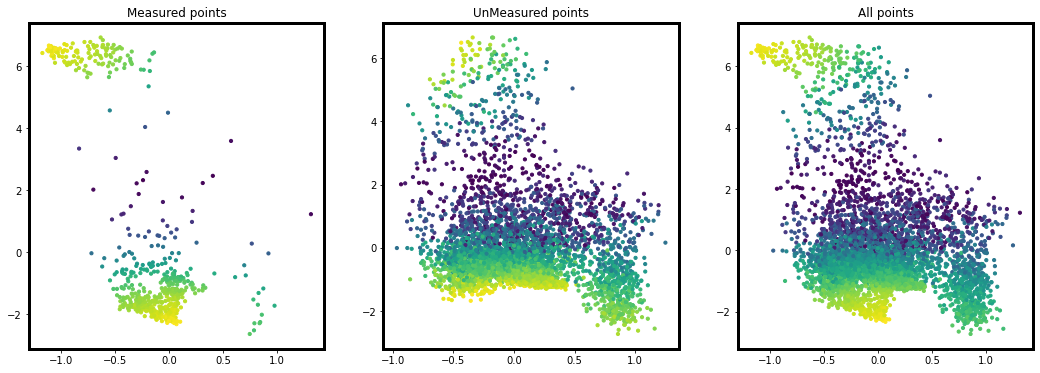

In [23]:
# Visualizing the latent distributions using the ground truths of the target function

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))

ax[0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = y5_train, alpha=1)
ax[0].set_title('Measured points')

ax[1].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10, c = p_total[indices_unmeasured_5])
ax[1].set_title('UnMeasured points')

ax[2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = p_total)
ax[2].set_title('All points')

Text(0.5, 1.0, 'Polarization_total (target function)')

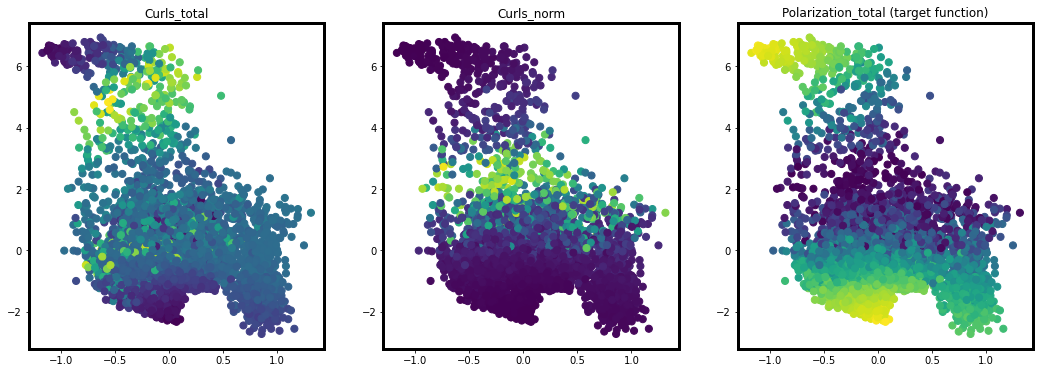

In [24]:
# Visulazing the entire latent distributions using ground-truths other target functions considered for this analysis
# Polarization is used in training, but latent distributions of curls and normalized curl are also plotted 
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].scatter(embeded15[:, 1], embeded15[:, 0], s=50, c = curls_total)
ax[0].set_title('Curls_total')

ax[1].scatter(embeded15[:, 1], embeded15[:, 0], s=50, c = curls_norm)
ax[1].set_title('Curls_norm')


ax[2].scatter(embeded15[:, 1], embeded15[:, 0], s=50, c = p_total)
ax[2].set_title('Polarization_total (target function)')